In [1]:
import alkanes
from alkanes import *

import random 

import rdkit.Chem
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
import torch.nn.functional as F

from deep_rl import *

from deep_rl.component.envs import DummyVecEnv, make_env

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

/export/zimmerman/tgog/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2018.09.1
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
1
3
5
7
2
4
6
8
9
11
13
15
17
glug glug


In [2]:
# from stable_baselines.common.policies import MlpPolicy
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import A2C
# # env = AlkaneEnv(mol)
# env = DummyVecEnv([lambda: AlkaneEnv(mode='train_simple')])

# model = A2C(MlpPolicy, env, verbose=1, tensorboard_log="./tf_log/")
# model.learn(total_timesteps=50000, tb_log_name="octane_mlp")


In [3]:
# obs = env.reset()
# for i in range(100):
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
#     env.render()


In [4]:
gym.envs.register(
     id='AlkaneEnv-v0',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v1',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'test'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v2',
     entry_point='alkanes:AlkaneEnv',
     kwargs={'mode': 'train_simple'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v3',
     entry_point='alkanes:AlkaneWithoutReplacementEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v4',
     entry_point='alkanes:AlkaneWithoutReplacementEnv',
     kwargs={'mode': 'test'},
     max_episode_steps=1000,
)

In [5]:
gym.envs.register(
     id='AlkaneEnv-v5',
     entry_point='alkanes:AlkaneDecoderEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v6',
     entry_point='alkanes:AlkaneDecoderEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)


In [6]:
gym.envs.register(
     id='AlkaneEnv-v7',
     entry_point='alkanes:AlkaneConvolutionEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)

gym.envs.register(
     id='AlkaneEnv-v8',
     entry_point='alkanes:AlkaneConvolutionEnv',
     kwargs={'mode': 'train'},
     max_episode_steps=1000,
)


In [7]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv

class DummyVecEnv(VecEnv):
    def __init__(self, env_fns):
        self.envs = [fn() for fn in env_fns]
        env = self.envs[0]
        VecEnv.__init__(self, len(env_fns), env.observation_space, env.action_space)
        self.actions = None

    def step_async(self, actions):
        self.actions = actions

    def step_wait(self):
        data = []
        for i in range(self.num_envs):
            obs, rew, done, info = self.envs[i].step(self.actions)
            if done:
                obs = self.envs[i].reset()
            data.append([obs, rew, done, info])
        obs, rew, done, info = zip(*data)
        return obs, np.asarray(rew), np.asarray(done), info

    def reset(self):
        return [env.reset() for env in self.envs]

    def close(self):
        return

In [17]:
class A2CEvalAgent(A2CAgent):
    def eval_step(self, state):
        prediction = self.network(self.config.state_normalizer(state))
        return prediction['a']

In [18]:
class A2CRecurrentEvalAgent(A2CRecurrentAgent):
    def eval_step(self, state, done, rstates):
        if done:
            prediction, rstates = self.network(self.config.state_normalizer(state))
        else:
            prediction, rstates = self.network(self.config.state_normalizer(state), rstates)
            
        return prediction['a'], rstates
    
    def eval_episode(self):
        env = self.config.eval_env
        state = env.reset()
        done = True
        rstates = None
        while True:
            action, rstates = self.eval_step(state, done, rstates)
            done = False
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            if ret is not None:
                break
        return ret

In [8]:
class AdaTask:
    def __init__(self,
                 name,
                 num_envs=1,
                 single_process=True,
                 log_dir=None,
                 episode_life=True,
                 seed=np.random.randint(int(1e5))):
        
        print ("seed is ", seed)
        if log_dir is not None:
            mkdir(log_dir)
        envs = [make_env(name, seed, i, episode_life) for i in range(num_envs)]
        if single_process:
            Wrapper = DummyVecEnv
        else:
            Wrapper = SubprocVecEnv
        self.env = Wrapper(envs)
        self.name = name
        self.observation_space = self.env.observation_space
        self.state_dim = int(np.prod(self.env.observation_space.shape))

        self.action_space = self.env.action_space
        self.action_dim = self.action_space.shape[0]

    def reset(self):
        return self.env.reset()

    def step(self, actions):
        return self.env.step(actions)

In [9]:
class TorsionMlpBaselineEmbedding(nn.Module, BaseNet):
    def __init__(self, seq_len, input_dim):
        super(TorsionMlpBaselineEmbedding, self).__init__()
        self.seq_len = seq_len
        self.input_dim = 2
        self.embedding = nn.Embedding(5, 2)
        
        self.fc_a1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len)
        
        self.fc_v1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_v2 = nn.Linear(64, 64)       
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
#         obs_tensor = torch.LongTensor(obs).view(-1, 1)
#         obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
#         obs_onehot.zero_()
#         obs_onehot.scatter_(1, obs_tensor, 1)      
        
#         obs_onehot = obs_onehot.view(1, -1)
#         obs_onehot = torch.FloatTensor(obs).view(1, -1)

        obs_onehot = self.embedding(torch.LongTensor(obs)).view(1, -1)

        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        #.view(-1, 2)
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        
        one_hot_action = [0] * self.seq_len
        one_hot_action[action] = 1
        action = torch.Tensor(one_hot_action)
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [10]:
class TorsionMlpBaseline(nn.Module, BaseNet):
    def __init__(self, seq_len, input_dim):
        super(TorsionMlpBaseline, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        self.fc_a1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len)
        
        self.fc_v1 = nn.Linear(self.seq_len * self.input_dim, 64)
        self.fc_v2 = nn.Linear(64, 64)       
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs).view(-1, 1)
        obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
        obs_onehot.zero_()
        obs_onehot.scatter_(1, obs_tensor, 1)      
        
        obs_onehot = obs_onehot.view(1, -1)
#         obs_onehot = torch.FloatTensor(obs).view(1, -1)
        
        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        #.view(-1, 2)
        
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        raise Exception()
        
        one_hot_action = [0] * self.seq_len
        one_hot_action[action] = 1
        action = torch.Tensor(one_hot_action)
        
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [11]:
class TorsionMlpManyAction(nn.Module, BaseNet):
    def __init__(self, seq_len):
        super(TorsionMlpManyAction, self).__init__()
        self.seq_len = seq_len
        
        self.fc_a1 = nn.Linear(self.seq_len * 5, 64)
        self.fc_a2 = nn.Linear(64, 64)
        self.fc_a3 = nn.Linear(64, self.seq_len * 2)
        
        self.fc_v1 = nn.Linear(self.seq_len * 5, 64)
        self.fc_v2 = nn.Linear(64, 64)
        self.fc_v3 = nn.Linear(64, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs).view(-1, 1)
        obs_onehot = torch.FloatTensor(obs_tensor.shape[0], 5)
        obs_onehot.zero_()
        obs_onehot.scatter_(1, obs_tensor, 1)      
        
        obs_onehot = obs_onehot.view(1, -1)
        
        output = F.relu(self.fc_a1(obs_onehot))
        output = F.relu(self.fc_a2(output))
        logits = self.fc_a3(output)
        logits = logits.view(-1, 2)
        
        
        output = F.relu(self.fc_v1(obs_onehot))
        output = F.relu(self.fc_v2(output))
        v = self.fc_v3(output)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [12]:
class TorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(TorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, action=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
                
        seq_len = obs_tensor.shape[0]

        #value
        _, (hn, cn) = self.value_lstm(obs_onehot.view(-1, 1, 2))   
        out = F.relu(self.value_fc(hn.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, _ = self.lstm(obs_onehot.view(-1, 1, 2))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [13]:
from torch.autograd import Variable
class RecurrentTorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(RecurrentTorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, states=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
        
#         if action:
#             print(type(action))
#             print(action)
#             print(action[0].shape)
#             raise Exception
        
        
        if states:
            hx_value, cx_value, hx_policy, cx_policy = states
        else:
            hx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            cx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            hx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))            
            cx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))
        
        seq_len = obs_tensor.shape[0]

        #value
        _, (hnv, cnv) = self.value_lstm(obs_onehot.view(-1, 1, 2), (hx_value.view(2,1,-1), cx_value.view(2,1,-1)))   
        out = F.relu(self.value_fc(hnv.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, (hnp, cnp) = self.lstm(obs_onehot.view(-1, 1, 2), (hx_policy.view(2,1,-1), cx_policy.view(2,1,-1)))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        prediction = {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }
        
        return prediction, (hnv, cnv, hnp, cnp)

In [14]:
from torch.autograd import Variable
class RecurrentDecoderTorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(RecurrentDecoderTorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.embedding = nn.Embedding(5, 2)
        
        # input of shape (seq_len, batch, input_size):
        self.lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.action_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.action_head = nn.Linear(self.hidden_dim * 2, self.action_dim)

        # value net
        self.value_lstm = nn.LSTM(2, self.hidden_dim, bidirectional=bidirectional)
        self.value_fc = nn.Linear(self.hidden_dim * 2, self.hidden_dim * 2)
        self.value_head = nn.Linear(self.hidden_dim * 2, 1)

    def forward(self, obs, states=None):
        obs_tensor = torch.LongTensor(obs)
        obs_onehot = self.embedding(obs_tensor)
        
#         if action:
#             print(type(action))
#             print(action)
#             print(action[0].shape)
#             raise Exception
        
        
        if states:
            hx_value, cx_value, hx_policy, cx_policy = states
        else:
            hx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            cx_value = Variable(torch.zeros(1, self.hidden_dim * 2))
            hx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))            
            cx_policy = Variable(torch.zeros(1, self.hidden_dim * 2))
        
        seq_len = obs_tensor.shape[0]

        #value
        _, (hnv, cnv) = self.value_lstm(obs_onehot.view(-1, 1, 2), (hx_value.view(2,1,-1), cx_value.view(2,1,-1)))   
        out = F.relu(self.value_fc(hnv.view(1, -1)))
        v = self.value_head(out)

        #action
        lstm_out, (hnp, cnp) = self.lstm(obs_onehot.view(-1, 1, 2), (hx_policy.view(2,1,-1), cx_policy.view(2,1,-1)))
        out = F.relu(self.action_fc(lstm_out.view(-1, 2 * self.hidden_dim)))
        logits = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)
        
        prediction = {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }
        
        return prediction, (hnv, cnv, hnp, cnp)

In [25]:
import torch.nn.init as init
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=128):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(2, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

class ConvTorsionDecoderNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim, bidirectional=True):
        super(ConvTorsionDecoderNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.squeezenet = SqueezeNet(num_classes=hidden_dim)
        self.embedding = nn.Embedding(action_dim, action_dim)
        
        # input of shape (seq_len, batch, input_size):
        self.decoder = nn.LSTM(self.hidden_dim, self.hidden_dim)
        self.action_fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.action_head = nn.Linear(self.hidden_dim, self.action_dim)

        # value net
        self.value_fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.value_head = nn.Linear(self.hidden_dim, 1)

    def forward(self, obs, action=None):
        
        obs = torch.Tensor(obs)
        seq_len = int(((obs.shape[-1] - 2) / 3) - 1)
        convs = self.squeezenet(torch.Tensor(obs))
        
        #value
        out = F.relu(self.value_fc(convs))
        v = self.value_head(out)

        #action
        outputs = []

        hn = Variable(torch.zeros(1, 1, self.hidden_dim))
        cn = Variable(torch.zeros(1, 1, self.hidden_dim))
        
        for i in range(seq_len):
            lstm_out, (hn, cn) = self.decoder(convs.reshape(1, 1, self.hidden_dim), (hn, cn))
            outputs.append(lstm_out)
        
        
        out = torch.stack(outputs)
        out = F.relu(self.action_fc(out.view(-1, self.hidden_dim)))
        logit = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logit)
        action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)

        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [100]:
class ConvTorsionNet(nn.Module, BaseNet):
    def __init__(self, action_dim, hidden_dim):
        super(ConvTorsionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.squeezenet = SqueezeNet(num_classes=hidden_dim)
        
        # input of shape (seq_len, batch, input_size):
        self.decoder = nn.LSTM(self.hidden_dim, self.hidden_dim)
        self.action_fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.action_head = nn.Linear(self.hidden_dim, self.action_dim)

        # value net
        self.value_fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.value_head = nn.Linear(self.hidden_dim, 1)

    def forward(self, obs, action=None):
        
        obs = torch.Tensor(obs)
        seq_len = int(((obs.shape[-1] - 2) / 3) - 1)
        convs = self.squeezenet(torch.Tensor(obs))
        
        #value
        out = F.relu(self.value_fc(convs))
        v = self.value_head(out)

        #action
        outputs = []

        hn = Variable(torch.zeros(1, 1, self.hidden_dim))
        cn = Variable(torch.zeros(1, 1, self.hidden_dim))
        
        for i in range(seq_len):
            lstm_out, (hn, cn) = self.decoder(convs.reshape(1, 1, self.hidden_dim), (hn, cn))
            outputs.append(lstm_out)
        
        
        out = torch.stack(outputs)
        out = F.relu(self.action_fc(out.view(-1, self.hidden_dim)))
        logit = self.action_head(out)

        dist = torch.distributions.Categorical(logits=logit)
        action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy = dist.entropy().unsqueeze(0)

        return {
            'a': action,
            'log_pi_a': log_prob,
            'ent': entropy,
            'v': v,
        }

In [101]:
def a2c_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.num_workers = 1
    config.task_fn = lambda: AdaTask('AlkaneEnv-v7', seed=random.randint(0,1e5))
    config.eval_env = AdaTask('AlkaneEnv-v8', seed=random.randint(0,1e5))
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=7e-4, alpha=0.99, eps=1e-5) #learning_rate #alpha #epsilon
    config.network_fn = lambda: ConvTorsionNet(3, 64)
    config.discount = 0.99 # gamma
    config.use_gae = False
#     config.gae_tau = 0.95
    config.value_loss_weight = 0.25 # vf_coef
    config.entropy_weight = 0.01 #ent_coef
    config.rollout_length = 5 # n_steps
    config.gradient_clip = 0.5 #max_grad_norm
#     config.eval_interval = 2000
#     config.eval_episodes = 3
    config.max_steps = 50000
    
    agent = A2CEvalAgent(config)
    run_steps(agent)
    return agent

In [102]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
select_device(-1)

from multiprocessing import Process
p = Process(target=a2c_feature, kwargs={'tag': 'CNN_lstm'}).start()
# agent = a2c_feature(tag='recurrent_test_1')
# ppo_feature(game='alkaneEnv')


seed is  32181
seed is  381
reset called
[-59.99998245461648, 59.99976591906305, 59.99991999634531, 59.9999329660875, 59.99988156639535, 179.99999849265276, -179.99994881534903]


I1105 03:35:16.193516 139927791580992 misc.py:25] steps 0, 61680941.18 steps/s


Z is  1646.2425377264608
gibbs  0.07314360581148475
max gibbs is  544.1167217716616
action is  [0 1 2 1 0 0 1 0 1]
reward is  0.004443063773124193
new state is:
[-180.0, -59.99999999999999, 180.0, 59.99999999999999, 59.99999999999999, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 0 2 0 2]
reward is  0.0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 60.00000000000002, -60.00000000000002, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 0 0 2 2 1 2 0 1]
reward is  0.0
new state is:
[60.00000000000001, 59.99999999999999, -59.99999999999994, -59.99999999999994, -180.0, -59.99999999999999, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 2 2 0 2 0 0 0 2]
reward is  0.0
new state is:
[-59.999999999999986, -59.99999999999997, 60.00000000000001, -59.99999999999997, 59.999999999999986, 59.999999999999

reward is  0.0
new state is:
[59.99999999999999, -59.999999999999986, 59.99999999999999, -60.00000000000001, 60.00000000000001, -60.00000000000001, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [0 2 0 2 0 0 1 1 0]
reward is  0.0
new state is:
[-59.999999999999986, 59.99999999999999, -59.99999999999999, 59.999999999999986, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.3523101421848724e-108
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 0 0 2 0]
reward is  8.21452557077329e-110
new state is:
[180.0, 179.99999999999997, 60.00000000000001, 180.0, 60.00000000000001, 59.99999999999999, -59.99999999999999]
Z is  1646.2425377264608
gibbs  0.011858698344248748
max gibbs is  544.1167217716616
action is  [0 0 1 0 0 1 2 2 2]
reward is  0.0007203494061468109
new state is:
[59.99999999999997, 180.0, 59.99999999999999, 59.999999999999986, -180.0, -60.00000000000001, -60.00000000000001]
Z is  1646.2425377264608
gibbs  0.

Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 2 0 1 0 0 2 0 0]
reward is  0.0
new state is:
[-59.99999999999999, 60.00000000000002, 180.0, 59.999999999999986, 59.99999999999999, -60.00000000000001, 59.99999999999994]
Z is  1646.2425377264608
gibbs  5.4893116326271e-108
max gibbs is  544.1167217716616
action is  [2 2 0 0 1 2 1 2 0]
reward is  3.334448908244165e-109
new state is:
[-60.00000000000002, 59.99999999999999, 59.999999999999986, 180.0, -60.00000000000001, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  5.2955471984183506e-107
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 0 2 2]
reward is  3.216747883171427e-108
new state is:
[-180.0, 59.99999999999999, 180.0, 179.99999999999997, 59.999999999999986, 60.00000000000001, -59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 2 0 2 0 0 1 1 1]
reward is  0
new state is:
[-59.99999999999994, 60.00000000000001, -60.00000000000001, 59.99999999999999, 59.999

action is  [2 0 0 0 1 1 1 1 1]
reward is  0.06090767018859596
new state is:
[59.99999999999999, 59.99999999999997, 59.99999999999999, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.585328486920061
max gibbs is  544.1167217716616
action is  [1 1 1 0 0 1 2 1 1]
reward is  0.03555542233335967
new state is:
[-180.0, 180.0, 59.99999999999999, 59.999999999999986, 180.0, -59.999999999999986, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.379732951359779e-146
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 0 1 0 0]
reward is  3.267886005903751e-147
new state is:
[59.999999999999986, 180.0, 180.0, -59.99999999999997, 59.999999999999986, 179.99999999999994, 59.99999999999999]
Z is  1646.2425377264608
gibbs  3.451168371655774e-126
max gibbs is  544.1167217716616
action is  [1 2 2 0 1 1 0 1 0]
reward is  2.0963912015188245e-127
new state is:
[-59.999999999999986, -59.99999999999994, 59.99999999999999, 180.0, 180.0, 59.99999999999997, 179.99999999999997]
Z is  1646.2

I1105 03:35:25.538770 139927791580992 BaseAgent.py:67] steps 99, episodic_return_train 4.6243321304796705


Z is  1646.2425377264608
gibbs  0.008707163710595898
max gibbs is  544.1167217716616
action is  [2 0 1 2 1 0 0 0 2]
reward is  0.0005289113548615325
new state is:
[60.00000000000002, 180.0, -59.999999999999986, -180.0, 59.99999999999999, 59.99999999999999, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 2 0 0 2 2 1 1 1]
reward is  0.0
new state is:
[-60.00000000000005, 59.99999999999997, 60.00000000000001, -59.99999999999997, -59.99999999999999, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.877486674760988e-123
max gibbs is  544.1167217716616
action is  [0 0 0 1 0 1 2 0 1]
reward is  1.7479117498293621e-124
new state is:
[59.99999999999999, 59.999999999999986, -179.99999999999997, 59.999999999999986, 179.99999999999997, -59.99999999999996, 60.000000000000036]
Z is  1646.2425377264608
gibbs  0.07917755252573867
max gibbs is  544.1167217716616
action is  [0 1 1 0 0 1 0 0 0]
reward is  0.004809592190169416
new state is:
[

Z is  1646.2425377264608
gibbs  0.6991087305974673
max gibbs is  544.1167217716616
action is  [1 1 0 0 1 1 2 1 1]
reward is  0.04246693391624843
new state is:
[180.0, 59.999999999999986, 59.999999999999986, -180.0, -179.99999999999997, -59.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  0.059905538341164404
max gibbs is  544.1167217716616
action is  [1 0 1 2 1 0 0 1 2]
reward is  0.0036389254297788222
new state is:
[59.999999999999986, -180.0, -59.999999999999986, 180.0, 59.999999999999986, 60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  48.081983083358566
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207107690074676
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904621758
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574743981031725
new state is:
[180.0, -180.0, -180.0, 180.0, 59.99999999999999, 180.0, 179.99999999999994]
Z is  1646.242537

Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 0 2 0 1 0 0 1 1]
reward is  0.0
new state is:
[59.99999999999997, -60.000000000000036, 59.99999999999994, -180.0, 60.00000000000001, 59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 0 0 0 2 0 1 1 1]
reward is  0.0
new state is:
[59.999999999999986, 59.999999999999986, 59.99999999999997, -59.99999999999993, 59.999999999999986, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 2 1 2 0 0 2 1 1]
reward is  0.0
new state is:
[-59.999999999999986, 179.99999999999997, -59.99999999999999, 60.00000000000001, 60.00000000000001, -60.00000000000001, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -180.0, 60.00000000000001, -179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  1.9660738

I1105 03:35:34.483129 139927791580992 BaseAgent.py:67] steps 199, episodic_return_train 69.59579513554749


Z is  589.0305102196965
gibbs  1.407911541418587e-120
max gibbs is  292.85919739265063
action is  [1 1 1 0 2 1]
reward is  2.3902183621922476e-121
new state is:
[180.0, -180.0, 60.00000000000002, -59.999999999999986]
Z is  589.0305102196965
gibbs  25.73734879656388
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  4.369442388810109
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  292.8591982458846
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008386
new state is:
[179.99999999999997, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.708694422565546
max gibbs is  292.85919739265063
action is  [0 1 1 1 2 1]
reward is  5.3832006784739965
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.826525228350077
max gibbs is  292.85919739265063
action is  [1 0 1 0 1 0]
reward is  0.4798605809562972
new state is:
[59.99999999

reset called
[-59.99963294260284, -59.9997348638781, -179.99995972205394, -59.99969322360504, -59.99994637729953]


I1105 03:35:38.447503 139927791580992 BaseAgent.py:67] steps 249, episodic_return_train 78.4839936204127


Z is  831.15924230415
gibbs  39.02817025018649
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.695630904854299
new state is:
[60.00000000000002, -180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  30.929227176005888
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.721215574799301
new state is:
[179.99999999999997, 180.0, 59.999999999999986, -179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  3.4028613092819
max gibbs is  359.9107662155537
action is  [1 0 1 0 1 1 1]
reward is  0.40941147449054954
new state is:
[60.00000000000002, 180.0, 59.999999999999986, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  359.910766491392
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  43.302263654512565
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 179.9

already seen
max gibbs is  359.9107662155537
action is  [0 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, -180.0, 179.99999999999997, 179.99999999999994]
Z is  831.15924230415
gibbs  3.4986792755962295
max gibbs is  359.9107662155537
action is  [2 1 0 1 1 0 0]
reward is  0.4209397065593769
new state is:
[-179.99999999999997, 59.999999999999986, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999

I1105 03:35:42.767337 139927791580992 BaseAgent.py:67] steps 299, episodic_return_train 73.16180127201845


Z is  831.15924230415
gibbs  359.9107664913897
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  43.302263654512295
new state is:
[-180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  3.653937548540928
max gibbs is  359.9107662155537
action is  [1 2 1 1 0 1 1]
reward is  0.43961943302362094
new state is:
[-59.99999999999996, 180.0, -180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.240339497541729
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 0 0]
reward is  0.5101717314466248
new state is:
[60.00000000000002, -180.0, -179.99999999999997, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  31.73046693861017
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 1]
reward is  3.8176158458692675
new state is:
[179.99999999999997, -180.0, 179.

action is  [1 2 0 0 1 1 1]
reward is  4.7685391680338446e-107
new state is:
[-60.00000000000001, 59.99999999999997, 59.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -59.99999999999999, -180.0, -180.0]
Z is  831.15924230415
gibbs  0.5661747808886095
max gibbs is  359.9107662155537
action is  [1 0 1 0 0 1 1]
reward is  0.06811868918392253
new state is:
[59.99999999999997, 180.0, 59.999999999999986, 59.99999999999999, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0]
reset called
[-60.00000000

I1105 03:35:47.087114 139927791580992 BaseAgent.py:67] steps 349, episodic_return_train 74.92631117497


Z is  831.15924230415
gibbs  0.5661747808886355
max gibbs is  359.9107662155537
action is  [1 0 1 0 0 1 1]
reward is  0.06811868918392566
new state is:
[60.00000000000002, 180.0, 59.999999999999986, 60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  359.91076649138876
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  43.30226365451218
new state is:
[179.99999999999997, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.4985809705052717
max gibbs is  359.9107662155537
action is  [2 0 1 1 0 1 1]
reward is  0.4209278790916723
new state is:
[59.99999999999999, 180.0, 179.99999999999997, 60.00000000000001, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02904900746913
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 0 2]
reward is  4.695736631559594
new state is:
[-180.0, 180.0, 180.0, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  1.2286343374663537e-121
max gibbs is  359.9107662155537
action is  [0 0 1 1 2 0 1]
reward is  1.478217740875

reward is  0
new state is:
[-180.0, -59.99999999999996, 179.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -59.99999999999993, 180.0, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 59.99999999999999, 180.0, 179.99999999999994, 180.0]
reset called
[-60.00000000000006, -180.0, -60.00000000000002, 179.99999999999997, -60.00000000000001]


I1105 03:35:51.401463 139927791580992 BaseAgent.py:67] steps 399, episodic_return_train 87.84024681687046


Z is  831.15924230415
gibbs  4.551164275720655
max gibbs is  359.9107662155537
action is  [1 1 2 2 1 1 1]
reward is  0.5475682690002773
new state is:
[179.99999999999997, -60.000000000000036, -59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.9107664913913
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  43.30226365451249
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.6871821647136
max gibbs is  359.9107662155537
action is  [1 1 0 1 2 1 1]
reward is  0.32330533403733325
new state is:
[180.0, 59.999999999999986, 180.0, -59.99999999999994, 180.0]
Z is  831.15924230415
gibbs  2.8387936139487864
max gibbs is  359.9107662155537
action is  [0 1 0 1 0 1 1]
reward is  0.3415462969621859
new state is:
[180.0, 59.99999999999999, 180.0, 60.00000000000002, 180.0]
Z is  

reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  39.028903716116936
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 2 1]
reward is  4.695719150992116
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, -180.0, -180.0, -179.99999999999997]
reset called
[179.99995261586915, 60.00002965705014, 60.00005331893735, 179.99993533326386, 60.00000744735537, 59.999773265810255]


I1105 03:35:55.518186 139927791580992 BaseAgent.py:67] steps 449, episodic_return_train 80.63233215425635


Z is  1191.1514450692125
gibbs  4.2174702719933395
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 1 1 1]
reward is  0.35406667132476016
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 60.000000000000036, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08159451581101
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
reward is  3.280992914678465
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200876687875936
max gibbs is  442.4913983254663
action is  [1 0 1 0 1 1 1 1]
reward is  0.35267360042801627
new state is:
[59.99999999999993, -180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6881529288802906
max gibbs is  442.4913983254663
action is  [2 0 0 1 1 1 2 0]
reward is  0.05777207690331141
new state is:
[60.00000000000002, 59.99999999999991, -179.99999999999997, 180.0, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  442.4913984022886


already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 59.99999999999996, -180.0]
Z is  1191.1514450692125
gibbs  5.648925220228257
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 1 1 1]
reward is  0.47424072258922734
new state is:
[180.0, 59.99999999999999, 59.99999999999997, 179.99999999999994, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.235553261881997
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 0 1 1]
reward is  0.35558478138234456
new state is:
[-60.00000000000011, -179.99999999999994, -179.99999999999997, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000006, 179.99999999999994, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999994, 179.99999999999997, 180.0, -180.0, 180.0

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 59.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 1 1 2]
reward is  0
new state is:
[180.0, 59.999999999999986, 59.999999999999986, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9810044571671703
max gibbs is  442.4913983254663
action is  [1 2 1 0 1 1 1 1]
reward is  0.3342148031341096
new state is:
[-59.99999999999997, 180.0, 59.99999999999999, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.2486441680047164
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 2 1]
reward is  0.3566837941213971
new state is:
[180.0, -59.99999999999992, -180.0, 179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, -179.99999999999997, 60.00000000000001, -180.0, 60.00000000000002]
already seen

I1105 03:36:04.502582 139927791580992 BaseAgent.py:67] steps 549, episodic_return_train 82.68538631457584


Z is  1191.1514450692125
gibbs  2.526401778706744e-125
max gibbs is  442.4913983254663
action is  [2 1 1 1 2 0 0 1]
reward is  2.1209744480139937e-126
new state is:
[179.99999999999997, -179.99999999999997, -180.0, -59.99999999999992, 59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16986392329315
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 1 1 1]
reward is  3.2044509605640674
new state is:
[179.99999999999991, -180.0, 59.99999999999999, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00333887168748
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.029994596438425
new state is:
[-179.99999999999997, 180.0, -180.0, 180.0, 179.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  442.49139840229645
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826777
new state is:
[-180.0, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220703968927135
max gibbs is

Z is  1191.1514450692125
gibbs  1.610980827442877e-121
max gibbs is  442.4913983254663
action is  [1 2 0 1 0 1 1 0]
reward is  1.352456762833604e-122
new state is:
[-59.999999999999986, 59.99999999999999, 180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 0 1 1 2 1 0]
reward is  0
new state is:
[179.99999999999997, 59.99999999999994, -179.99999999999997, -180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  3.4220307858922174
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 2 1 1]
reward is  0.28728763248852696
new state is:
[-180.0, -180.0, -60.00000000000006, 180.0, -60.00000000000002, 180.0]
already see

reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 60.00000000000002, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 0 1]
reward is  0
new state is:
[-60.00000000000006, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 60.00000000000001, -59.999999999999986, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 1 1 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 179.99999999999997, 59.99999999999996, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.285196748275784e-145
max gibbs is  442.4913983254663
action is  [1 1 1 2 0 1 0 2]
reward is  4.43704851314577e-146
new state

I1105 03:36:12.041362 139927791580992 BaseAgent.py:67] steps 649, episodic_return_train 82.81921514336638


Z is  831.15924230415
gibbs  3.6538662455761792
max gibbs is  359.9107662155537
action is  [1 0 1 1 2 1 1]
reward is  0.43961085428670515
new state is:
[59.999999999999986, 179.99999999999997, -179.99999999999997, -60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  0.47310019279323257
max gibbs is  359.9107662155537
action is  [1 2 1 0 0 1 1]
reward is  0.05692052361490902
new state is:
[-59.99999999999999, 180.0, 59.99999999999999, 60.00000000000002, -180.0]
Z is  831.15924230415
gibbs  39.0289037161152
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 2 1]
reward is  4.695719150991907
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -59.99999999999996]
Z is  831.15924230415
gibbs  30.9292271760099
max gibbs is  359.9107662155537
action is  [2 1 1 0 1 1 0]
reward is  3.7212155747997833
new state is:
[180.0, 180.0, 60.00000000000005, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730466938612114
max gibbs is  359.9107662155537
action is  [2 1 1 1 2 1 1]
reward is  3.8176

already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-60.00000000000001, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  2.3685422358322807e-126
max gibbs is  359.9107662155537
action is  [1 2 1 2 0 0 1]
reward is  2.8496852531726396e-127
new state is:
[-60.000000000000036, 180.0, -59.99999999999994, 59.99999999999997, 59.999999999999986]
reset called
[179.99999999999997, 59.999999999999986, -59.99999999999996, -60.00000000000005, 59.99999999999999]


I1105 03:36:16.180427 139927791580992 BaseAgent.py:67] steps 699, episodic_return_train 81.85993652906753


Z is  831.15924230415
gibbs  39.028170250192815
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.69563090485506
new state is:
[59.999999999999986, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  39.02870552791972
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 1 1]
reward is  4.695695306199551
new state is:
[-60.00000000000002, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  359.9107664913923
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.3022636545126
new state is:
[-180.0, -180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4028613092829336
max gibbs is  359.9107662155537
action is  [1 0 1 0 1 1 1]
reward is  0.4094114744906739
new state is:
[59.999999999999986, 180.0, 59.99999999999997, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  3.402937757571462
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 0 1]
reward is  0.40942067228149875
new state is:
[-180.0, 180.0

Z is  831.15924230415
gibbs  3.226950397101044
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 2 1]
reward is  0.38824694870206244
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, -59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
reset called
[59.99999999999994, -59.99999999999999, 180.0, -59.99999999999999]


I1105 03:36:20.394582 139927791580992 BaseAgent.py:67] steps 749, episodic_return_train 80.06734043012827


Z is  589.0305102196965
gibbs  292.8591982458854
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083995
new state is:
[179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737474154051295
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 1]
reward is  4.369463670812525
new state is:
[-180.0, 180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.70869442256449
new state is:
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 2]
reward is  5.383200678473818
[179.99999999999997, 179.99999999999997, 180.0, -59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0,

I1105 03:36:24.461561 139927791580992 BaseAgent.py:67] steps 799, episodic_return_train 91.03793754841358


Z is  589.0305102196965
gibbs  31.710772203688023
max gibbs is  292.85919739265063
action is  [2 0 1 1 1 2]
reward is  5.383553424399111
new state is:
[60.00000000000001, 179.99999999999997, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737474154052837
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 1]
reward is  4.369463670812787
new state is:
[179.99999999999997, 180.0, -59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  292.85919824588564
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  49.71885041008404
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 0 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  3.4820977914165216
max gibbs is  292.85919739265063
action is  [2 2 1 1 2 1]
reward is  0.59115

I1105 03:36:28.248184 139927791580992 BaseAgent.py:67] steps 849, episodic_return_train 90.72828207440976


Z is  1191.1514450692125
gibbs  0.3754560495182379
max gibbs is  442.4913983254663
action is  [0 0 1 0 1 0 1 1]
reward is  0.03152042933519859
new state is:
[60.00000000000001, 180.0, 59.999999999999986, 180.0, 59.99999999999999, 179.99999999999997]
Z is  1191.1514450692125
gibbs  2.376476945982417e-140
max gibbs is  442.4913983254663
action is  [0 1 0 2 1 1 1 1]
reward is  1.995108981162618e-141
new state is:
[180.0, 60.00000000000002, -59.99999999999999, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.49139840229174
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 0]
reward is  37.14820648826737
new state is:
[179.99999999999994, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08171076065908
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.281002673710245
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999997, 180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.169863923303204
ma

Z is  1191.1514450692125
gibbs  48.00333887168987
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 0 1]
reward is  4.029994596438626
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 2 2 1]
reward is  0
new state is:
[180.0, 179.99999999999994, -179.99999999999997, -179.99999999999994, -60.00000000000002, -59.99999999999996]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 60.00000000000001, 179.99999999999994, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 60.00000000000001, 179.99999999999991, 180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 1 2]
reward is  0
new state is:
[60.000000000000036, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.

reward is  0.35267508159282107
new state is:
[179.99999999999994, -179.99999999999997, -179.99999999999997, 59.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -180.0, 59.999999999999986, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, -180.0, -180.0, -59.99999999999996, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 1 1]
reward is  0
new state is:
[60.00000000000001, -179.99999999999997, 179.99999999999997, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 0 1]
reward is  0
new state is:
[-59.99999999999991, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 2

I1105 03:36:36.455482 139927791580992 BaseAgent.py:67] steps 949, episodic_return_train 79.58675877358247


Z is  831.15924230415
gibbs  359.9107664913913
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451249
new state is:
[180.0, -180.0, -180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  2.389102928513521e-141
max gibbs is  359.9107662155537
action is  [1 0 1 0 2 1 1]
reward is  2.874422621939955e-142
new state is:
[59.999999999999986, 180.0, 59.99999999999997, -59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  31.73083229986657
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  3.8176598039025547
new state is:
[-180.0, 59.99999999999999, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000001, -180.0, -179.99999999999997, 180.0]
Z is  831.15924230415
gibbs

max gibbs is  359.9107662155537
action is  [1 0 1 2 2 1 0]
reward is  0.0569197895044252
new state is:
[59.99999999999996, 179.99999999999997, -59.99999999999993, -59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  0.6082414750603299
max gibbs is  359.9107662155537
action is  [1 0 1 1 2 2 1]
reward is  0.07317989671559871
new state is:
[59.99999999999999, 180.0, -180.0, -59.99999999999997, -59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4028613092829323
max gibbs is  359.9107662155537
action is  [1 0 1 0 1 1 1]
reward is  0.4094114744906738
new state is:
[59.99999999999997, 180.0, 59.999999999999986, -180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, -60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 

I1105 03:36:40.216227 139927791580992 BaseAgent.py:67] steps 999, episodic_return_train 78.66832713767066
I1105 03:36:40.417570 139927791580992 misc.py:25] steps 1000, 11.87 steps/s


Z is  1646.2425377264608
gibbs  59.036812587021466
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 0 1]
reward is  3.5861552131045107
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  544.1167218817232
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.052038773896236
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.040959046219236
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 1 1 0]
reward is  2.857474398103273
new state is:
[180.0, 180.0, 180.0, -180.0, 59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.975746789190731
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 2 2 1 1]
reward is  0.42373748881647594
new state is:
[180.0, 180.0, 180.0,

gibbs  2.3832409583049807e-122
max gibbs is  544.1167217716616
action is  [1 0 2 1 2 2 1 1 1]
reward is  1.447685200502928e-123
new state is:
[59.99999999999999, -60.00000000000001, -180.0, -60.00000000000001, -60.00000000000001, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.493099648219414
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 2 1 1]
reward is  0.2729306007621817
new state is:
[-180.0, -180.0, 59.99999999999997, 180.0, 179.99999999999997, -59.99999999999994, -180.0]
Z is  1646.2425377264608
gibbs  59.037473099635626
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5861953355408485
new state is:
[-59.99999999999994, 180.0, -180.0, 180.0, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 1 1 1 0]
re

new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  59.040123727745865
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 0]
reward is  3.5863563463305406
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, 180.0, 180.0, 180.0, 179.99999999999994, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, -180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999999, -179.99999999999997, -179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180

I1105 03:36:48.826247 139927791580992 BaseAgent.py:67] steps 1099, episodic_return_train 83.35277444078274


Z is  1191.1514450692125
gibbs  442.4913984022902
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 0]
reward is  37.14820648826724
new state is:
[179.99999999999991, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.08171076066036
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.281002673710352
new state is:
[-180.0, -180.0, 180.0, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  38.169749942593604
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 0]
reward is  3.204441391612947
new state is:
[179.99999999999997, 180.0, 180.0, -59.99999999999999, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.377152210186548e-140
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 2 1 1]
reward is  1.9956758815403377e-141
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 60.00000000000001, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  39.08159451578232
max g

action is  [1 0 1 1 1 0 2 1]
reward is  1.7161693221522616e-122
new state is:
[60.00000000000001, 179.99999999999997, -180.0, -180.0, 59.99999999999996, -59.99999999999999]
Z is  1191.1514450692125
gibbs  5.213252843881999
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 2 2]
reward is  0.4376649892389695
new state is:
[-59.99999999999993, -180.0, 179.99999999999997, 179.99999999999997, 180.0, -60.00000000000002]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999994, -179.99999999999997, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, -180.0, 180.0, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  5.607956208923453
max gibbs is  442.4913983254663
action is  [1 1 1 2 2 1 1 1]
reward is  0.4708012765410867
new state is:
[180.0, -180.0, -59.99999999999996, -5

action is  [2 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 59.999999999999986, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.5707196329397266
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 0 1 1]
reward is  0.04791327209501598
new state is:
[59.99999999999992, 59.999999999999986, 180.0, -180.0, 60.00000000000002, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.17002910617376
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 2]
reward is 

I1105 03:36:56.471179 139927791580992 BaseAgent.py:67] steps 1199, episodic_return_train 85.92660390815293


Z is  831.15924230415
gibbs  30.92922717601254
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 1 0]
reward is  3.721215574800101
new state is:
[-180.0, -180.0, 59.999999999999986, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  39.028170250191046
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 1]
reward is  4.695630904854847
new state is:
[59.99999999999996, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.999999999999986, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  359.91076649138944
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451226
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  30.92907601660268
max gibbs is  359.910766215

Z is  831.15924230415
gibbs  2.296091846343325e-125
max gibbs is  359.9107662155537
action is  [0 2 2 0 1 1 1]
reward is  2.762517372697524e-126
new state is:
[-59.999999999999986, -59.99999999999999, 59.99999999999997, 180.0, 179.99999999999994]
Z is  831.15924230415
gibbs  0.4730940911659628
max gibbs is  359.9107662155537
action is  [1 0 1 2 2 1 0]
reward is  0.056919789504408985
new state is:
[59.999999999999986, 180.0, -60.00000000000001, -59.99999999999999, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999994, -179.99999999999997, 179.99999999999997]
reset called
[59.999999999999986, 180.0, -60.00000000000001, 180.0]


I1105 03:37:00.246081 139927791580992 BaseAgent.py:67] steps 1249, episodic_return_train 86.71396906442794


Z is  589.0305102196965
gibbs  292.8591982458859
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 1]
reward is  49.71885041008409
new state is:
[179.99999999999997, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  7.38472229444682e-137
max gibbs is  292.85919739265063
action is  [1 1 0 2 1 1]
reward is  1.253707943191681e-137
new state is:
[179.99999999999997, 59.99999999999999, -60.00000000000001, -180.0]
Z is  589.0305102196965
gibbs  3.4820977914162414
max gibbs is  292.85919739265063
action is  [1 2 1 1 2 0]
reward is  0.5911574580606171
new state is:
[-60.00000000000001, -180.0, 179.99999999999997, -59.999999999999986]
Z is  589.0305102196965
gibbs  31.70869442256511
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 1]
reward is  5.383200678473923
new state is:
[-180.0, 180.0, 179.99999999999997, -60.00000000000001]
Z is  589.

I1105 03:37:04.220597 139927791580992 BaseAgent.py:67] steps 1299, episodic_return_train 86.11507958006182


Z is  1191.1514450692125
gibbs  38.17002910617359
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  3.204464828060188
new state is:
[179.99999999999997, 179.99999999999997, -60.00000000000001, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248717634958485
max gibbs is  442.4913983254663
action is  [2 1 0 1 1 1 0 1]
reward is  0.3566899618470942
new state is:
[-179.99999999999997, 60.00000000000002, -179.99999999999997, 180.0, 179.99999999999997, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.200832978068548
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 2 1]
reward is  0.352669930885611
new state is:
[-180.0, 179.99999999999997, -180.0, -59.999999999999986, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  39.08171076066328
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 1]
reward is  3.281002673710597
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997, 60.00000000000001, 179.99999999999997]
Z is  1191

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 2]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 179.99999999999997, -59.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  2.065325980608194e-141
max gibbs is  442.4913983254663
action is  [2 0 1 1 2 0 1 1]
reward is  1.733890337083197e-142
new state is:
[60.000000000000036, 180.0, 180.0, -59.999999999999986, 59.99999999999999, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 0 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999997, 179.99999999999997, -180.0, -179.99999999999997, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.429190137954945
max gibbs is  442.4913983254663
action is  [1 0 1 1 2 1 1 1]
reward is  0.3718410581869869
new state is:
[59.999999999999986, 179.99999999999997, -179.99999999999997, -60.000000000000036, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 60

[180.0, 179.99999999999994, 180.0, 180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 0 0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999994, 60.00000000000005, 59.999999999999986, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999999, 179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 2]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 179.99999999999994, -59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, -179.99999999999997, 179.9

I1105 03:37:13.092332 139927791580992 BaseAgent.py:67] steps 1399, episodic_return_train 84.35712672995663


Z is  1646.2425377264608
gibbs  59.04180097876146
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5864582299216368
new state is:
[60.00000000000001, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  544.1167218817264
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773896435
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.037473099637204
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.586195335540944
new state is:
[-60.00000000000002, -180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 180.0, -180.0]

gibbs  4.25022651808413
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 0 1 1]
reward is  0.25817742043975456
new state is:
[-180.0, -180.0, 60.00000000000001, -180.0, -180.0, 59.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 

reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 180.0, 180.0, -179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, -180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.224045664008339
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.317331471170888
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 1 1 1 1]
reward is  0
new state i

I1105 03:37:21.867402 139927791580992 BaseAgent.py:67] steps 1499, episodic_return_train 77.58491511724877


Z is  1646.2425377264608
gibbs  48.0819830833146
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.920710769004797
new state is:
[-180.0, -180.0, 180.0, 179.99999999999997, 180.0, 59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  544.116721881729
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773896584
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.3033990034073678e-120
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 2 1]
reward is  1.3991856914282333e-121
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 60.00000000000002, -60.00000000000002]
Z is  1646.2425377264608
gibbs  47.041197167054996
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 0]
reward is  2.857488862608369
new state is:
[180.0, 180.0, 59.99999999999996, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904619626
max gibbs is  544.1167217716616
action is  

gibbs  6.975743886272179
max gibbs is  544.1167217716616
action is  [2 1 0 0 1 1 1 1 1]
reward is  0.42373731248045704
new state is:
[180.0, 59.99999999999999, 59.999999999999986, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -180.0, -59.99999999999993, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999999, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.4063681134147155
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 2 2]
reward is  0.3891509280438236
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, 180.0, 180.0, -59.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, -180.0, -180.0, 179.99999999999997]
Z 

action is  [1 1 0 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 59.99999999999999, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, -180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.8201576776842007e-140
max gibbs is  544.1167217716616
action is  [1 1 0 2 1 1 1 1 1]
reward is  1.7130875998253408e-141
new state is:
[180.0, 59.99999999999999, -59.99999999999996, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4425994404781918
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 0 1 2 2]
reward is  0.026885433363266303
new state is:
[180.0, 59.99999999999999, 179.99999999999997, 180.0, 59.999999999999986, -179.99999999999997, -60.00000000000005]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 179.99999999999997, 

I1105 03:37:30.462287 139927791580992 BaseAgent.py:67] steps 1599, episodic_return_train 80.04878572651582


Z is  1646.2425377264608
gibbs  544.1167218817251
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203877389635
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12127416127942
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.862353090836551
new state is:
[180.0, -180.0, 180.0, 60.000000000000036, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.040959046184746
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.857474398101178
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08198308329399
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.920710769003545
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  5.177738011728046
max gibbs is  544.1167217716

new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 0 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, 180.0, -180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.45967799087434086
max gibbs is  544.1167217716616
action is  [0 1 2 1 0 1 1 2 1]
reward is  0.027922859502171413
new state is:
[180.0, -59.99999999999999, -180.0, 60.00000000000001, -180.0, 180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.08094266750467
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.920647569580284
new state is:
[179.99999999999997, 60.00000000000001, 180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.465

[180.0, -180.0, -180.0, -179.99999999999997, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 59.999999999999986, -180.0, 60.000000000000036, -180.0]
Z is  1646.2425377264608
gibbs  5.210184116588184
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 1 1 1 1]
reward is  0.3164894599178379
new state is:
[59.999999999999986, 180.0, -180.0, 59.999999999999986, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08210997035228
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.9207184766805963
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0, -60.00000000000001, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 59.99999999999997, 60.00000000000005]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1

I1105 03:37:39.045984 139927791580992 BaseAgent.py:67] steps 1699, episodic_return_train 72.22776667724634


Z is  589.0305102196965
gibbs  31.71077220368477
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  5.383553424398558
new state is:
[60.00000000000002, -179.99999999999997, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737474154052197
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 2]
reward is  4.369463670812678
new state is:
[179.99999999999997, -179.99999999999997, -59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  25.73749027764835
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  4.369466408123544
new state is:
[180.0, 60.000000000000036, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.5363235484979162
max gibbs is  292.85919739265063
action is  [0 2 2 2 1 1]
reward is  0.09105191313398661
new state is:
[-60.00000000000001, -59.99999999999999, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  25.737818007959515
max gibbs is  292.85919739265063
action is  [1 1 2 1 1 1]
reward is  4.369522047059978
new state is:
[-180.0, 

already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999997, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0]
reset called
[180.0, -59.999999999999986, -59.99999999999994, -59.99999999999993, 179.99999999999994]


I1105 03:37:43.051973 139927791580992 BaseAgent.py:67] steps 1749, episodic_return_train 87.66182205339828


Z is  831.15924230415
gibbs  5.47952686367169e-108
max gibbs is  359.9107662155537
action is  [2 0 0 0 0 2 1]
reward is  6.592631814429781e-109
new state is:
[59.99999999999996, 59.999999999999986, 59.99999999999999, 59.999999999999986, -59.99999999999999]
Z is  831.15924230415
gibbs  1.5739798522145993e-120
max gibbs is  359.9107662155537
action is  [1 2 0 1 1 1 1]
reward is  1.8937163567491504e-121
new state is:
[-60.00000000000002, 60.00000000000001, 180.0, -179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  39.02817025019023
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.695630904854748
new state is:
[59.99999999999999, -179.99999999999997, 180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  359.91076649139325
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.302263654512714
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward

new state is:
[59.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 59.99999999999999, 180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  0.5661847641175127
max gibbs is  359.9107662155537
action is  [0 1 0 0 1 0 1]
reward is  0.06811989030500681
new state is:
[179.99999999999997, 59.999999999999986, 59.99999999999996, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  3.226873697968402
max gibbs is  359.9107662155537
action is  [2 0 1 2 1 1 1]
reward is  0.388237720731207
new state is:
[60.00000000000001, -180.0, -60.00000000000001, -180.0, 180.0]
reset called
[-

I1105 03:37:47.446659 139927791580992 BaseAgent.py:67] steps 1799, episodic_return_train 73.11693699494336


Z is  589.0305102196965
gibbs  292.8591982458838
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083725
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  31.711657564537216
max gibbs is  292.85919739265063
action is  [1 2 1 1 1 1]
reward is  5.383703732546794
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4079115414258697e-120
max gibbs is  292.85919739265063
action is  [0 1 1 0 2 1]
reward is  2.390218362204612e-121
new state is:
[179.99999999999994, 179.99999999999997, 59.99999999999996, -59.999999999999986]
Z is  589.0305102196965
gibbs  25.737490277650124
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 2]
reward is  4.369466408123844
new state is:
[180.0, 59.99999999999997, -180.0, 180.0]
Z is  589.0305102196965

already seen
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, 180.0]
reset called
[60.00000000000001, 59.999999999999986, 180.0, 59.99999999999997, 59.99999999999989]


I1105 03:37:50.970193 139927791580992 BaseAgent.py:67] steps 1849, episodic_return_train 90.93111964038789


Z is  831.15924230415
gibbs  31.730652374596172
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.8176381563937207
new state is:
[180.0, 180.0, 180.0, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  3.226950397100093
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 2 2]
reward is  0.388246948701948
new state is:
[180.0, 180.0, 59.99999999999997, -180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  5.144720171205301
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 1]
reward is  0.6189812865393933
new state is:
[59.99999999999996, 60.00000000000002, -180.0, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  359.9107664913878
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451206
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  30.9292271760064
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 1 1]
reward is  3.7212155747993623
new state is:
[180.0, -180.0, 6

[180.0, 180.0, -180.0, 59.99999999999997, 59.99999999999997]
Z is  831.15924230415
gibbs  3.226933711247921
max gibbs is  359.9107662155537
action is  [1 2 1 0 1 1 1]
reward is  0.3882449411621983
new state is:
[-59.99999999999999, 180.0, 59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999999, 180.0, 179.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 60.00000000000001, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 60.00000000000001]
reset called
[-59.99999999999997, -60.00000000000002, 180.0, 59.99999999999997]


I1105 03:37:54.619523 139927791580992 BaseAgent.py:67] steps 1899, episodic_return_train 85.19375925877553


Z is  589.0305102196965
gibbs  292.85919824588615
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 2]
reward is  49.71885041008412
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  2.8265252283488556
max gibbs is  292.85919739265063
action is  [1 0 1 0 1 1]
reward is  0.4798605809560898
new state is:
[59.99999999999999, 180.0, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.71077220367929
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  5.383553424397628
new state is:
[59.99999999999999, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737490277651265
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  4.369466408124038
new

I1105 03:37:58.063874 139927791580992 BaseAgent.py:67] steps 1949, episodic_return_train 92.14200216484146


Z is  831.15924230415
gibbs  359.91076649139103
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451245
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  1.8687928431694097e-121
max gibbs is  359.9107662155537
action is  [0 2 0 1 1 0 1]
reward is  2.248417328535888e-122
new state is:
[-59.99999999999994, 60.00000000000001, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  31.730832299869952
max gibbs is  359.9107662155537
action is  [2 1 0 1 1 1 1]
reward is  3.8176598039029614
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02904900743187
max gibbs is  359.9107662155537
action is  

already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 0 0 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000002, 59.99999999999996, -180.0, 180.0]
reset called
[59.99999999999994, -59.999999999999986, 59.99999999999994, -59.999999999999986, -180.0]


I1105 03:38:01.723610 139927791580992 BaseAgent.py:67] steps 1999, episodic_return_train 72.88079042464028
I1105 03:38:01.950888 139927791580992 misc.py:25] steps 2000, 12.27 steps/s


Z is  831.15924230415
gibbs  0.4352741097817204
max gibbs is  359.9107662155537
action is  [1 1 2 1 0 0 1]
reward is  0.052369520499471085
new state is:
[-179.99999999999997, -59.999999999999986, 180.0, 59.999999999999986, 59.999999999999986]
Z is  831.15924230415
gibbs  39.028170250192794
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 1]
reward is  4.695630904855057
new state is:
[59.99999999999999, -180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.2268251887572515e-121
max gibbs is  359.9107662155537
action is  [1 0 2 1 0 1 1]
reward is  1.4760410837232965e-122
new state is:
[59.99999999999999, -59.99999999999994, 180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  359.91076649138944
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451226
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02904900742856
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 0 1]
re

reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.3555650190321526
max gibbs is  359.9107662155537
action is  [0 0 1 2 1 2 1]
reward is  0.04277940988136651
new state is:
[59.99999999999997, 180.0, -59.99999999999994, 180.0, -59.99999999999994]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
reset called
[179.99999999999997, -60.00000000000001, -60.000000000000085, 59.99999999999999, 59.99999999999999]


I1105 03:38:05.410372 139927791580992 BaseAgent.py:67] steps 2049, episodic_return_train 79.48488457242865


Z is  831.15924230415
gibbs  31.73083229987036
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  3.8176598039030107
new state is:
[180.0, 59.99999999999997, 179.99999999999994, 180.0, 180.0]
Z is  831.15924230415
gibbs  39.02904900742773
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 0]
reward is  4.695736631554612
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.3891029283817903e-141
max gibbs is  359.9107662155537
action is  [0 0 1 0 2 1 1]
reward is  2.8744226217814645e-142
new state is:
[59.99999999999996, 180.0, 59.99999999999999, -59.999999999999986, 180.0]
Z is  831.15924230415
gibbs  359.91076649139103
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451245
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  4.551173377554329
max gibbs is  359.9107662155537
action is  [1 1 0 0 1 1 1]
reward is  0.5475693640772746
new state is:
[180

new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029377575688122
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 0 1]
reward is  0.40942067228117995
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 179.99999999999997, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0]
reset called
[-180.0, 59.99999999999996, -180.0, -59.99999999999996, 59.99999999999994, -59.999999999999986]


I1105 03:38:09.255590 139927791580992 BaseAgent.py:67] steps 2099, episodic_return_train 82.82579152210839


Z is  1191.1514450692125
gibbs  1.8698853233690752e-120
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 2 1]
reward is  1.5698132517989133e-121
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 179.99999999999994, 60.00000000000002, -59.99999999999999]
Z is  1191.1514450692125
gibbs  39.08171076067468
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.2810026737115545
new state is:
[179.99999999999994, 179.99999999999997, 179.99999999999997, -180.0, 60.00000000000001, 179.99999999999997]
Z is  1191.1514450692125
gibbs  442.4913984022941
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826757
new state is:
[179.99999999999991, 180.0, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.225350441691075
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 2 1 1]
reward is  0.270775849287885
new state is:
[179.99999999999997, -180.0, 60.00000000000001, -180.0, -59.999999999999986, 180.0]


already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 59.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 0 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, 60.00000000000001, 179.99999999999997, 180.0, 60.00000000000002]
Z is  1191.1514450692125
gibbs  4.200876687878429
max gibbs is  442.4913983254663
action is  [1 0 1 0 1 1 1 1]
reward is  0.35267360042822554
new state is:
[59.999999999999986, 180.0, 60.00000000000002, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -59.999999999999986, 180.0, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.6838676075338116
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 1 2 1]
reward is  0.05741231397272704
new state is:
[180.0, 59.999999999999986, 60.

action is  [0 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999991, -179.99999999999997, -179.99999999999997, -180.0, -180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  4.200894330793092
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 0 2]
reward is  0.3526750815929201
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 59.999999999999986, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.5230773706797325
max gibbs is  442.4913983254663
action is  [1 2 2 1 0 1 1 1]
reward is  0.04391359073986925
new state is:
[-60.00000000000006, -60.000000000000036, -179.99999999999997, 60.00000000000001, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.1697499425974
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 1]
reward is  3.204441391613266
new state is:
[180.0, -180.0, -179.99999999999997, -59.99999999999999, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999

I1105 03:38:17.665932 139927791580992 BaseAgent.py:67] steps 2199, episodic_return_train 87.68475079284661


Z is  1646.2425377264608
gibbs  5.115873017765801
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 1 1 0 1]
reward is  0.31076058967781656
new state is:
[180.0, 180.0, 59.99999999999996, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.241461122400041e-145
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 0 1 1 1]
reward is  2.5764497181914035e-146
new state is:
[59.999999999999986, 179.99999999999997, -180.0, -59.99999999999999, 59.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167218817236
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.052038773896264
new state is:
[180.0, -180.0, -180.0, 180.0, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  59.03747309963736
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5861953355409537
new state is:
[-59.99999999999999, 180.0, -180.0, 180.0, -180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.1983

max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999993, 180.0, 180.0, -180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  3.918119167601291e-145
max gibbs is  544.1167217716616
action is  [2 1 1 2 0 1 2 1 0]
reward is  2.3800376176723026e-146
new state is:
[-180.0, 180.0, -59.999999999999986, 60.00000000000001, -180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 0 0 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 59.99999999999999, 59.99999999999997, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  0.09825987332643395
max gibbs is  544.1167217716616
action is  [1 0 0 0 1 1 2 1 1]
reward is  0.0059687361415247785
new state is:
[59.999999999999986, 59.99999999999994, 59.99999999999997, -179.99999999999997, 180.0, -60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  0.08887230246897479
max gibbs is  544.1167217716

reward is  0.045952105217921174
new state is:
[180.0, 60.00000000000001, 59.99999999999999, -180.0, 180.0, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  0.8906827613089577
max gibbs is  544.1167217716616
action is  [0 1 0 0 0 1 1 1 1]
reward is  0.05410398169755915
new state is:
[180.0, 60.00000000000001, 59.999999999999986, 59.999999999999986, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 2]
reward is  0
new state is:
[179.99999999999997, -180.0, 179.99999999999997, -180.0, 59.999999999999986, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12127416126844
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 0]
reward is  2.862353090835884
new state is:
[-180.0, 180.0, 180.0, 60.00000000000001, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.371497161378196e-107
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 2 2 0 1]
reward is  3.870327133070888e-108
new state is:
[59.999999999999986, 180

I1105 03:38:26.235088 139927791580992 BaseAgent.py:67] steps 2299, episodic_return_train 74.6107277376735


Z is  831.15924230415
gibbs  359.9107664913926
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451265
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  1.228950650983632e-121
max gibbs is  359.9107662155537
action is  [2 0 2 1 1 0 1]
reward is  1.4785983099661142e-122
new state is:
[59.999999999999986, -59.99999999999994, 180.0, -180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  2.364567136428974e-126
max gibbs is  359.9107662155537
action is  [0 0 0 2 1 2 1]
reward is  2.844902656528118e-127
new state is:
[59.99999999999999, 59.99999999999999, -59.99999999999999, -179.99999999999997, -59.99999999999997]
Z is  831.15924230415
gibbs  39.028903716106846
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  4.695719150990902
new state is:
[-180.0, -179.99999999999997, 180.0, -179.99999999999997, -60.00000000000001]
Z is  831.15924230415
gibbs  5.144720171206098
max gibbs is  359.9107662155537

Z is  831.15924230415
gibbs  30.929227176010546
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 2]
reward is  3.721215574799861
new state is:
[-180.0, -179.99999999999997, 59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 59.999999999999986, 180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  5.144842155139323
max gibbs is  359.9107662155537
action is  [1 2 2 1 1 1 1]
reward is  0.6189959629007707
new state is:
[-60.00000000000001, -60.00000000000002, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.9107662155537
action is  [1 0 2 0 1 1 1]
reward is  0.0
new state is:
[60.00000000000001, -60.00000000000001, 60.00000000000001, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action

I1105 03:38:30.094106 139927791580992 BaseAgent.py:67] steps 2349, episodic_return_train 81.76607756214202


Z is  1646.2425377264608
gibbs  3.4033928354066095e-122
max gibbs is  544.1167217716616
action is  [1 2 2 1 1 1 2 0 1]
reward is  2.067370243091189e-123
new state is:
[-59.999999999999986, -60.000000000000036, 180.0, 179.99999999999997, -180.0, -60.00000000000002, 60.00000000000002]
Z is  1646.2425377264608
gibbs  59.041800978770844
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 2]
reward is  3.586458229922207
new state is:
[59.999999999999986, 180.0, 180.0, 179.99999999999997, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.11930589510790506
max gibbs is  544.1167217716616
action is  [2 2 1 1 0 0 1 0 1]
reward is  0.007247163912595295
new state is:
[-59.99999999999999, 180.0, 180.0, 60.00000000000001, 59.999999999999986, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.1275956403175847
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 0 0 0 1]
reward is  0.007750719434926055
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 59.999

gibbs  47.12127416126869
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 1 1 1]
reward is  2.8623530908358985
new state is:
[-180.0, -180.0, 180.0, 59.99999999999999, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  1.4129925124360662e-121
max gibbs is  544.1167217716616
action is  [1 2 0 1 1 2 1 1 1]
reward is  8.583136931861062e-123
new state is:
[-59.99999999999994, 59.999999999999986, -180.0, -180.0, -60.00000000000002, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.036812586964096
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 0 0]
reward is  3.586155213101026
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997, -179.99999999999997, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.110778716496898e-123
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 2 0 1 1]
reward is  3.1045113945088106e-124
new state is:
[59.99999999999999, -180.0, -179.99999999999997, -60.00000000000001, -60.00000000000002, 60.000000000

Z is  1646.2425377264608
gibbs  2.2344778619191057e-122
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 1 0 2 1]
reward is  1.3573199639252585e-123
new state is:
[59.99999999999997, 180.0, -180.0, 60.00000000000001, -180.0, 59.99999999999999, -59.99999999999999]
Z is  1646.2425377264608
gibbs  1.9757182732810237e-141
max gibbs is  544.1167217716616
action is  [1 1 0 2 1 1 0 1 1]
reward is  1.2001380282698711e-142
new state is:
[179.99999999999997, 59.99999999999997, -59.99999999999996, 179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  0.092622046968992
max gibbs is  544.1167217716616
action is  [1 2 1 1 0 1 0 0 1]
reward is  0.005626269814222359
new state is:
[-59.999999999999986, 180.0, 179.99999999999997, 59.999999999999986, 180.0, 60.00000000000001, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 1 1 0 0]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -59.99999999999997, -180.

I1105 03:38:38.331858 139927791580992 BaseAgent.py:67] steps 2449, episodic_return_train 68.8269135189301


Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [1 0 0 1 0 2 0 1]
reward is  0.0
new state is:
[59.99999999999994, 60.00000000000007, 179.99999999999994, 59.999999999999986, -60.00000000000001, 59.99999999999999]
Z is  1191.1514450692125
gibbs  2.3764769461322283e-140
max gibbs is  442.4913983254663
action is  [1 1 0 2 1 1 1 1]
reward is  1.9951089812883882e-141
new state is:
[-180.0, 60.00000000000002, -59.99999999999999, 180.0, -179.99999999999994, 180.0]
Z is  1191.1514450692125
gibbs  4.785448383146021e-106
max gibbs is  442.4913983254663
action is  [1 2 0 0 1 1 1 2]
reward is  4.017497861380641e-107
new state is:
[-59.99999999999994, 60.00000000000001, 59.999999999999986, 180.0, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.46666049210856836
max gibbs is  442.4913983254663
action is  [0 0 1 0 1 1 0 2]
reward is  0.03917725945263432
new state is:
[59.999999999999986, 180.0, 59.99999999999999, -180.0, -180.0, 59.999999999999986]
Z is  11

Z is  1191.1514450692125
gibbs  38.169863923308256
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 1]
reward is  3.2044509605653357
new state is:
[-179.99999999999997, 180.0, 59.99999999999999, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.368649551969732e-107
max gibbs is  442.4913983254663
action is  [1 2 1 1 0 0 2 2]
reward is  5.3466329393569915e-108
new state is:
[-59.99999999999994, 179.9999999999999, 180.0, 59.999999999999986, 59.999999999999986, -60.00000000000001]
Z is  1191.1514450692125
gibbs  39.08159451578125
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809929146759664
new state is:
[179.99999999999997, 59.99999999999996, 179.99999999999997, 179.99999999999994, 180.0, -179.99999999999994]
Z is  1191.1514450692125
gibbs  4.248692502089209
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 0 1 0]
reward is  0.3566878518828759
new state is:
[59.999999999999986, -179.99999999999994, 180.0, 179.99999999999997, 59.999999999999

new state is:
[180.0, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -59.999999999999986, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 0 0 1 1 1 1]
reward is  0
new state is:
[60.000000000000036, 59.99999999999993, 59.99999999999999, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 1 2]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.607905994894219
max gibbs is  442.4913983254663
action is  [1 1 1 0 0 1 1 1]
reward is  0.4707970609537705
new state is:
[-180.0, 180.0, 59.999999999999986, 59.999999999999986, 180.0, 180.

I1105 03:38:46.068569 139927791580992 BaseAgent.py:67] steps 2549, episodic_return_train 76.39779263110663


Z is  1191.1514450692125
gibbs  0.3754560495189147
max gibbs is  442.4913983254663
action is  [2 0 1 0 1 0 1 2]
reward is  0.0315204293352554
new state is:
[60.00000000000001, 180.0, 59.99999999999994, 180.0, 60.00000000000001, -179.99999999999997]
Z is  1191.1514450692125
gibbs  0.6305727939094345
max gibbs is  442.4913983254663
action is  [2 2 2 1 2 1 1 1]
reward is  0.05293808747155529
new state is:
[-59.99999999999999, -59.99999999999997, 179.99999999999994, -59.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.429170221765801
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 2 0]
reward is  0.37183938617548684
new state is:
[-179.99999999999994, -180.0, 59.99999999999997, -180.0, 179.99999999999997, -59.99999999999999]
Z is  1191.1514450692125
gibbs  0.43949041089576196
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 1 2 0]
reward is  0.03689626644160476
new state is:
[59.99999999999999, 180.0, 179.99999999999994, 60.00000000000001, 180.0, -

gibbs  6.344819174747772
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 2 2 1]
reward is  0.5326626770266901
new state is:
[-179.9999999999999, -179.9999999999999, -180.0, 180.0, -60.00000000000002, -60.00000000000001]
Z is  1191.1514450692125
gibbs  39.081710760683286
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.281002673712277
new state is:
[-180.0, 179.99999999999997, 180.0, 179.99999999999997, 59.99999999999999, -179.99999999999997]
Z is  1191.1514450692125
gibbs  0.37545751714943176
max gibbs is  442.4913983254663
action is  [1 2 1 2 1 2 1 1]
reward is  0.031520552546331806
new state is:
[-59.99999999999993, 179.99999999999997, -60.000000000000036, -180.0, -59.999999999999986, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  48.002912205150324
max gibbs is  442.4913983254663
action is  

reward is  0.47424108535758014
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, -179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 0 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, -60.00000000000005, -180.0, -180.0, 60.00000000000002]
Z is  1191.1514450692125
gibbs  5.648925220228656
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 1 1 1]
reward is  0.47424072258926087
new state is:
[179.99999999999994, 59.99999999999999, 60.00000000000001, -180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.422030785893681
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 2 1 0]
reward is  0.2872876324886498
new state is:
[179.99999999999997, 180.0, -59.99999999999998

I1105 03:38:53.937067 139927791580992 BaseAgent.py:67] steps 2649, episodic_return_train 89.28459935100835


Z is  831.15924230415
gibbs  4.551194753502325
max gibbs is  359.9107662155537
action is  [1 1 1 0 0 1 1]
reward is  0.5475719359006881
new state is:
[180.0, 180.0, 59.999999999999986, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  39.02904900742206
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 0]
reward is  4.69573663155393
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  4.240339497537054
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 0 1]
reward is  0.5101717314460622
new state is:
[59.99999999999994, -180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  3.4986792755931555
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 0 0]
reward is  0.4209397065590071
new state is:
[-180.0, 59.99999999999996, -179.99999999999997, 180.0, 59.99999999999999]
Z is

new state is:
[180.0, -180.0, 59.999999999999986, 59.999999999999986, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, -180.0, 59.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 0 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  0.6551460250500122
max gibbs is  359.9107662155537
action is  [0 1 1 0 0 0 1]
reward is  0.07882316549038283
new state is:
[180.0, 180.0, 59.99999999999997, 59.999999999999986, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 0 0]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999997, 59.99999999999999]
Z is  831.15924230415
gibbs  4.2289686664

I1105 03:38:57.841394 139927791580992 BaseAgent.py:67] steps 2699, episodic_return_train 77.6401986183522


Z is  1646.2425377264608
gibbs  5.2097447145591635
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.31646276870928564
new state is:
[-180.0, 180.0, 179.99999999999997, 60.00000000000001, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.492968542392033
max gibbs is  544.1167217716616
action is  [2 1 2 1 1 0 1 1 0]
reward is  0.2729226368185721
new state is:
[180.0, -59.999999999999986, -180.0, 179.99999999999994, 60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  544.1167218817187
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773895966
new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4396247293998443
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 1 2 1 0]
reward is  0.026704736351120348
new state is:
[59.999999999999986, 180.0, 180.0, 60.00000000000001, 180.0, -60.00000000000002, -179.99999999999997]
Z is  1646.2425377

reward is  0
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [2 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.037473099645275
max gibbs is  544.1167217716616
action is  [0 2 1 1 1 1 1 1 0]
reward is  3.5861953355414347
new state is:
[-59.99999999999996, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, -180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  6.972956318322007
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 0 1 1 1]
reward is  0.4235679833636173
new state is:
[180.0, -180.0, -180.0, 60.00000000000001, 59.999999999999986, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.23315144040255
max gibbs is  544.1167217716616
action is

action is  [2 1 1 1 0 2 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 60.00000000000002, -60.00000000000002, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  8.62181890682219e-108
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 0 0 2 1]
reward is  5.237271367516316e-109
new state is:
[59.99999999999996, 59.99999999999999, -180.0, 180.0, 59.99999999999999, 60.00000000000001, -60.000000000000036]
Z is  1646.2425377264608
gibbs  5.232855790783013
max gibbs is  544.1167217716616
action is  [2 1 2 1 1 1 1 0 1]
reward is  0.3178666369543479
new state is:
[180.0, -59.99999999999996, -180.0, -180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  3.0492216423806883e-141
max gibbs is  544.1167217716616
action is  [0 1 0 2 1 1 1 0 1]
reward is  1.8522311096345552e-142
new state is:
[180.0, 60.00000000000001, -59.99999999999994, 180.0, -180.0, -180.0, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 2 0 0]
reward 

I1105 03:39:06.299776 139927791580992 BaseAgent.py:67] steps 2799, episodic_return_train 77.52161610542818


Z is  831.15924230415
gibbs  0.4352783847902577
max gibbs is  359.9107662155537
action is  [0 1 0 1 2 2 0]
reward is  0.05237003484236951
new state is:
[-180.0, 60.00000000000001, -180.0, -60.000000000000036, -59.99999999999992]
Z is  831.15924230415
gibbs  2.209585475726806e-140
max gibbs is  359.9107662155537
action is  [1 1 1 0 2 1 0]
reward is  2.6584381948293873e-141
new state is:
[180.0, 179.99999999999997, 60.000000000000036, -60.00000000000002, -180.0]
Z is  831.15924230415
gibbs  0.6551531937265371
max gibbs is  359.9107662155537
action is  [2 2 2 2 1 1 1]
reward is  0.07882402798172745
new state is:
[-59.999999999999986, -59.999999999999986, -60.00000000000005, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.8387936139486674
max gibbs is  359.9107662155537
action is  [0 1 0 1 0 1 1]
reward is  0.3415462969621716
new state is:
[180.0, 60.00000000000002, -180.0, 59.99999999999999, 179.99999999999997]
Z is  831.15924230415
gibbs  1.570619897496005e-108
max gibbs is  359.9107662155

max gibbs is  359.9107662155537
action is  [0 0 1 1 2 1 1]
reward is  0.4396108542865303
new state is:
[59.99999999999997, -180.0, -180.0, -60.00000000000005, 180.0]
Z is  831.15924230415
gibbs  39.02890371610657
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  4.695719150990869
new state is:
[180.0, -180.0, 180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  0.6082414750595175
max gibbs is  359.9107662155537
action is  [1 0 1 1 2 2 0]
reward is  0.07317989671550099
new state is:
[59.99999999999997, 180.0, 180.0, -59.999999999999986, -59.99999999999999]
Z is  831.15924230415
gibbs  1.5687782476256794e-120
max gibbs is  359.9107662155537
action is  [1 0 2 1 1

I1105 03:39:10.461511 139927791580992 BaseAgent.py:67] steps 2849, episodic_return_train 73.88529813371387


Z is  1191.1514450692125
gibbs  0.6941917715747156
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 0 1]
reward is  0.05827905212627091
new state is:
[60.000000000000036, 179.99999999999997, -180.0, -180.0, 59.999999999999986, 59.99999999999999]
Z is  1191.1514450692125
gibbs  3.422012064248258
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 0 1 1]
reward is  0.28728606076193947
new state is:
[-179.99999999999997, 180.0, 59.99999999999999, 179.99999999999997, 59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  4.200876687881522
max gibbs is  442.4913983254663
action is  [2 0 1 0 1 1 1 0]
reward is  0.35267360042848517
new state is:
[59.99999999999996, 180.0, 59.99999999999996, 180.0, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.3375958735659187
max gibbs is  442.4913983254663
action is  [0 1 0 1 2 1 0 0]
reward is  0.0283419774171791
new state is:
[-179.99999999999997, 60.00000000000002, 180.0, -60.00000000000002, -180.0, 59.999999999999986]
Z is  1

Z is  1191.1514450692125
gibbs  1.8698853234628237e-120
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 2 1]
reward is  1.5698132518776174e-121
new state is:
[-179.99999999999994, -180.0, -180.0, 180.0, 59.99999999999994, -59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999991, 60.000000000000036, 180.0, 179.99999999999994, 179.99999999999997, -59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [2 2 0 1 1 1 1 1]
reward is  0
new state is:
[-59.99999999999994, 60.00000000000002, 179.99999999999997, 179.99999999999994, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -179.99999999999997, 180.0, 18

action is  [0 1 0 0 0 1 1 1]
reward is  0.06021305113384581
new state is:
[180.0, 60.00000000000002, 59.99999999999996, 60.00000000000001, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 2 1 1 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9809622221335976
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 2 1]
reward is  0.3342112574024776
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, 59.99999999999996, 180.0, -59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 60.000000000000036, 179.99999999999997, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is

I1105 03:39:18.962391 139927791580992 BaseAgent.py:67] steps 2949, episodic_return_train 83.16213552055333


Z is  1646.2425377264608
gibbs  544.1167218817232
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.052038773896236
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  2.529464433395289e-121
max gibbs is  544.1167217716616
action is  [1 0 2 1 1 1 1 0 1]
reward is  1.5365077595969544e-122
new state is:
[60.00000000000002, -59.999999999999986, -180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  3.980036932037146
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 1 1 1 1]
reward is  0.24176491864520558
new state is:
[179.99999999999997, -60.00000000000002, -180.0, 59.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7135375098050971
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 0 0 1 2]
reward is  0.04334340131864934
new state is:
[180.0, -179.99999999999997, 59.999999999999986, 179.99999999999997, 59.99999999999997, 59.

max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.586155213099838
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, -179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  47.121274161251
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623530908348247
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  7.810027931607039
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 1 1 1 2]
reward is  0.47441538853643395
new state is:
[59.99999999999996, 59.999999999999986, -180.0, -179.99999999999997, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.7689747140846988
max gibbs is  544.1167217716616
action is  [1 1 1 0 0 1 1 0 1]
reward is  0.04671090051813929
new state is:
[180.0, -180.0, 59

I1105 03:39:23.490824 139927791580992 misc.py:25] steps 3000, 12.26 steps/s


already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 0 1 0 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 59.999999999999986, 180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.8486598207598731
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 1 1 0 1]
reward is  0.0515513237758947
new state is:
[59.99999999999997, 59.99999999999997, 180.0, 180.0, -180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, 180.0, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
a

reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  2.297713342123061e-120
max gibbs is  544.1167217716616
action is  [1 0 2 1 1 1 1 1 1]
reward is  1.395731971120314e-121
new state is:
[59.99999999999997, -59.99999999999999, 180.0, -180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  6.975800340074241
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 0 1 0]
reward is  0.4237407417322695
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, 60.00000000000002, 59.99999999999996, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 0 1]
reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, -179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, 

I1105 03:39:27.572236 139927791580992 BaseAgent.py:67] steps 3049, episodic_return_train 70.30541847206919


Z is  589.0305102196965
gibbs  3.708995772418948
max gibbs is  292.85919739265063
action is  [1 1 0 0 1 1]
reward is  0.6296780401129931
new state is:
[179.99999999999997, 60.00000000000005, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  292.8591982458859
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  49.71885041008409
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  4.156116848445069
max gibbs is  292.85919739265063
action is  [0 1 1 0 0 1]
reward is  0.7055860055355913
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999997, 59.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.

I1105 03:39:31.274833 139927791580992 BaseAgent.py:67] steps 3099, episodic_return_train 75.97795903214868


Z is  589.0305102196965
gibbs  292.8591982458833
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008364
new state is:
[180.0, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.712979206918043
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  5.3839281084251045
new state is:
[180.0, -180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  1.4283998368749584e-120
max gibbs is  292.85919739265063
action is  [2 2 0 1 1 1]
reward is  2.4250014423568554e-121
new state is:
[-59.999999999999986, 59.99999999999992, -180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737490277651872
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 0]
reward is  4.369466408124141
new state is:
[-180.0, 59.999999999999986, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737474154053558
max gibbs is  292.8591

I1105 03:39:34.927864 139927791580992 BaseAgent.py:67] steps 3149, episodic_return_train 76.07178067433011


Z is  1191.1514450692125
gibbs  4.248692502091476
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 1 1]
reward is  0.35668785188306623
new state is:
[60.000000000000036, 179.99999999999994, -180.0, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  5.607905994893406
max gibbs is  442.4913983254663
action is  [0 1 1 0 0 1 1 1]
reward is  0.4707970609537023
new state is:
[-179.99999999999997, -179.99999999999997, 59.99999999999997, 60.00000000000001, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913984022941
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826757
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 0 1 1 1]
reward is  0
new state is:
[-

already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 0]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999994, -179.99999999999997, -179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.2253274329345105
max gibbs is  442.4913983254663
action is  [1 1 0 1 2 1 1 0]
reward is  0.2707739176479865
new state is:
[179.99999999999997, 60.00000000000001, -180.0, -60.00000000000007, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 1 1]
reward is  0
new state is:
[60.00000000000001, -179.99999999999997, 180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.49139832

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 0]
reward is  0
new state is:
[-179.99999999999991, -179.99999999999997, 180.0, 180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, 59.99999999999996, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.99999999999997, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999999, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new s

I1105 03:39:42.551192 139927791580992 BaseAgent.py:67] steps 3249, episodic_return_train 77.5569679527602


Z is  831.15924230415
gibbs  5.14472017120765
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 1]
reward is  0.618981286539676
new state is:
[59.999999999999986, 60.00000000000001, -179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076649139103
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451245
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  31.730832299875942
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 0]
reward is  3.817659803903682
new state is:
[180.0, 59.99999999999996, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.498580970505542
max gibbs is  359.9107662155537
action is  [1 0 1 1 0 

reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  3.4029377575684334
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 0 1]
reward is  0.4094206722811344
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, 59.999999999999986]
reset called
[179.99999999999997, 59.99999999999999, 59.999999999999986, 180.0, 59.99999999999999]


I1105 03:39:46.590223 139927791580992 BaseAgent.py:67] steps 3299, episodic_return_train 70.683765959643


Z is  831.15924230415
gibbs  0.5665671353724444
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 0 1]
reward is  0.06816589487735226
new state is:
[60.00000000000001, 60.00000000000001, 180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  31.73065237458604
max gibbs is  359.9107662155537
action is  [0 1 1 1 0 1 1]
reward is  3.8176381563925017
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, -180.0]
Z is  831.15924230415
gibbs  359.9107664913862
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451187
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  39.02904900741893
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 0 1]
reward is  4.695736631553553
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997, -180.0]
Z is  831.15924230415
gibbs  

already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  1.568436243897338e-120
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 0 0]
reward is  1.8870466260464116e-121
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000001, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.498679275592989
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 0 0]
reward is  0.42093970655898705
new state is:
[180.0, 60.00000000000001, -180.0, -180.0, 60.00000000000001]
reset called
[-60.00000000000001, 59.99999999999996, -59.99999999999997, -59.99999999999999]


I1105 03:39:50.520436 139927791580992 BaseAgent.py:67] steps 3349, episodic_return_train 68.01162817705513


Z is  589.0305102196965
gibbs  292.8591982458841
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083775
new state is:
[-180.0, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  25.737348796560976
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  4.369442388809617
new state is:
[179.99999999999997, -180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  1.4420981519444107e-120
max gibbs is  292.85919739265063
action is  [1 1 1 2 0 1]
reward is  2.4482571393569024e-121
new state is:
[179.99999999999997, 180.0, -59.99999999999999, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.710772203672434
max gibbs is  292.85919739265063


reset called
[179.99999999999991, 59.99999999999994, 60.00000000000007, -59.99999999999999, 59.99999999999999, -59.999999999999986]


I1105 03:39:54.174197 139927791580992 BaseAgent.py:67] steps 3399, episodic_return_train 86.2607932831891


Z is  1191.1514450692125
gibbs  48.002912205153734
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  4.029958776767004
new state is:
[60.00000000000001, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  6.344854355700679
max gibbs is  442.4913983254663
action is  [2 0 0 1 1 1 1 0]
reward is  0.5326656305514542
new state is:
[59.99999999999992, 60.00000000000005, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.4913984022902
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826724
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.169863923315084
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 1]
reward is  3.2044509605659086
new state is:
[-179.99999999999994, 179.99999999999997, 60.00000000000002, 179.99999999999997, 180.0, 180.0]
Z is  1191

Z is  1191.1514450692125
gibbs  39.081710760690335
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 0]
reward is  3.2810026737128686
new state is:
[-179.99999999999991, -180.0, 180.0, 180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.812089835376183e-141
max gibbs is  442.4913983254663
action is  [1 1 0 2 1 0 1 1]
reward is  1.5212925634916981e-142
new state is:
[179.99999999999997, 59.99999999999997, -60.00000000000001, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, -59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  4.248692502091243
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 1 1]
reward is  0.35668785188304675
new state is:
[60.00000000000001, 179.99999999999997, -180.0, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 0]
reward is  0
new s

max gibbs is  442.4913983254663
action is  [1 0 0 1 1 1 0 1]
reward is  0.0582790088766112
new state is:
[60.00000000000001, 60.00000000000001, -180.0, -180.0, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.717228628700716
max gibbs is  442.4913983254663
action is  [0 1 0 0 0 1 1 1]
reward is  0.060213051133816246
new state is:
[-180.0, 59.99999999999997, 60.00000000000001, 59.99999999999996, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.213346127002
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 0 1]
reward is  0.437672820579005
new state is:
[59.99999999999999, 179.9999999999999, -180.0, -180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is

I1105 03:40:02.244601 139927791580992 BaseAgent.py:67] steps 3499, episodic_return_train 77.42178450255369


Z is  1646.2425377264608
gibbs  544.1167218817294
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 0]
reward is  33.05203877389661
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.4395767300850467
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 1 1 0 0]
reward is  0.026701820661985995
new state is:
[180.0, -59.99999999999996, 180.0, 59.999999999999986, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04119716703471
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 1 1]
reward is  2.8574888626071364
new state is:
[180.0, -179.99999999999997, 59.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.116279343857069
max gibbs is  544.1167217716616
action is  [1 0 1

reward is  0.04741758617865489
new state is:
[59.999999999999986, 60.00000000000001, 180.0, 59.999999999999986, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.04180097876901
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.586458229922096
new state is:
[59.99999999999999, -179.99999999999997, 180.0, 179.99999999999997, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.07980094977507853
max gibbs is  544.1167217716616
action is  [0 2 1 0 0 1 1 0 0]
reward is  0.004847460076283014
new state is:
[-59.99999999999999, -180.0, 59.999999999999986, 60.00000000000001, 180.0, -179.99999999999997, 59.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 179.99999999999997, 180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.8513051228937565
max gibbs is  544.1167217716616
action is  [1 2 2 1 1 1 1 0 0]
reward is  0.05171201

Z is  1646.2425377264608
gibbs  47.04095904614248
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.857474398098611
new state is:
[-180.0, -180.0, -180.0, -180.0, 59.99999999999999, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.2123680950238756e-145
max gibbs is  544.1167217716616
action is  [1 1 1 0 2 1 1 0 2]
reward is  2.558777335957651e-146
new state is:
[180.0, -180.0, 60.00000000000001, -60.00000000000002, 180.0, -180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  0.109929913868513
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 2 2 2 1]
reward is  0.0066776256444163705
new state is:
[-59.999999999999986, -180.0, 180.0, 179.99999999999997, -59.999999999999986, -59.99999999999994, -60.00000000000002]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 

I1105 03:40:11.101745 139927791580992 BaseAgent.py:67] steps 3599, episodic_return_train 75.01009037261602


Z is  1191.1514450692125
gibbs  0.6181625037587435
max gibbs is  442.4913983254663
action is  [1 2 2 1 1 0 1 1]
reward is  0.051896214063932466
new state is:
[-59.99999999999992, -59.99999999999996, -180.0, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.5707196329395283
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 0 1 1]
reward is  0.047913272094999335
new state is:
[60.00000000000005, 60.00000000000001, 179.99999999999997, -180.0, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.07263630957716921
max gibbs is  442.4913983254663
action is  [1 2 1 0 0 1 0 1]
reward is  0.00609799113940114
new state is:
[-60.000000000000085, 180.0, 59.99999999999999, 59.999999999999986, -180.0, 60.00000000000002]
Z is  1191.1514450692125
gibbs  38.16968273137548
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  3.204435749071153
new state is:
[-179.99999999999994, -180.0, -179.99999999999997, 60.00000000000002, -180.0, 179.9999999

new state is:
[60.00000000000002, 179.99999999999997, 179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [1 1 0 2 0 1 0 1]
reward is  0.0
new state is:
[180.0, 59.999999999999986, -59.999999999999986, 60.00000000000002, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 59.99999999999999, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [1 0 2 0 1 0 1 0]
reward is  0.0
new state is:
[59.99999999999999, 

already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.9999999999999, 179.99999999999994, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6838721810658843
max gibbs is  442.4913983254663
action is  [0 2 1 1 0 0 1 0]
reward is  0.057412697931634345
new state is:
[-60.000000000000036, 180.0, -180.0, 59.99999999999999, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0, 59.99999999999996]
Z is  1191.1514450692125
gibbs  0.5819437905097448
max gibbs is  442.4913983254663
action is  [2 1 1 0 0 1 2 0]
reward is  0.04885556684825502
new state is:
[-179.99999999999991, -179.99999999999997, 60.00000000000001, 5

I1105 03:40:19.891866 139927791580992 BaseAgent.py:67] steps 3699, episodic_return_train 83.26774094639285


Z is  831.15924230415
gibbs  359.91076649138944
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 0]
reward is  43.30226365451226
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.73065237458548
max gibbs is  359.9107662155537
action is  [0 1 1 1 0 1 1]
reward is  3.8176381563924346
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, -179.99999999999997]
Z is  831.15924230415
gibbs  30.929227176012045
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.7212155748000417
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  5.144842155141491
max gibbs is  359.9107662155537
action is  [2 2 2 1 1 1 1]
reward is  0.6189959629010315
new state is:
[-60.00000000000001, -60.00000000000002, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.028170250202244
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 0]
reward is  4.69563090485619

already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 0]
reward is  0
new state is:
[180.0, -60.000000000000036, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  1.226825188863182e-121
max gibbs is  359.9107662155537
action is  [2 0 2 1 0 1 1]
reward is  1.4760410838507456e-122
new state is:
[59.99999999999996, -59.99999999999997, -180.0, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  2.200742015563949e-140
max gibbs is  359.9107662155537
action is  [0 1 2 0 1 1 1]
reward is  2.6477982840725254e-141
new state is:
[-180.0, -59.99999999999999, 59.99999999999999, 180.0, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1

I1105 03:40:24.169422 139927791580992 BaseAgent.py:67] steps 3749, episodic_return_train 89.0662737324781


Z is  589.0305102196965
gibbs  25.737348796559957
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  4.369442388809443
new state is:
[180.0, -180.0, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  1.3909294144630606e-121
max gibbs is  292.85919739265063
action is  [1 2 0 1 2 0]
reward is  2.3613877215702664e-122
new state is:
[-59.99999999999994, 59.999999999999986, -180.0, -59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.712979206919467
max gibbs is  292.85919739265063
action is  [0 1 1 1 0 0]
reward is  5.383928108425346
new state is:
[179.99999999999997, -180.0, -180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  25.73749027765267
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  4.369466408124277
new state is:
[180.0, 59.99999999999999, 179.99999999999997, 180.0]

action is  [1 1 2 1 1 0]
reward is  0
new state is:
[-180.0, -59.99999999999993, 179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  2.690115300946969
max gibbs is  292.85919739265063
action is  [1 1 0 1 2 1]
reward is  0.4567022003569239
new state is:
[179.99999999999997, 59.99999999999999, 180.0, -59.99999999999994]
reset called
[-59.99999999999991, -180.0, 59.99999999999996, 60.00000000000007]


I1105 03:40:28.449469 139927791580992 BaseAgent.py:67] steps 3799, episodic_return_train 94.02359988485401


Z is  589.0305102196965
gibbs  292.8591982458838
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083725
new state is:
[-179.99999999999994, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737818007965664
max gibbs is  292.85919739265063
action is  [0 1 2 1 1 1]
reward is  4.3695220470610225
new state is:
[-180.0, -59.99999999999999, 180.0, 180.0]
Z is  589.0305102196965
gibbs  0.5362871141779519
max gibbs is  292.85919739265063
action is  [2 0 0 0 1 1]
reward is  0.0910457276615311
new state is:
[59.99999999999994, 60.00000000000002, 60.00000000000002, -180.0]
Z is  589.0305102196965
gibbs  3.6198938177729842
max gibbs is  292.85919739265063
action is  [1 0 1 1 2 0]
reward is  0.6145511573624323
new state is:
[60.00000000000001, 179.99999999999997, 180.0, -59.99999999999994]
Z is  589.0305102196965
gibbs  31.71165756453616
max gibbs is  292.85919739265063
action is  [1 2 1 1 1 1]
reward is  5.383703732546614
new state is:
[-59.99999999999999, -18

action is  [1 1 1 1 2 1]
reward is  5.38320067847453
new state is:
[-180.0, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [1 2 1 1 1 1]
reward is  0
new state is:
[-59.99999999999994, -180.0, 179.99999999999997, 179.99999999999997]
reset called
[60.00000000000007, -179.99999999999997, 59.99999999999996, 179.99999999999997]


I1105 03:40:32.345937 139927791580992 BaseAgent.py:67] steps 3849, episodic_return_train 92.71798212616892


Z is  589.0305102196965
gibbs  3.4824710874449223
max gibbs is  292.85919739265063
action is  [1 0 1 1 0 1]
reward is  0.5912208327113703
new state is:
[60.00000000000001, 180.0, 180.0, 60.00000000000002]
Z is  589.0305102196965
gibbs  292.8591982458838
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083725
new state is:
[-180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737474154058813
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 0]
reward is  4.3694636708138015
new state is:
[180.0, 180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.737348796561456
max gibbs is  292.85919739265063
action is  [2 1 1 0 1 2]
reward is  4.36944

max gibbs is  292.85919739265063
action is  [0 2 1 1 1 1]
reward is  5.383703732547467
new state is:
[-59.99999999999994, -180.0, 180.0, 180.0]
reset called
[-179.99999999999994, 60.00000000000005, 59.99999999999996, 180.0, 180.0, 180.0]


I1105 03:40:36.204063 139927791580992 BaseAgent.py:67] steps 3899, episodic_return_train 90.77849544570873


Z is  1191.1514450692125
gibbs  6.344915474279628
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 0 0 1]
reward is  0.5326707616016831
new state is:
[179.99999999999991, -179.99999999999994, 179.99999999999997, 179.99999999999997, 59.99999999999999, 59.99999999999996]
Z is  1191.1514450692125
gibbs  39.08155580198945
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  3.2809896645609657
new state is:
[-179.99999999999991, -60.00000000000005, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.00283573750962
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 1 1]
reward is  4.029952357126208
new state is:
[-59.99999999999999, 179.99999999999997, -180.0, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  38.16968273136923
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  3.204435749070628
new state is:
[180.0, -180.0, 179.99999999999997, 59.99999999999996, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  

action is  [2 1 1 1 1 1 0 1]
reward is  4.029994596440712
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, -180.0, 60.00000000000002]
Z is  1191.1514450692125
gibbs  1.1553569644021667e-121
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 0 1 1]
reward is  9.699496811969482e-123
new state is:
[60.000000000000036, -59.99999999999994, 179.99999999999997, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  4.200894330791881
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 0 0]
reward is  0.3526750815928184
new state is:
[179.99999999999994, -180.0, 180.0, 59.99999999999992, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 179.99999999999997, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999997, 18

reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8752426563152108e-120
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 0 1]
reward is  1.5743108603677586e-121
new state is:
[179.99999999999991, 179.99999999999997, -179.99999999999997, -180.0, -59.999999999999986, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new sta

I1105 03:40:44.641107 139927791580992 BaseAgent.py:67] steps 3999, episodic_return_train 81.83162671898614
I1105 03:40:44.873098 139927791580992 misc.py:25] steps 4000, 12.29 steps/s


Z is  1191.1514450692125
gibbs  5.648929541347753
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 0 1 1]
reward is  0.47424108535749787
new state is:
[-179.99999999999994, 180.0, 179.99999999999994, 60.00000000000001, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  48.00283573750898
max gibbs is  442.4913983254663
action is  [0 2 1 1 1 1 1 1]
reward is  4.029952357126155
new state is:
[-59.99999999999997, -180.0, -180.0, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.429261316545774
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 0 1]
reward is  0.3718470337991664
new state is:
[-179.99999999999997, -179.99999999999994, -59.99999999999996, 180.0, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  1.869885323540097e-120
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 2 2]
reward is  1.5698132519424901e-121
new state is:
[-179.99999999999997, 180.0, -180.0, -180.0, 59.99999999999996, -59.999999999999986]
Z is  119

new state is:
[179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -60.00000000000002, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00255639679132
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 1]
reward is  4.029928905807784
new state is:
[-180.0, 179.99999999999994, -180.0, -179.99999999999997, -180.0, -59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -59.99999999999991, 180.0, 18

Z is  1191.1514450692125
gibbs  4.21747717634821
max gibbs is  442.4913983254663
action is  [2 1 1 2 1 1 2 0]
reward is  0.3540672509617911
new state is:
[179.99999999999994, 179.99999999999997, -59.99999999999992, 180.0, 180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  39.081555801979285
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  3.280989664560112
new state is:
[-179.99999999999997, -59.99999999999999, 179.99999999999997, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 2]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.5819437905097912
max gibbs is  442.4913983254663
action is  [0 1 1 0 0 1

I1105 03:40:53.068851 139927791580992 BaseAgent.py:67] steps 4099, episodic_return_train 86.38286893687209


Z is  831.15924230415
gibbs  31.730652374581673
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.817638156391977
new state is:
[180.0, -179.99999999999997, -180.0, 60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  30.9292271760099
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 1 1]
reward is  3.7212155747997833
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  3.4028613092837445
max gibbs is  359.9107662155537
action is  [1 0 1 0 1 1 1]
reward is  0.4094114744907715
new state is:
[59.999999999999986, 180.0, 60.00000000000001, 179.99999999999997, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 59.999999999999986, -180.0]
Z is  831.15924230415
g

already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999997]
Z is  831.15924230415
gibbs  3.2269503971002997
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 2 1]
reward is  0.38824694870197285
new state is:
[180.0, 180.0, 59.99999999999997, -179.99999999999997, -60.00000000000002]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.9107662155537
action is  [1 2 0 2 1 0 1]
reward is  0.0
new state is:
[-60.00000000000001, 59.99999999999997, -59.999999999999986, -179.99999999999997, 60.000000000000036]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 59.99999999999999, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  3.6539757009366363
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 2 1]
reward is  0.4396240232866856
new state is:
[-180.0, 59.99999999999996, 179.99999999999997, 180.0, -59.99999999999999

I1105 03:40:56.987137 139927791580992 BaseAgent.py:67] steps 4149, episodic_return_train 79.13706278720969


Z is  1191.1514450692125
gibbs  1.8548838100865245e-122
max gibbs is  442.4913983254663
action is  [1 2 0 1 0 0 1 1]
reward is  1.557219124205273e-123
new state is:
[-59.99999999999999, 59.99999999999996, -180.0, 59.99999999999997, 60.00000000000002, -179.99999999999997]
Z is  1191.1514450692125
gibbs  442.4913984022894
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826718
new state is:
[179.99999999999994, 179.99999999999994, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.00333887171532
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.029994596440763
new state is:
[179.99999999999994, 179.99999999999997, 180.0, -180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  48.002912205146785
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 1 1]
reward is  4.029958776766422
new state is:
[60.000000000000036, 179.99999999999997, 179.99999999999994, -180.0, -180.0, 180.0]
already seen
max gibbs is  4

Z is  1191.1514450692125
gibbs  3.225350441693386
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 2 1 1]
reward is  0.270775849288079
new state is:
[180.0, 180.0, 59.99999999999999, 179.99999999999997, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.5707196329389672
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 0 1 1]
reward is  0.047913272094952226
new state is:
[59.99999999999994, 59.999999999999986, -180.0, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999994, 180.0, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  5.220627191462308
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 2 1]
reward is  0.4382840832769976
new state is:
[60.00000000000001, -180.0, 180.0, 179.99999999999997, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  3.9809622221326846
max gibbs is  442.4913983254663
action i

Z is  1191.1514450692125
gibbs  2.0653259810993967e-141
max gibbs is  442.4913983254663
action is  [2 0 1 1 2 0 1 1]
reward is  1.7338903374955733e-142
new state is:
[59.99999999999993, 179.99999999999997, -180.0, -59.99999999999999, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999991, 60.00000000000002, 179.99999999999997, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.05722674490774648
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 0 0 1]
reward is  0.00480432149452006
new state is:
[-180.0, 59.999999999999986, 60.000000000000036, 179.99999999999997, 59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.607905994890578
max gibbs is  442.4913983254663
action is  [1 1 1 0 0 1 1 2]
reward is  0.4707970609534648
new state is:
[179.99999999999991, 180.0, 60.00000000000005, 59.99999999999999, -180.0, 180.0]
already seen
max gibbs is  44

I1105 03:41:05.336871 139927791580992 BaseAgent.py:67] steps 4249, episodic_return_train 83.5237644989985


Z is  589.0305102196965
gibbs  292.8591982458831
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083604
new state is:
[-180.0, 180.0, 179.99999999999997, -179.99999999999997]
Z is  589.0305102196965
gibbs  25.737490277657244
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 1]
reward is  4.369466408125053
new state is:
[179.99999999999997, 59.999999999999986, 179.99999999999997, -179.99999999999997]
Z is  589.0305102196965
gibbs  25.737348796563797
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 0]
reward is  4.3694423888100955
new state is:
[180.0, 180.0, 60.000000000000036, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  4.155866814725741
max gibbs is  292.85919739265063
action is  [1 0 0 1 1 1]
reward is  0.7055435571878419
new state is:
[60.00000000000005, 59.99999999999997, -180.0, 179.9999999999

already seen
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 60.00000000000001, -180.0]
reset called
[59.99999999999997, -180.0, -59.99999999999996, 180.0, 179.99999999999994]


I1105 03:41:08.992547 139927791580992 BaseAgent.py:67] steps 4299, episodic_return_train 87.94691760750968


Z is  831.15924230415
gibbs  359.91076649138876
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  43.30226365451218
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.112057476129433e-107
max gibbs is  359.9107662155537
action is  [1 2 0 0 1 2 1]
reward is  4.947376226882753e-108
new state is:
[-60.00000000000001, 60.00000000000002, 59.99999999999999, -180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  30.9290760165597
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 0]
reward is  3.72119738821862
new state is:
[-179.99999999999997, 180.0, -60.00000000000005, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.226946663224563
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 0 0]
reward is  0.38824649946486567
new state is:
[-180.0, -180.0, -59.9999999999

already seen
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, 180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  0.43526924600557204
max gibbs is  359.9107662155537
action is  [0 0 0 1 2 1 1]
reward is  0.05236893531965225
new state is:
[59.99999999999999, 59.99999999999999, -180.0, -60.000000000000036, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, -180.0, 180.0, -180.0]
reset called
[59.999999999999986, -180.0, -60.00000000000002, 180.0, 60.00000000000001, 59.99999999999997]


I1105 03:41:12.854314 139927791580992 BaseAgent.py:67] steps 4349, episodic_return_train 83.44912627516545


Z is  1191.1514450692125
gibbs  38.16986392330795
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 1]
reward is  3.20445096056531
new state is:
[179.99999999999994, -179.99999999999997, 59.99999999999996, -180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 60.00000000000001, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.248692502093279
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 0 1 0]
reward is  0.3566878518832176
new state is:
[60.000000000000085, 179.99999999999994, 179.99999999999994, 179.99999999999997, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  3.959570898952278e-124
max gibbs is  442.4913983254663
action is  [2 1 2 0 0 0 0 1]
reward is  3.324154048876803e-125
new state is:
[-179.99999999999991, -60.00000000000002, 60.00000000000002, 60.00000000000001, 59.99999999999999, 59.999999999999986]
Z is  1191.1514450692

reward is  0
new state is:
[179.9999999999999, -180.0, -179.99999999999997, -180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999994, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 60.000000000000036, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.3754560495191174
max gibbs is  442.4913983254663
action is  [1 0 1 0 1 0 1 1]
reward is  0.03152042933527242
new state is:
[59.99999999999996, 180.0, 60.000000000000036, 180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  4.200894330791949
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 0 1]
reward is  0.3526750815928241
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999997, 59.99999999999994, 180.0, 60.00000000000001]
Z is  1191.15144506

reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 179.99999999999991, 179.99999999999997, -180.0, 59.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.286527347864394e-145
max gibbs is  442.4913983254663
action is  [1 0 1 0 2 1 1 1]
reward is  4.438165583182596e-146
new state is:
[59.99999999999992, -179.99999999999997, 60.00000000000007, -59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999994, 180.0, -179.99999999999997, 180.0, -59.99999999999994]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 0 1 0 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 60.00000000000001, 179.99999999999997, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [

I1105 03:41:21.520796 139927791580992 BaseAgent.py:67] steps 4449, episodic_return_train 84.66067782254501


Z is  589.0305102196965
gibbs  31.712979206923382
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  5.38392810842601
new state is:
[179.99999999999994, -180.0, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.737490277659358
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 1]
reward is  4.369466408125412
new state is:
[-179.99999999999997, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999999, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  3.4824710874461773
max gibbs is  292.85919739265063
action is  [1 0 1 1 0 1]
reward is  0.5912208327115833
new state is:
[59.99999999999997, 180.0, 180.0, 60.00000000000001]
Z is  589.0305102196965
gibbs  31.710772203682335
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  5.383553424398145
new state is:
[59.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919

[179.99999999999997, -59.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  0
new state is:
[60.00000000000005, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
reset called
[-60.00000000000002, -59.99999999999999, 60.00000000000002, 59.99999999999997, -59.999999999999986]


I1105 03:41:25.325070 139927791580992 BaseAgent.py:67] steps 4499, episodic_return_train 93.02731256507592


Z is  831.15924230415
gibbs  30.929227176008773
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.721215574799648
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, -180.0, -180.0]
Z is  831.15924230415
gibbs  0.6082479078860693
max gibbs is  359.9107662155537
action is  [1 2 1 1 0 0 1]
reward is  0.07318067067387435
new state is:
[-59.99999999999997, 180.0, 180.0, 60.00000000000001, 59.99999999999999]
Z is  831.15924230415
gibbs  359.9107664913859
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451184
new state is:
[-180.0, 179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  30.929076016560938
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 1]
reward is  3.721197388218769
new state is:
[180.0, 180.0, -59.99999999999993, 179.99999999

action is  [2 0 0 1 1 1 0]
reward is  0.6189812865397373
new state is:
[59.999999999999986, 59.999999999999986, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 0 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 59.999999999999986, 180.0, -179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730466938571503
max gibbs is  359.9107662155537
action is  [0 1 1 1 2 1 0]
reward is  3.817615845864615
new state is:
[180.0, 180.0, 180.0, -59.99999999999994, -180.0]
Z is  831.15924230415
gibbs  2.3891029279849687e-141
max gibbs is  359.9107662155537
action is  [1 0 1 0 2 1 1]
reward is  2.874422621304033e-142
new state is:
[59.999999999999986, -180.0, 60.00000000000005, -60.000000000000036, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 60.00000000000002, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 0]
reward is  0
new st

I1105 03:41:29.271102 139927791580992 BaseAgent.py:67] steps 4549, episodic_return_train 81.88260890152668


Z is  1191.1514450692125
gibbs  442.49139840229964
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  37.14820648826804
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16968273136239
max gibbs is  442.4913983254663
action is  [2 1 1 1 0 1 1 0]
reward is  3.2044357490700537
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.030547112109317e-121
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 2 0 1]
reward is  1.704692648877516e-122
new state is:
[59.99999999999999, 179.99999999999994, -179.99999999999997, -180.0, -59.99999999999993, 59.99999999999997]
Z is  1191.1514450692125
gibbs  39.08171076070821
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.2810026737143696
new state is:
[179.99999999999994, 179.99999999999994, -179.99999999999997, -180.0, 60.00000000000001, 180.0]
Z

reward is  4.24199134957173e-145
new state is:
[-180.0, -179.99999999999997, 60.000000000000036, -59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.2078169231888408e-126
max gibbs is  442.4913983254663
action is  [2 0 0 2 1 1 0 2]
reward is  1.8535148761546054e-127
new state is:
[59.99999999999997, 59.99999999999996, -59.99999999999999, 179.99999999999997, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  4.42689315140217e-125
max gibbs is  442.4913983254663
action is  [2 1 0 0 2 1 1 1]
reward is  3.7164822069665066e-126
new state is:
[-180.0, 59.999999999999986, 60.00000000000001, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442

Z is  1191.1514450692125
gibbs  4.248717634948943
max gibbs is  442.4913983254663
action is  [2 1 0 1 1 1 0 1]
reward is  0.3566899618462931
new state is:
[179.99999999999997, 59.99999999999994, 180.0, -179.99999999999997, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  0.8124727579227847
max gibbs is  442.4913983254663
action is  [1 0 0 0 1 1 1 1]
reward is  0.0682090225626663
new state is:
[59.99999999999996, 60.00000000000002, 59.999999999999986, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  38.1700291061546
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044648280585943
new state is:
[-179.99999999999997, -180.0, -60.000000000000036, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.712619344863554
max gibbs is  442.4913983254663
action is  [2 0 1 0 0 1 1 1]
reward is  0.059826090780769434
new state is:
[60.00000000000001, -180.0, 59.99999999999999, 59.99999999999996, -180.0, 180.0]
already seen
max gibbs is  442.491

I1105 03:41:37.419271 139927791580992 BaseAgent.py:67] steps 4649, episodic_return_train 83.15754188776722


Z is  1646.2425377264608
gibbs  48.08094266748763
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9206475695792493
new state is:
[180.0, 59.99999999999999, -180.0, -180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.081983083166115
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207107689957774
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  0.4701899457251035
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 1 0 1 1]
reward is  0.02856140179529428
new state is:
[59.999999999999986, -180.0, 180.0, 60.000000000000036, 179.99999999999997, 60.00000000000002, -179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12127416123665
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 1 1 0]
reward is  2.862353090833953
new state is:
[180.0, 180.0, 180.0, 59.99999999999999, 179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264

action is  [1 0 1 1 1 1 0 0 0]
reward is  0.05155320986811296
new state is:
[59.99999999999997, 179.99999999999997, 180.0, -180.0, 179.99999999999997, 59.99999999999994, 59.99999999999994]
Z is  1646.2425377264608
gibbs  59.03747309963484
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5861953355408
new state is:
[-59.99999999999999, 180.0, 180.0, -179.99999999999997, -180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.09442027641692202
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 0 1 0 1]
reward is  0.0057355021664864106
new state is:
[179.99999999999997, 59.999999999999986, -180.0, 60.00000000000001, 59.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -179.99999999999997, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  47.041443864876385
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1

Z is  1646.2425377264608
gibbs  7.810027931601504
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 1 1 1 1]
reward is  0.4744153885360977
new state is:
[60.00000000000001, 59.99999999999994, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 60.00000000000001, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.209744714551273
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164627687088063
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, -180.0, -180.0, -179.99999999999997]
Z i

I1105 03:41:46.309222 139927791580992 BaseAgent.py:67] steps 4749, episodic_return_train 72.1370004600133


Z is  831.15924230415
gibbs  4.240339497534501
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 0 1]
reward is  0.5101717314457551
new state is:
[59.99999999999999, 179.99999999999997, -179.99999999999997, 180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.2095854754666876e-140
max gibbs is  359.9107662155537
action is  [1 1 1 0 2 1 1]
reward is  2.658438194516429e-141
new state is:
[-180.0, 180.0, 59.999999999999986, -59.99999999999994, -180.0]
Z is  831.15924230415
gibbs  30.92922717601126
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.721215574799947
new state is:
[180.0, -180.0, 59.99999999999999, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  359.91076649138876
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  43.30226365451218
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0

gibbs  3.4029377575669133
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 0 2]
reward is  0.40942067228095147
new state is:
[180.0, -180.0, 59.999999999999986, -180.0, 60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  1.5742575772139976e-108
max gibbs is  359.9107662155537
action is  [0 2 0 0 1 0 1]
reward is  1.8940504984939122e-109
new state is:
[-60.00000000000001, 59.99999999999999, 60.00000000000001, 180.0, 60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 59.999999999999986, 180.0, 180.0]
Z is  831.15924230415
gibbs  4.551164275714254
max gibbs is  359.9107662155537
action is  [1 1 2 2 1 1 1]
reward is  0.5475682689995072
new state is:
[-180.0, -59.99999999999994, -59.99999999999997, -180.0, -179.99999999999997]
already seen
max gibbs i

I1105 03:41:50.383369 139927791580992 BaseAgent.py:67] steps 4799, episodic_return_train 77.02208811373652


Z is  831.15924230415
gibbs  3.4986427478168154
max gibbs is  359.9107662155537
action is  [0 1 2 1 1 2 1]
reward is  0.42093531176021515
new state is:
[179.99999999999997, -60.00000000000001, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  359.9107664913859
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451184
new state is:
[180.0, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  39.02817025020098
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 0]
reward is  4.695630904856042
new state is:
[59.999999999999986, 180.0, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.5665580461749105
max gibbs is  359.9107662155537
action is  [1 0 1 1 0 0 1]
reward is  0.06816480132065802
new state is:
[59.99999999999999, 180.0, -180.0, 59.99999999999999, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, -180.0, -180.0]
al

already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -60.000000000000036]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 179.99999999999997]
reset called
[59.99999999999997, 180.0, 180.0, -179.99999999999994, -59.99999999999994, 59.99999999999994, -60.0000000000001]


I1105 03:41:54.430918 139927791580992 BaseAgent.py:67] steps 4849, episodic_return_train 70.83786402866937


Z is  1646.2425377264608
gibbs  0.04733412409522947
max gibbs is  544.1167217716616
action is  [1 0 1 0 1 0 1 2 1]
reward is  0.00287528253039799
new state is:
[59.99999999999999, 180.0, 59.99999999999997, -179.99999999999997, 59.999999999999986, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.476904963905446
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 1 1 1 1]
reward is  0.33269125529153876
new state is:
[59.99999999999999, -180.0, -180.0, -59.99999999999999, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.121274161224974
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623530908332433
new state is:
[-179.99999999999997, -180.0, -180.0, 60.00000000000001, -180.0, -179.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  544.1167218817139
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773895674
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0, -180.0, 179.99999999999997]


reward is  0
new state is:
[60.00000000000001, 180.0, 180.0, -180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.041197167032934
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 0]
reward is  2.857488862607029
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.999999999999986, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -60.00000000000002, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999997, 180.0, -180.0, -179.99999999999997, 180.0, 

reward is  0.3178666369537406
new state is:
[180.0, -59.99999999999999, -180.0, 180.0, -180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.659592476543574e-145
max gibbs is  544.1167217716616
action is  [1 2 1 2 0 1 1 1 0]
reward is  3.437884969464913e-146
new state is:
[-59.999999999999986, 179.99999999999997, -59.99999999999997, 59.999999999999986, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 60.00000000000001, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, -60.00000000000001, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 0 0 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 59.99999999999999, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibb

I1105 03:42:03.585225 139927791580992 BaseAgent.py:67] steps 4949, episodic_return_train 80.09702648379344


Z is  1191.1514450692125
gibbs  3.6972235584003665
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 0 1 2]
reward is  0.3103907209872492
new state is:
[-179.99999999999994, -60.00000000000002, 179.99999999999997, -180.0, 60.000000000000036, -180.0]
Z is  1191.1514450692125
gibbs  2.526401779568831e-125
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 0 0 0]
reward is  2.120974448737736e-126
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -59.99999999999994, 59.99999999999999, 59.99999999999999]
Z is  1191.1514450692125
gibbs  38.169749942573716
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044413916112777
new state is:
[-179.99999999999997, -180.0, -179.99999999999997, -60.00000000000002, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.6489252202131714
max gibbs is  442.4913983254663
action is  [2 1 0 0 1 1 1 1]
reward is  0.4742407225879609
new state is:
[179.99999999999997, 59.99999999999994, 59.999999999999986, -180.0, -180.0, 18

reward is  1.3200078751335136e-123
new state is:
[60.00000000000001, -60.00000000000002, -179.99999999999997, 60.00000000000002, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 0 1 1]
reward is  0
new state is:
[59.999999999999986, -179.99999999999994, -179.99999999999997, 180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 1 1 2]
reward is  0
new state is:
[-180.0, 180.0, 60.000000000000036, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.3771522106288136e-140
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 2 1 0]
reward is  1.9956758819116302e-141
new state is:
[179.99999999999997, -179.99999999999997, 179.99999999999997, 59.999999999999986, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  0.09223334782205496
max

I1105 03:42:08.296822 139927791580992 misc.py:25] steps 5000, 11.99 steps/s


already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 0]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, 179.99999999999994, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 0 1 0 0 0 1 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 60.00000000000001, 59.999999999999986, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.6838802778622941
max gibbs is  442.4913983254663
action is  [1 1 2 2 1 1 0 1]
reward is  0.05741337767697179
new state is:
[180.0, -59.99999999999994, -59.99999999999993, 180.0, 180.0, 60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 2 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 59.999999999999986, -59.99999999999999, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  5.213346127006237
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 0 2]
reward is  0.4376728205793607
new state is:
[60.0

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 179.99999999999991, 179.99999999999997, -180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 0]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999994, 60.00000000000002, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [0 0 2 0 1 1 1 1]
reward is  0.0
new state is:
[60.00000000000001, -59.99999999999992, 59.99999999999996, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 0 1 1]
reward is  0
new state is:
[60.000000000000036, -180.0, 180.0, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 

I1105 03:42:12.572220 139927791580992 BaseAgent.py:67] steps 5049, episodic_return_train 82.84359427583063


Z is  1646.2425377264608
gibbs  544.1167218817202
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203877389606
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.04095904612811
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.8574743980977377
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.09026851241463336
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 0 0 0 1]
reward is  0.005483305791581505
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999997, 59.999999999999986, 60.00000000000001, 59.999999999999986]
Z is  1646.2425377264608
gibbs  59.04180097875364
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 0]
reward is  3.586458229921162
new state is:
[59.999999999999986, 179.99999999999997, -180.0, -180.0, -180.0

[60.00000000000001, -180.0, 60.00000000000001, -180.0, 179.99999999999997, 59.999999999999986, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 59.99999999999997, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.4596539540505751
max gibbs is  544.1167217716616
action is  [0 1 0 1 2 1 1 0 1]
reward is  0.027921399399955915
new state is:
[179.99999999999997, 59.99999999999999, 180.0, -59.999999999999986, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.014134612158630468
max gibbs is  544.1167217716616
action is  [1 1 0 0 0 0 1 0 1]
reward is  0.0008585984042273042
new state is:
[-180.0, 59.99999999999999, 59.99999999999999, 59.999999999999986, 60.000000000000036, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 2 1 0 2 0 0 1 1]
reward is  0.0
new state is:
[-59.99999999999996, -180.0, 59.999999

reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -59.999999999999986, -180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  1.7219055666004682e-262
max gibbs is  544.1167217716616
action is  [0 1 2 0 1 1 0 2 1]
reward is  1.0459610459212783e-263
new state is:
[179.99999999999997, -59.99999999999993, 59.99999999999996, 180.0, 180.0, 60.00000000000001, -60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.816358988847979e-141
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 2 1 0]
reward is  1.7107801094348494e-142
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 179.99999999999997, 59.999999999999986, -60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  0.3776692287260892
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 1 0 1 1]
reward is  0.02294128720836411
new state is:
[-1

I1105 03:42:22.167096 139927791580992 BaseAgent.py:67] steps 5149, episodic_return_train 70.81796773870045


Z is  1646.2425377264608
gibbs  47.041197167020485
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 1 1]
reward is  2.8574888626062727
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  4.226171803196821
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 0 1 1]
reward is  0.25671623143898137
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  48.080942667467504
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9206475695780267
new state is:
[180.0, 59.999999999999986, -180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.431647301830867e-144
max gibbs is  544.1167217716616
action is  [0 1 1 2 0 1 1 1 1]
reward is  3.299421061815247e-145
new state is:
[180.0, 179.99999999999994, -59.99999999999991, 59.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.11672177166

new state is:
[180.0, -59.99999999999999, 180.0, 180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 0]
reward is  0
new state is:
[180.0, 179.99999999999997, 59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.05483317044316332
max gibbs is  544.1167217716616
action is  [1 1 0 1 2 1 0 0 0]
reward is  0.003330807532096123
new state is:
[180.0, 59.999999999999986, -180.0, -59.99999999999997, 180.0, 60.000000000000036, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.26636431444644e-120
max gibbs is  544.1167217716616
action is  [1 2 0 1 1 1 1 1 1]
reward is  1.3766891952484695e-121
new state is:
[-60.00000000000001, 60.00000000000001, 180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [

action is  [0 1 1 0 0 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999997, 60.00000000000001, -180.0, 59.99999999999996, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 180.0, 179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.11587301775038
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 1 1 0 1]
reward is  0.3107605896768798
new state is:
[-180.0, -180.0, 59.999999999999986, 180.0, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  1.5808277917421807e-122
max gibbs is  544.1167217716616
action is  [1 1 2 1 2 1 0 2 2]
reward is  9.602642110836106e-124
new state is:
[180.0, -60.00000000000002, 180.0, -59.99999999999994, 180.0, 60.00000000000002, -60.0000

I1105 03:42:31.720144 139927791580992 BaseAgent.py:67] steps 5249, episodic_return_train 75.67557954813456


Z is  589.0305102196965
gibbs  2.6902896876621036
max gibbs is  292.85919739265063
action is  [1 0 1 2 1 2]
reward is  0.45673180607549174
new state is:
[59.999999999999986, 180.0, -60.00000000000001, -180.0]
Z is  589.0305102196965
gibbs  0.5059763005533292
max gibbs is  292.85919739265063
action is  [1 0 0 1 0 1]
reward is  0.08589984589501319
new state is:
[60.00000000000001, 59.999999999999986, 179.99999999999997, 59.99999999999997]
Z is  589.0305102196965
gibbs  3.482471087446238
max gibbs is  292.85919739265063
action is  [1 0 1 1 0 1]
reward is  0.5912208327115936
new state is:
[59.999999999999986, -180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  25.73749027766178
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 0]
reward is  4.369466408125823
new state is:
[-180.0, 59.99999999999994, -180.0, -180.0]
Z is  589.0305102196965
gibbs  292.8591982458841
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  49.718850410083775
new state is:
[-180.0,

already seen
max gibbs is  292.85919739265063
action is  [1 1 0 0 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000002, -180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 2]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
reset called
[59.99999999999997, -59.999999999999986, -180.0, 59.99999999999997, 59.99999999999999, -179.99999999999994, 179.99999999999991]


I1105 03:42:35.737749 139927791580992 BaseAgent.py:67] steps 5299, episodic_return_train 89.40444489188047


Z is  1646.2425377264608
gibbs  48.08198308303133
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207107689875906
new state is:
[180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 2 0 1 1]
reward is  0.0
new state is:
[180.0, -180.0, 179.99999999999997, 59.999999999999986, -60.00000000000005, 59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.177738011708697
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.3145185410443469
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999997, 180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  59.03681258686258
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 0 1]
reward is  3.5861552130948593
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  2.80728932178

max gibbs is  544.1167217716616
action is  [1 1 0 1 0 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, -180.0, 59.99999999999999, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.21018411657747
max gibbs is  544.1167217716616
action is  [0 0 1 1 0 1 1 1 1]
reward is  0.3164894599171871
new state is:
[60.00000000000002, 180.0, 180.0, 60.00000000000001, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.080942667461265
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 1 1]
reward is  2.920647569577648
new state is:
[-180.0, 59.99999999999999, -180.0, -180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.464397036504358e-144
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 0 1 1 0]
reward is  3.319314688618696e-

already seen
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999999, -179.99999999999997, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.232855790768995
max gibbs is  544.1167217716616
action is  [0 1 2 1 1 1 1 0 1]
reward is  0.3178666369534964
new state is:
[179.99999999999997, -59.999999999999986, 180.0, -179.99999999999997, -179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [0 0 0 1 1 1 1 1 0]
reward is  0
new state is:
[60.00000000000002, 59.99999999999999, -179.99999999999997, 179.99999999999997, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.5853171034500408
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 0 1 1 1]
reward is  0.03555473085140854
new state is:
[179.99999999999997, -59.99999999999996, -180.0, 59.99999999999999, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 0 1 1 1 1]
r

I1105 03:42:44.751502 139927791580992 BaseAgent.py:67] steps 5399, episodic_return_train 70.92366295692341


Z is  589.0305102196965
gibbs  31.712979206923777
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  5.383928108426078
new state is:
[180.0, 179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  292.8591982458833
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008364
new state is:
[-180.0, 179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 0 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gib

I1105 03:42:48.837232 139927791580992 BaseAgent.py:67] steps 5449, episodic_return_train 80.10141563690995


Z is  1191.1514450692125
gibbs  442.4913984022945
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  37.148206488267604
new state is:
[-179.99999999999991, -180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.521169789936602
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 0 1 1]
reward is  0.29561058793258677
new state is:
[179.99999999999991, 59.99999999999997, -179.99999999999997, 179.99999999999997, 60.00000000000002, -180.0]
Z is  1191.1514450692125
gibbs  5.220703968930013
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 0 1]
reward is  0.4382905289282222
new state is:
[-59.99999999999997, 179.99999999999991, -180.0, -180.0, 179.99999999999997, 59.999999999999986]
Z is  1191.1514450692125
gibbs  3.225350441694537
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 2 1 1]
reward is  0.27077584928817566
new state is:
[-180.0, 180.0, 59.99999999999997, -180.0, -59.999999999999986, 180.0]
Z is  1191.1514450

max gibbs is  442.4913983254663
action is  [1 0 1 1 0 0 0 1]
reward is  0.007517304801045795
new state is:
[59.999999999999986, 179.99999999999997, -179.99999999999997, 60.00000000000001, 60.000000000000036, 59.99999999999997]
Z is  1191.1514450692125
gibbs  0.6941917715760053
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 0 0 1]
reward is  0.05827905212637918
new state is:
[60.000000000000036, -180.0, 180.0, 179.99999999999997, 59.99999999999999, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.0033388717389
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.029994596442742
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  4.248692502095449
max gibbs is  442.491398

reward is  0.371847033799219
new state is:
[-179.99999999999997, -180.0, -59.99999999999991, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[-179.99999999999991, -180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 0 1]
reward is  0
new state is:
[59.99999999999994, 180.0, 180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.0703419499842337e-242
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 2 0 0]
reward is  8.985775523464532e-244
new state is:
[60.00000000000005, -59

I1105 03:42:56.953099 139927791580992 BaseAgent.py:67] steps 5549, episodic_return_train 77.40359988195485


Z is  1191.1514450692125
gibbs  38.169682731351344
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044357490691264
new state is:
[180.0, -179.99999999999997, 179.99999999999994, 59.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  39.08171076071319
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  3.281002673714788
new state is:
[-179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 59.999999999999986, 179.99999999999997]
Z is  1191.1514450692125
gibbs  0.3754560495191907
max gibbs is  442.4913983254663
action is  [1 0 1 0 1 0 1 1]
reward is  0.03152042933527857
new state is:
[60.00000000000002, 179.99999999999994, 60.00000000000002, 179.99999999999997, 59.999999999999986, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 180.0, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  4.217470271993036
max gibbs i

Z is  1191.1514450692125
gibbs  4.584586200830808e-145
max gibbs is  442.4913983254663
action is  [1 0 1 2 0 1 1 1]
reward is  3.8488692767059675e-146
new state is:
[59.99999999999997, -180.0, -59.999999999999986, 59.999999999999986, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, 60.00000000000001, 179.99999999999997, 60.00000000000002]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514

max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 0 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, 59.999999999999986, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 60.00000000000007, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.99999999999996, 180.0, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 59.999999

I1105 03:43:04.654948 139927791580992 BaseAgent.py:67] steps 5649, episodic_return_train 77.15435949852882


Z is  589.0305102196965
gibbs  292.8591982458825
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083505
new state is:
[-180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.70869442257363
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 1]
reward is  5.38320067847537
new state is:
[-180.0, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  1.442098152065404e-120
max gibbs is  292.85919739265063
action is  [0 1 1 2 0 1]
reward is  2.4482571395623134e-121
new state is:
[180.0, 179.99999999999997, -60.000000000000036, 60.00000000000002]
Z is  589.0305102196965
gibbs  31.71077220368235
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward i

I1105 03:43:08.395117 139927791580992 BaseAgent.py:67] steps 5699, episodic_return_train 82.40674845806761


Z is  1646.2425377264608
gibbs  544.1167218817251
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389635
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.460560068852247e-144
max gibbs is  544.1167217716616
action is  [2 1 1 1 0 2 1 1 1]
reward is  3.316983945994701e-145
new state is:
[180.0, 180.0, 180.0, 59.99999999999996, -59.999999999999986, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.2240456639898705
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.3173314711697662
new state is:
[180.0, 59.999999

Z is  1646.2425377264608
gibbs  48.0819830829998
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207107689856744
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.03747309962503
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.5861953355402045
new state is:
[-60.00000000000001, -179.99999999999997, 180.0, -180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 59.999999999999986, -179.999999999999

Z is  1646.2425377264608
gibbs  0.054833170443018914
max gibbs is  544.1167217716616
action is  [1 1 0 1 2 1 0 0 1]
reward is  0.0033308075320873515
new state is:
[180.0, 59.99999999999999, 180.0, -59.99999999999996, 179.99999999999997, 59.99999999999999, 59.99999999999999]
Z is  1646.2425377264608
gibbs  2.516037855942022e-121
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 0 2 1]
reward is  1.528351866922835e-122
new state is:
[59.999999999999986, 179.99999999999997, 180.0, -180.0, -180.0, 59.99999999999999, -59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.405539253733076
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 0 1]
reward is  0.3891005794674356
new state is:
[-59.99999999999997, -180.0, -180.0, -180.0, 180.0, 179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  5.233029484191042

I1105 03:43:16.958877 139927791580992 BaseAgent.py:67] steps 5799, episodic_return_train 74.1892032503901


Z is  1191.1514450692125
gibbs  442.4913984022953
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826767
new state is:
[179.99999999999991, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00333887173792
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 0]
reward is  4.029994596442659
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  38.169863923315155
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 1 1 1]
reward is  3.204450960565915
new state is:
[179.99999999999994, -179.99999999999997, 60.000000000000036, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, -179.99999999999997, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00291220516973
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 1 1]
reward is  4.029958776768348
n

Z is  1191.1514450692125
gibbs  4.2355160067776385
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 2 1]
reward is  0.3555816537276275
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -180.0, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.000000000000085, 180.0, 179.99999999999994, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4752345550827991
max gibbs is  442.4913983254663
action is  [1 1 2 2 1 0 1 1]
reward is  0.03989707245455974
new state is:
[-180.0, -59.99999999999999, -59.999999999999986, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 59.99999999999996, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.6972312549965163
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 2 1 1]
reward is  0.31039136713

action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -179.99999999999997, -179.99999999999997, -180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, -179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00283573749922
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 1 1]
reward is  4.029952357125334
new state is:
[-60.00000000000002, 179.99999999999994, -180.0, -179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 1 

I1105 03:43:24.823395 139927791580992 BaseAgent.py:67] steps 5899, episodic_return_train 81.2121842938361


Z is  1191.1514450692125
gibbs  442.4913984022906
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826727
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.003338871740816
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.0299945964429025
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4594479300403165
max gibbs is  442.4913983254663
action is  [1 2 1 0 1 1 2 1]
reward is  0.03857174769356217
new state is:
[-59.99999999999996, 179.99999999999997, 59.99999999999997, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 

action is  [1 1 0 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999994, 59.99999999999993, 180.0, -180.0, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  39.08175356054238
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  3.2810062668623567
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.0925521220513157
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 0 0 2]
reward is  0.0077699710170723016
new state is:
[59.99999999999997, 59.99999999999997, 180.0, -179.99999999999997, 59.99999999999996, 59.99999999999996]
Z is  1191.1514450692125
gibbs  2.3764769458072087e-140
max gibbs is  442.4913983254663
action is  [1 1 0 2 1 1 1 0]
reward is  1.9951089810155266e-141
new state is:
[-180.0, 59.99999999999994, -59.99999999999997, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.9999999

already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 2 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, 180.0, 179.99999999999994, -60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997]
Z is  1191.1514450692125
gibbs  4.200888310583373
max gibbs is  442.4913983254663
action is  [1 2 1 2 1 1 1 1]
reward is  0.3526745761819798
new state is:
[-59.99999999999999, -179.99999999999997, -60.00000000000006, -179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 179.99999999999997, 59.99999999999996, 180.0]
Z is  1191.1514450692125
gibbs  0.4394904108956775
max gibbs is  442.4913983254663
action is  [2 0 1 1 0 1 2 1]
reward is  0.03

I1105 03:43:33.724352 139927791580992 BaseAgent.py:67] steps 5999, episodic_return_train 85.06153680063564
I1105 03:43:33.925953 139927791580992 misc.py:25] steps 6000, 11.68 steps/s


Z is  831.15924230415
gibbs  0.0
max gibbs is  359.9107662155537
action is  [2 0 2 0 1 0 0]
reward is  0.0
new state is:
[60.00000000000001, -60.00000000000001, 59.99999999999999, 179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  31.730832299881833
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 1 1]
reward is  3.8176598039043905
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.6539757009376417
max gibbs is  359.9107662155537
action is  [2 1 0 1 1 2 1]
reward is  0.4396240232868066
new state is:
[180.0, 59.99999999999999, -180.0, -180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  5.14472017120927
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 0]
reward is  0.6189812865398708
new state is:
[59.999999999999986, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  1.569708211579436e-120
max gibbs is  359.9107662155537
action is  [2 1 1 1 0 2 2]
reward is  1.888576979819019e-121
new stat

Z is  831.15924230415
gibbs  39.02870552793634
max gibbs is  359.9107662155537
action is  [0 2 1 1 1 1 1]
reward is  4.69569530620155
new state is:
[-59.999999999999986, 179.99999999999997, 179.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.240381872367459
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 2 1]
reward is  0.5101768297266622
new state is:
[-59.99999999999999, 180.0, -180.0, -180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  31.730652374586832
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.817638156392597
new state is:
[179.99999999999997, 180.0, 180.0, 59.99999999999996, -180.0]
Z is  831.15924230415
gibbs  3.9542795944521337e-106
max gibbs is  359.9107662155537
action is  [1 0 2 2 1 1 2]
reward is  4.757547523011391e-107
new state is:
[60.00000000000001, -59.99999999999999, -59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99

I1105 03:43:37.620723 139927791580992 BaseAgent.py:67] steps 6049, episodic_return_train 84.315510931621


Z is  1191.1514450692125
gibbs  6.34491547428847
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 0 0 1]
reward is  0.5326707616024254
new state is:
[180.0, 179.99999999999991, 179.99999999999997, 180.0, 60.00000000000001, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00333887174316
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 0 2]
reward is  4.0299945964431
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  1.87275956448625e-120
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 1 1 0]
reward is  1.572226245653786e-121
new state is:
[59.99999999999996, -59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.081555801937995
max gibbs is  442.4913983254663
action is  [0 1 2 1 1 1 1 0]
reward is  3.2809896645566456
new state is:
[179.99999999999994, -59.999999999999986, -180.0, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.648938101948228
max gibb

[60.00000000000002, 180.0, -179.99999999999997, 59.999999999999986, 60.00000000000002, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.217477176352942
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 1 2 1]
reward is  0.35406725096218833
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999999, -180.0, 180.0, -60.00000000000002]
Z is  1191.1514450692125
gibbs  6.3448543556771435
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 1 1 1]
reward is  0.5326656305494784
new state is:
[59.99999999999996, 60.000000000000036, 179.99999999999997, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  5.051537025876421e-144
max gibbs is  442.4913983254663
action is  [1 1 1 2 0 1 1 1]
reward is  4.240885612645921e-145
new state is:
[179.99999999999997, -180.0, -59.99999999999999, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 2 2 1 1 1 2 1]
reward is  0
new state is:
[-60.000000000000036, -59.99999999999991, -179.999999

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999991, 180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  3.4219859058202022
max gibbs is  442.4913983254663
action is  [1 1 0 1 0 1 1 1]
reward is  0.2872838646996198
new state is:
[180.0, 59.99999999999996, -180.0, 59.99999999999996, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.05803079195121594
max gibbs is  442.4913983254663
action is  [2 2 2 1 0 1 0 1]
reward is  0.004871823158292355
new state is:
[-59.99999999999997, -60.00000000000001, 180.0, 59.99999999999999, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999994, 179.99999999999997, -179.99999999999997, 180.0, 

I1105 03:43:46.110533 139927791580992 BaseAgent.py:67] steps 6149, episodic_return_train 70.4496852460372


Z is  831.15924230415
gibbs  3.6539648253480337
max gibbs is  359.9107662155537
action is  [2 1 2 1 1 0 1]
reward is  0.4396227148023364
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  39.028170250203836
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 2]
reward is  4.695630904856385
new state is:
[59.99999999999996, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  3.2268736979658814
max gibbs is  359.9107662155537
action is  [1 0 1 2 1 1 0]
reward is  0.38823772073090373
new state is:
[59.99999999999999, 180.0, -60.00000000000001, 180.0, 180.0]
Z is  831.15924230415
gibbs  359.91076649138944
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 2]
reward is  43.30226365451226
new state is:
[-180.0, -180.0, -180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  1.8687928434710989e-121
max gibbs is  359.9107662155537
action is  [0 2 0 1 1 0 1]
reward is  2.248417328898862e-122
new state is:
[-59.99999

action is  [0 0 1 2 1 1 0]
reward is  0
new state is:
[60.000000000000036, 179.99999999999997, -59.99999999999996, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.2015185421059997e-140
max gibbs is  359.9107662155537
action is  [2 1 0 2 1 1 0]
reward is  2.648732553346724e-141
new state is:
[180.0, 59.999999999999986, -59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 1 1 0 1 1]
reward is  0
new state is:
[59.99999999999994, 180.0, 180.0, 59.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.73046693858145
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 1]
reward is  3.817615845865812
new state is:
[-179.99999999999997, 180.0, -180.0, -60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  0.0
max gibbs is  359.9107662155537
action is  [1 1 2 0 2 1 1]
reward is  0.0
new state is:
[-179.99999999999997, -59.99999999999994, 59.999999999999986, -60.00000000000002, -180.0]
Z is  831.15924230415
gibbs  0.5661830241916603
max gibbs is  3

I1105 03:43:50.141813 139927791580992 BaseAgent.py:67] steps 6199, episodic_return_train 81.22439821161359


Z is  831.15924230415
gibbs  1.5684362438470545e-120
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 0 1]
reward is  1.8870466259859135e-121
new state is:
[180.0, -180.0, -180.0, -60.00000000000001, 59.99999999999999]
Z is  831.15924230415
gibbs  0.6551460250501773
max gibbs is  359.9107662155537
action is  [2 1 1 0 0 0 1]
reward is  0.0788231654904027
new state is:
[180.0, -180.0, 60.00000000000001, 59.999999999999986, 59.99999999999999]
Z is  831.15924230415
gibbs  0.3555667994684841
max gibbs is  359.9107662155537
action is  [1 0 1 0 1 2 0]
reward is  0.042779624092583915
new state is:
[59.99999999999996, 180.0, 60.00000000000001, -179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  39.02817025020491
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.695630904856515
new state is:
[59.99999999999999, 180.0, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.730652374581954
max gibbs is  359.9107662155537
action is  [0 1 1 1 

reward is  0.0
new state is:
[60.00000000000002, -59.999999999999986, 59.999999999999986, -180.0, 59.999999999999986]
Z is  831.15924230415
gibbs  2.2015185421088776e-140
max gibbs is  359.9107662155537
action is  [0 1 0 2 1 1 0]
reward is  2.6487325533501866e-141
new state is:
[179.99999999999997, 59.999999999999986, -60.00000000000002, 180.0, 180.0]
Z is  831.15924230415
gibbs  0.4352821232522818
max gibbs is  359.9107662155537
action is  [1 2 2 1 0 1 1]
reward is  0.052370484631270815
new state is:
[-60.00000000000001, -59.99999999999997, 180.0, 59.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  1.568778247797162e-120
max gibbs is  359.9107662155537
action is  [1 0 2 1 1 1 1]
reward is  1.8874581042354476e-121
new state is:
[60.00000000000001, -59.99999999999999, 179.99999999999997, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  3.402937757567398
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 0 1]
reward is  0.40942067228100976
new state is:
[-180.

I1105 03:43:54.516885 139927791580992 BaseAgent.py:67] steps 6249, episodic_return_train 81.25071506369252


Z is  1646.2425377264608
gibbs  4.941754863352548e-125
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 0 0 1 1]
reward is  3.001838884674519e-126
new state is:
[-180.0, 179.99999999999997, 180.0, -60.00000000000002, 59.999999999999986, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  5.116279343852668
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 0 1 1 0]
reward is  0.3107852717084138
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 59.99999999999999, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.904557154255117
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 1 0 1]
reward is  0.2979243362906017
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -59.99999999999999, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 0 2 0 1]
reward is  0.0
new state is:
[180.0, 180.0, 59.99999999999996, -179.99999999999997, 59.999999999999986, -59.99999999999999, 59.99999999999

[180.0, -59.99999999999999, -179.99999999999997, 180.0, -59.999999999999986, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  7.052123783909135e-147
max gibbs is  544.1167217716616
action is  [1 0 1 0 2 1 0 0 1]
reward is  4.2837696282884616e-148
new state is:
[59.99999999999996, 179.99999999999997, 59.999999999999986, -60.00000000000002, 180.0, 59.999999999999986, 59.99999999999997]
Z is  1646.2425377264608
gibbs  5.177848544419362
max gibbs is  544.1167217716616
action is  [1 2 1 2 1 1 1 1 1]
reward is  0.3145252552865155
new state is:
[-60.00000000000001, -180.0, -59.999999999999986, -180.0, 180.0, -180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.4271510360852979
max gibbs is  544.1167217716616
action is  [0 0 1 0 1 2 1 1 1]
reward is  0.02594702945018137
new state is:
[59.99999999999999, 180.0, 59.99999999999999, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.4123845448797215e-141
max gibbs is  544.1167217716616
action is  [1 1 

already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, 179.99999999999997, 179.99999999999997, -59.99999999999997]
Z is  1646.2425377264608
gibbs  7.466909080087274e-244
max gibbs is  544.1167217716616
action is  [1 2 0 1 0 1 2 0 1]
reward is  4.535728429420509e-245
new state is:
[-59.99999999999999, 59.999999999999986, 180.0, 59.999999999999986, 179.99999999999997, -60.00000000000002, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.6888128141457232
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 0 0 0]
reward is  0.04184151474405505
new state is:
[179.99999999999997, -180.0, 59.99999999999994, -180.0, 180.0, 59.99999999999999, 60.00000000000002]
Z is  1646.2425377264608
gibbs  2.71587290536016e-123
max gibbs is  544.1167217716616
action is  [1 2 1 0 0 1 2 0 1]
reward is  1.6497404502199958e-124
new state is:
[-59.999999999999986, -180.0, 59.99999999999999, 59.999999999999986, 180.0,

gibbs  2.2357033916214916e-121
max gibbs is  544.1167217716616
action is  [1 0 2 1 1 2 1 1 2]
reward is  1.358064404476575e-122
new state is:
[60.00000000000001, -59.99999999999997, 180.0, -180.0, -59.99999999999994, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 0 2 1]
reward is  0.0
new state is:
[-180.0, 180.0, 180.0, -179.99999999999997, -60.00000000000001, 59.99999999999997, -59.99999999999993]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
reset called
[-179.99999999999994, 60.00000000000005, 60.00000000000007, 60.00000000000001, 59.99999999999997]


I1105 03:44:03.498426 139927791580992 BaseAgent.py:67] steps 6349, episodic_return_train 59.302927025610096


Z is  831.15924230415
gibbs  2.838793613949201
max gibbs is  359.9107662155537
action is  [2 1 0 1 0 1 1]
reward is  0.3415462969622358
new state is:
[-180.0, 59.99999999999999, -180.0, 60.00000000000001, 179.99999999999997]
Z is  831.15924230415
gibbs  0.5661847641177873
max gibbs is  359.9107662155537
action is  [1 1 0 0 1 0 1]
reward is  0.06811989030503984
new state is:
[180.0, 59.999999999999986, 60.00000000000001, -180.0, 60.00000000000002]
Z is  831.15924230415
gibbs  2.687182164712999
max gibbs is  359.9107662155537
action is  [1 1 0 1 2 1 0]
reward is  0.3233053340372609
new state is:
[180.0, 59.999999999999986, 180.0, -59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  1.5697082116153052e-120
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 2 1]
reward is  1.888576979862175e-121
new state is:
[180.0, -180.0, -180.0, 60.00000000000002, -59.999999999999986]
Z is  831.15924230415
gibbs  359.91076649138876
max gibbs is  359.9107662155537
action is  [0 1 1 1

reward is  0.0
new state is:
[59.999999999999986, -59.999999999999986, 59.999999999999986, 180.0, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 2 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 59.99999999999999, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 1 0 1 1 1]
reward is  0
new state is:
[59.99999999999996, 180.0, 60.00000000000001, -180.0, 179.99999999999994]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.3376916470670547
max gibbs is  359.9107662155537
action is  [1 2 1 0 1 2 1]
reward is  0.040628995008333384
new state is:
[-60.00000000000001, 180.0, 59.999999999999986, 180.0, -60.000000000000036]
already seen
max gibbs is  359

I1105 03:44:07.573554 139927791580992 BaseAgent.py:67] steps 6399, episodic_return_train 86.93017886954495


Z is  1646.2425377264608
gibbs  5.224599982979872
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 1 0 1 1]
reward is  0.3173651429391014
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  0.0952732320969116
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 0 0 1 1]
reward is  0.005787314439614011
new state is:
[-179.99999999999994, 59.999999999999986, -180.0, 59.999999999999986, 59.99999999999999, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  0.7228650787373555
max gibbs is  544.1167217716616
action is  [2 2 1 0 0 1 1 1 1]
reward is  0.04390999881072606
new state is:
[-60.00000000000001, -180.0, 59.999999999999986, 59.99999999999999, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.476487212700245
max gibbs is  544.1167217716616
action is  [1 2 1 1 0 1 1 1 0]
reward is  0.33266587924908886
new state is:
[-60.000000000000036, -180.0, -180.0, 59.99999999999999, 180.0, -180.0, -180.0]
Z is

Z is  1646.2425377264608
gibbs  3.1106540892757286e-126
max gibbs is  544.1167217716616
action is  [1 1 1 2 0 0 0 1 0]
reward is  1.889547875230882e-127
new state is:
[180.0, 180.0, -59.99999999999999, 59.999999999999986, 60.00000000000002, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  47.04077408984034
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 2 1 1 1]
reward is  2.8574631630407197
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0, -59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.115873017742232
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 0 1]
reward is  0.31076058967638487
new state is:
[180.0, 179.99999999999997, 59.99999999999997, -180.0, 180.0, 180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0, 179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  47.0414438648292

Z is  1646.2425377264608
gibbs  0.07981168084759631
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 0 1 2 0]
reward is  0.004848111928745325
new state is:
[59.99999999999999, 180.0, 180.0, 59.99999999999999, 59.99999999999996, -180.0, -59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999997, -180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [0 2 0 2 1 1 0 1 1]
reward is  0.0
new state is:
[-59.99999999999996, 59.99999999999999, -60.00000000000001, 180.0, -179.99999999999997, 59.99999999999996, 180.0]
Z is  1646.2425377264608
gibbs  3.9800369320242246
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 1 1 1 1]
reward is  0.2417649186444207
new state is:
[179.99999999999994, -59.999999999999986, 180.0, 60.00000000000001, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 

I1105 03:44:16.730197 139927791580992 BaseAgent.py:67] steps 6499, episodic_return_train 60.53996014540407


Z is  589.0305102196965
gibbs  2.826737840325859
max gibbs is  292.85919739265063
action is  [1 1 0 1 0 1]
reward is  0.47989667619620296
new state is:
[-180.0, 59.999999999999986, 180.0, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.8265252283494924
max gibbs is  292.85919739265063
action is  [1 0 1 0 1 1]
reward is  0.479860580956198
new state is:
[59.999999999999986, -180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 0 1 0 0]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 0 1 0 1]
reward is  0
new state is:
[-180.0, 60.00000000000001, 179.99999999999997, 59.99999999999999]
Z is  589.0305102196965
gibbs  25.737348796567854
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  4.369442388810784
new state is:
[179.99999999999997, 179.99999999999997, 60.00000000000002, 180.0]
Z is  589.0305102196965
gibbs  0.5363

action is  [0 1 2 1 2 0]
reward is  0
new state is:
[-179.99999999999997, -59.99999999999991, 179.99999999999994, -59.99999999999999]
Z is  589.0305102196965
gibbs  2.6905131485303087
max gibbs is  292.85919739265063
action is  [1 1 2 1 0 1]
reward is  0.45676974313721064
new state is:
[-179.99999999999991, -60.000000000000036, 180.0, 60.00000000000001]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, -180.0, 179.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [1 1 2 1 0 1]
reward is  0
new state is:
[-180.0, -60.00000000000005, 180.0, 60.00000000000002]
already seen
max gibbs is  292.85919739265063
action is  [0 1 0 1 2 0]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  0.5362871141780872
max gibbs is  292.85919739265063
action is  [2 0 0 0 1 1]
reward is  0.09104572766155405
new state is:
[59.9999999999999

I1105 03:44:20.529774 139927791580992 BaseAgent.py:67] steps 6549, episodic_return_train 89.98055144498852


Z is  589.0305102196965
gibbs  2.826525228349159
max gibbs is  292.85919739265063
action is  [1 0 1 0 1 1]
reward is  0.4798605809561413
new state is:
[59.99999999999999, 180.0, 59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  1.3909294145528785e-121
max gibbs is  292.85919739265063
action is  [0 2 0 1 2 1]
reward is  2.361387721722751e-122
new state is:
[-60.00000000000001, 59.99999999999999, -180.0, -59.99999999999996]
Z is  589.0305102196965
gibbs  3.7091398958069344
max gibbs is  292.85919739265063
action is  [1 1 2 2 1 0]
reward is  0.629702508011597
new state is:
[-179.99999999999997, -59.999999999999986, -59.99999999999994, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.737490277663085
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 1]
reward is  4.369466408126044
new state is:
[179.99999999999997, 59.999999999999986, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.712979206924988
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 2]
rewa

already seen
max gibbs is  292.85919739265063
action is  [1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 59.999999999999986, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 2 2 1 1]
reward is  0
new state is:
[-180.0, -59.99999999999999, -59.99999999999999, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 2 0 0 0]
reward is  0
new state is:
[-180.0, -60.00000000000001, 59.99999999999999, 59.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [0 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 60.00000000000001, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  3.6198938177737174
max gibbs is  292.85919739265063
action is  [0 0 1 1 2 1]
reward is  0.6145511573625567
new state is:
[59.999999999999986, 179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -180.0]
Z is  589.

I1105 03:44:24.678993 139927791580992 BaseAgent.py:67] steps 6599, episodic_return_train 94.08461652962082


Z is  831.15924230415
gibbs  3.4029377575665225
max gibbs is  359.9107662155537
action is  [2 1 1 0 1 0 1]
reward is  0.40942067228090445
new state is:
[-179.99999999999997, -180.0, 59.99999999999999, -180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  359.9107664913929
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  43.30226365451268
new state is:
[-179.99999999999997, -180.0, -180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  2.6871798552205703
max gibbs is  359.9107662155537
action is  [1 1 2 1 0 1 1]
reward is  0.32330505617324745
new state is:
[-180.0, -59.99999999999994, 180.0, 59.99999999999999, 180.0]
Z is  831.15924230415
gibbs  31.730832299890018
max gibbs is  359.9107662155537
action is  [2 1 0 1 1 1 1]
reward is  3.8176598039053755
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02904900738856
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 0]
reward is  4.6957366315499
new sta

Z is  831.15924230415
gibbs  39.028170250209
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.695630904857007
new state is:
[59.99999999999999, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 2 1 1 1 2]
reward is  0
new state is:
[59.999999999999986, -59.999999999999986, -180.0, 180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  3.226873697965091
max gibbs is  359.9107662155537
action is  [1 0 1 2 1 1 2]
reward is  0.38823772073080864
new state is:
[60.00000000000001, -179.99999999999997, -60.00000000000002, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 1 0]
reward is  0
new state is:
[-59.999999999999986, -179.99999999999997, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  0.35557128342140876
max gibbs is  359.9107662155537
action is  [1 2 1 2 1 0 2]
reward is  0.04278016357439396
new state is:
[-59.999999999999986, -179.99999999999997, -59.99999999999997, 179.99999

I1105 03:44:28.620291 139927791580992 BaseAgent.py:67] steps 6649, episodic_return_train 85.31673257504902


Z is  1646.2425377264608
gibbs  3.0879099030057217e-141
max gibbs is  544.1167217716616
action is  [1 1 2 0 1 1 1 0 2]
reward is  1.875732057847486e-142
new state is:
[179.99999999999997, -59.99999999999996, 60.00000000000001, -179.99999999999997, -180.0, 179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.7135375097998432
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 0 0 1 1]
reward is  0.04334340131833019
new state is:
[180.0, 180.0, 59.99999999999999, -179.99999999999997, 60.00000000000001, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  47.04144386483132
max gibbs is  544.1167217716616
action is  [0 1 1 2 1 1 1 1 0]
reward is  2.8575038481144945
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 179.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.12914652554508
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 0 1 1 1]
reward is  0.2508224900595527
new state is:
[180.0, 180.0, 60.00000000000001, -180.0, 59.9999999999

gibbs  544.1167218817159
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 0]
reward is  33.05203877389579
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.1238781839542694e-123
max gibbs is  544.1167217716616
action is  [1 1 0 2 2 1 1 0 0]
reward is  3.112468586208803e-124
new state is:
[180.0, 59.99999999999997, -59.99999999999999, -60.00000000000001, -180.0, 180.0, 60.00000000000002]
Z is  1646.2425377264608
gibbs  0.5316877288092341
max gibbs is  544.1167217716616
action is  [1 0 1 2 1 1 1 0 1]
reward is  0.032297047161927925
new state is:
[59.999999999999986, 180.0, -59.99999999999999, 179.99999999999997, 180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  6.975800340034618
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 0 1 1]
reward is  0.4237407417298626
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 59.99999999999996, 59.99999999999996, 179.99999999999997]
Z is  1646.242537

action is  [0 2 2 1 1 0 1 1 1]
reward is  0.045810080635339874
new state is:
[-59.999999999999986, -59.999999999999986, 180.0, -180.0, 59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.233426885654085
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 1 2 1 0]
reward is  0.31790132776435825
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -180.0, -59.99999999999994, 179.99999999999997]
Z is  1646.2425377264608
gibbs  5.23315144037907
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 2 1]
reward is  0.31788459600893937
new state is:
[180.0, 59.99999999999996, -180.0, 180.0, -179.99999999999997, 180.0, -60.00000000000002]
Z is  1646.2425377264608
gibbs  2.2663643144322685e-120
max gibbs is  544.1167217716616
action is  [1 2 0 1 1 1 1 1 1]
reward is  1.3766891952398614e-121
new state is:
[-59.99999999999999, 60.00000000000001, -180.0, -180.0, -179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  6.405539253723699
max gibbs is  

I1105 03:44:37.068742 139927791580992 BaseAgent.py:67] steps 6749, episodic_return_train 76.79416802073132


Z is  1191.1514450692125
gibbs  4.429261316549807
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 0 0]
reward is  0.37184703379950507
new state is:
[179.99999999999997, 179.99999999999991, -59.99999999999996, 179.99999999999997, 180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  39.08159451563575
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 2]
reward is  3.2809929146637518
new state is:
[179.99999999999991, 60.000000000000036, 180.0, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.21752772567664
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 0 1]
reward is  0.3540714946982731
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  0.6881635632948968
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 0 0 1]
reward is  0.05777296968773863
new state is:
[-59.99999999999993, 179.99999999999997, 179.99999999999997, 180.0, 59.999999999999986, 59.99999999999999]
Z is  1191.1514450692125


[-179.99999999999997, -180.0, -180.0, 59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999999, -180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -179.99999999999994, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 180.0, -59.99999999999999, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.422030785898082
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 2 1 1]
reward is  0.28728763248901934
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999994, -179.99999999999997, -59.999999999999986, 179.99999999999997]
Z is  1191.1514450692125
gibbs  2.377152210769344e-140
max gibbs is  442.4913983254663
action is  

[180.0, 179.99999999999997, -59.99999999999999, -179.99999999999994, 60.00000000000002, 179.99999999999997]
Z is  1191.1514450692125
gibbs  4.235580854790671
max gibbs is  442.4913983254663
action is  [2 1 2 1 1 1 0 1]
reward is  0.3555870978727277
new state is:
[-179.99999999999997, -60.000000000000036, 179.99999999999997, -180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.217477176353327
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 2 1]
reward is  0.3540672509622207
new state is:
[-179.99999999999997, 179.99999999999997, -59.99999999999996, 179.99999999999997, 180.0, -59.999999999999986]
Z is  1191.1514450692125
gibbs  2.2031056024669342e-122
max gibbs is  442.4913983254663
action is  [1 2 0 1 1 2 2 0]
reward is  1.8495596102298493e-123
new state is:
[-60.00000000000005, 59.999999999999986, 179.99999999999994, 180.0, -60.00000000000002, -60.00000000000001]
Z is  1191.1514450692125
gibbs  1.8752426566852024e-120
max gibbs is  442.4913983254663
action is  [

I1105 03:44:45.444402 139927791580992 BaseAgent.py:67] steps 6849, episodic_return_train 83.56253153015713


Z is  589.0305102196965
gibbs  4.155866814725677
max gibbs is  292.85919739265063
action is  [1 0 0 1 1 1]
reward is  0.7055435571878309
new state is:
[60.00000000000002, 59.999999999999986, 179.99999999999997, -180.0]
Z is  589.0305102196965
gibbs  292.85919824588433
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  49.71885041008381
new state is:
[179.99999999999997, -180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  2.690289687662016
max gibbs is  292.85919739265063
action is  [2 0 1 2 1 1]
reward is  0.4567318060754769
new state is:
[59.999999999999986, 180.0, -59.99999999999994, 180.0]
Z is  589.0305102196965
gibbs  25.73781800797635
max gibbs is  292.85919739265063
action is  [1 1 2 1 1 1]
reward is  4.369522047062837
new state is:
[180.0, -59.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 0 0 1 1 1]
reward is  0
new state is:
[59.99999999999999, 59.999999999999986, 180.0, 180.0]
Z is  589.030510219696

new state is:
[-179.99999999999997, -180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.99999999999997]
reset called
[-179.99999999999997, -180.0, -59.999999999999986, 59.99999999999999, 59.99999999999999]


I1105 03:44:49.307466 139927791580992 BaseAgent.py:67] steps 6899, episodic_return_train 92.06586756505574


Z is  831.15924230415
gibbs  3.6538662455746516
max gibbs is  359.9107662155537
action is  [1 0 1 1 2 1 0]
reward is  0.43961085428652136
new state is:
[60.00000000000001, 180.0, 180.0, -59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  359.9107664913885
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  43.302263654512146
new state is:
[-180.0, -180.0, -180.0, -179.99999999999997, 179.99999999999997]
Z is  831.15924230415
gibbs  31.730652374582448
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.8176381563920696
new state is:
[180.0, 180.0, -180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02817025020947
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 1]
reward is  4.6956309048570635
new state is:
[59.99999999999996, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  831.15924230415


already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  3.4028915428302953
max gibbs is  359.9107662155537
action is  [0 2 1 2 1 1 1]
reward is  0.4094151120063054
new state is:
[-59.99999999999999, 180.0, -59.99999999999996, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  0.5855187819617496
max gibbs is  359.9107662155537
action is  [1 1 0 0 0 1 1]
reward is  0.07044604116277009
new state is:
[180.0, 59.99999999999994, 59.99999999999999, 59.999999999999986, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 60.00000000000001, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.73061935429219
max gibbs is  359.910766215553

I1105 03:44:53.204412 139927791580992 BaseAgent.py:67] steps 6949, episodic_return_train 88.35841548811841


Z is  1191.1514450692125
gibbs  3.9810044571693624
max gibbs is  442.4913983254663
action is  [0 2 1 0 1 1 1 1]
reward is  0.33421480313429364
new state is:
[-59.999999999999986, 179.99999999999994, 60.00000000000005, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00283573750148
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 1 1]
reward is  4.029952357125525
new state is:
[-60.00000000000001, -179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344915474290513
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 0 0]
reward is  0.5326707616025969
new state is:
[-179.99999999999991, 180.0, 179.99999999999997, 180.0, 59.99999999999999, 59.999999999999986]
Z is  1191.1514450692125
gibbs  442.4913984022953
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820648826767
new state is:
[179.99999999999997, -179.99999999999997, -179.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  1191.1514450692

already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 179.99999999999997, 180.0, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 0 1]
reward is  0
new state is:
[179.99999999999986, 179.99999999999991, -180.0, -179.99999999999997, 59.999999999999986, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.213346127012132
max gibbs is  442.4913983254663
action is  [0 0 1 1 1 1 0 0]
reward is  0.4376728205798557
new state is:
[59.99999999999999, 179.99999999999997, 180.0, -179.99999999999997, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 2 0]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-179.99999999999994, -179.99999999999997, -180.0, 180.0, 179.99999999999997, -59.9

I1105 03:44:57.468653 139927791580992 misc.py:25] steps 7000, 11.97 steps/s


Z is  1191.1514450692125
gibbs  39.081594515631416
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809929146633876
new state is:
[-179.99999999999997, 59.99999999999996, -179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.3764769459752568e-140
max gibbs is  442.4913983254663
action is  [0 1 0 2 1 1 1 1]
reward is  1.995108981156607e-141
new state is:
[179.99999999999997, 60.00000000000001, -60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 60.00000000000002, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.459458110789109
max gibbs is  442.4913983254663
action is  [2 0 1 2 1 1 0 0]
reward is  0.038572602391664136
new state is:
[59.99999999999996, 180.0, -60.000000000000036, -179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new s

already seen
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 179.99999999999991, -179.99999999999997, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000007, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 0 2 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.999999999999986, -59.99999999999994, 180.

I1105 03:45:01.516768 139927791580992 BaseAgent.py:67] steps 7049, episodic_return_train 86.93951435823342


Z is  589.0305102196965
gibbs  292.8591982458825
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 2]
reward is  49.718850410083505
new state is:
[180.0, 179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.7374741540727
max gibbs is  292.85919739265063
action is  [0 1 1 2 1 1]
reward is  4.36946367081616
new state is:
[180.0, -179.99999999999997, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  31.710772203673294
max gibbs is  292.85919739265063
action is  [2 0 1 1 1 1]
reward is  5.38355342439661
new state is:
[60.00000000000001, -180.0, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  31.712979206928072
max gibbs is  292.85919739265063
action is  [2 1 1 1 0 1]
reward is  5.383928108426806
new state is:
[179.99999999999997, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 1]
reward is  0
new state is:
[180.0, -180.0, -59.99999999999992, -180.0]
Z is  589.0305102196965
gibbs  31.708694422575938

action is  [2 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 59.999999999999986]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0]
reset called
[180.0, -60.00000000000001, 180.0, -59.99999999999999, -59.99999999999999]


I1105 03:45:05.554995 139927791580992 BaseAgent.py:67] steps 7099, episodic_return_train 89.02442834919796


Z is  831.15924230415
gibbs  31.730466938585707
max gibbs is  359.9107662155537
action is  [2 1 1 1 2 1 1]
reward is  3.817615845866324
new state is:
[180.0, -179.99999999999997, 180.0, -59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  359.91076649138716
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 0]
reward is  43.30226365451199
new state is:
[180.0, -180.0, 179.99999999999997, 179.99999999999997, 179.99999999999997]
Z is  831.15924230415
gibbs  4.551198191508783
max gibbs is  359.9107662155537
action is  [0 1 1 2 2 1 1]
reward is  0.5475723495406122
new state is:
[180.0, -180.0, -59.99999999999993, -60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  0.35557128342133787
max gibbs is  359.9107662155537
action is  [1 2 1 2 1 0 1]
reward is  0.042780163574385424
new state is:
[-60.00000000000001, 180.0, -59.99999999999999, -180.0, 59.99999999999996]
Z is  831.15924230415
gibbs  4.240339497534293
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 0 0]
reward is  

gibbs  0.4731001927937881
max gibbs is  359.9107662155537
action is  [0 2 1 0 0 1 0]
reward is  0.05692052361497586
new state is:
[-59.999999999999986, 180.0, 59.99999999999999, 60.000000000000036, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 179.99999999999994]
Z is  831.15924230415
gibbs  4.22896866648906
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 2 1]
reward is  0.508803662552733
new state is:
[59.99999999999996, -180.0, -180.0, 180.0, -60.00000000000001]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.730619354291317
max gibbs is  359.9107662155537
action is  [0 1 2 1 1 1 0]
reward is  3.817

I1105 03:45:09.616603 139927791580992 BaseAgent.py:67] steps 7149, episodic_return_train 88.3108450256671


Z is  1191.1514450692125
gibbs  4.2487176349474485
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 0 1]
reward is  0.35668996184616764
new state is:
[180.0, 60.00000000000005, 180.0, 180.0, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  38.17002910617892
max gibbs is  442.4913983254663
action is  [2 1 1 2 1 1 1 1]
reward is  3.204464828060636
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999993, 179.99999999999997, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.081594515632126
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  3.2809929146634476
new state is:
[179.99999999999997, 59.99999999999997, -180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  442.4913984022882
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  37.14820648826707
new state is:
[179.99999999999997, 179.99999999999994, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action

new state is:
[179.99999999999997, 179.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.2253608310012583
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 0 1 1]
reward is  0.2707767214952123
new state is:
[180.0, -179.99999999999997, -60.00000000000002, 180.0, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 0]
reward is  0
new state is:
[179.9999999999999, -179.99999999999997, -179.99999999999994, -60.00000000000001, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [1 1 2 0 2 0 1 0]
reward is  0.0
new state is:
[-180.0, -60.000000000000036, 59.99999999999999, -60.000000000000036, 59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  1.4214523059637662e-121
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 2 0 1]
reward is  1.1933430562905222e-122
new state is:
[-180.0, -180.0, 60.00000000000001, 179.99999999999997, -59.99999999999999, 5

max gibbs is  442.4913983254663
action is  [1 1 1 2 1 2 0 0]
reward is  1.3546575845867892e-122
new state is:
[180.0, -180.0, -59.99999999999996, 179.99999999999997, -59.99999999999999, 59.99999999999997]
Z is  1191.1514450692125
gibbs  2.0247428687310955e-121
max gibbs is  442.4913983254663
action is  [0 2 1 1 1 0 2 1]
reward is  1.6998198483597915e-122
new state is:
[-60.00000000000002, -179.99999999999997, 179.99999999999997, 179.99999999999997, 59.99999999999999, -60.000000000000036]
Z is  1191.1514450692125
gibbs  1.8578852689009402e-122
max gibbs is  442.4913983254663
action is  [1 1 2 2 1 2 0 1]
reward is  1.5597389203460914e-123
new state is:
[179.99999999999991, -59.999999999999986, -60.00000000000001, 179.99999999999997, -59.99999999999996, 60.00000000000001]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 0 1 2]
reward is  0
new state is:
[-179.99999999999994, 179.99999999999997, 180.0, 179.99999999999997, 60.00000000000002, -180.0]
Z is  1191.151445069212

I1105 03:45:18.784387 139927791580992 BaseAgent.py:67] steps 7249, episodic_return_train 86.92823674340939


Z is  831.15924230415
gibbs  0.3555650190318214
max gibbs is  359.9107662155537
action is  [0 0 1 2 1 2 1]
reward is  0.042779409881326676
new state is:
[60.00000000000001, 180.0, -59.99999999999993, -180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  4.55116427571226
max gibbs is  359.9107662155537
action is  [1 1 2 2 1 1 1]
reward is  0.5475682689992674
new state is:
[180.0, -59.99999999999994, -59.99999999999997, 180.0, -180.0]
Z is  831.15924230415
gibbs  4.228968666488714
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 2 1]
reward is  0.5088036625526914
new state is:
[59.999999999999986, -180.0, 180.0, 180.0, -60.00000000000001]
Z is  831.15924230415
gibbs  39.02870552794333
max gibbs is  359.9107662155537
action is  [0 2 1 1 1 1 0]
reward is  4.695695306202391
new state is:
[-59.999999999999986, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  39.02817025020845
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 1]
reward is  4.69563090485694
new state is:

reward is  0
new state is:
[-180.0, -60.00000000000001, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  1.568436243840903e-120
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 0 1]
reward is  1.887046625978512e-121
new state is:
[180.0, 179.99999999999997, -180.0, -59.999999999999986, 59.99999999999996]
already seen
max gibbs is  359.9107662155537
action is  [0 2 0 1 1 1 2]
reward is  0
new state is:
[-60.00000000000001, 60.00000000000001, -180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  3.498580970505783
max gibbs is  359.9107662155537
action is  [1 0 1 1 0 1 2]
reward is  0.4209278790917338
new state is:
[60.00000000000001, 180.0, 180.0, 60.000000000000036, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 2]
reward is  0
new state is:
[180.0, -180.0, -180.0, -60.00000000000

I1105 03:45:22.925734 139927791580992 BaseAgent.py:67] steps 7299, episodic_return_train 86.05350505500041


Z is  1646.2425377264608
gibbs  0.8519116061415348
max gibbs is  544.1167217716616
action is  [0 2 1 1 0 0 1 1 1]
reward is  0.05174885149779117
new state is:
[-59.99999999999999, 180.0, -180.0, 60.00000000000001, 59.999999999999986, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.160203961036626e-126
max gibbs is  544.1167217716616
action is  [1 1 1 0 2 2 1 0 0]
reward is  2.527090550571039e-127
new state is:
[179.99999999999997, 180.0, 60.00000000000002, -60.00000000000002, -59.999999999999986, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.7805707859095533
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 0 0 1]
reward is  0.047415296836367665
new state is:
[180.0, 180.0, 179.99999999999997, 60.00000000000002, 179.99999999999997, 59.999999999999986, 59.999999999999986]
Z is  1646.2425377264608
gibbs  4.250114006323272
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 0 1 1 0]
reward is  0.2581705859813877
new state is:
[180.0, 59.99999999999996, 180.0, 180.0,

gibbs  5.431647300846561e-144
max gibbs is  544.1167217716616
action is  [2 1 1 2 0 1 1 1 1]
reward is  3.2994210612173365e-145
new state is:
[180.0, 179.99999999999997, -59.99999999999999, 59.999999999999986, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.209819037144721
max gibbs is  544.1167217716616
action is  [1 2 1 1 2 1 1 1 0]
reward is  0.3164672833894651
new state is:
[-60.00000000000001, 179.99999999999997, 180.0, -60.000000000000036, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.232855790758068
max gibbs is  544.1167217716616
action is  [0 1 2 1 1 1 1 0 1]
reward is  0.3178666369528326
new state is:
[-180.0, -59.99999999999999, -180.0, 179.99999999999997, 180.0, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 1 0 2 0 2 2 0 0]
reward is  0.0
new state is:
[180.0, 59.999999999999986, -59.999999999999986, 60.00000000000001, -59.99999999999999, -59.99999999999999, 60.00000000000001]
Z 

action is  [0 2 1 1 1 1 0 1 1]
reward is  0
new state is:
[-59.99999999999993, 180.0, 180.0, 180.0, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  48.08092264671034
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206463534293303
new state is:
[180.0, -59.99999999999993, -180.0, 180.0, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.47090223018668265
max gibbs is  544.1167217716616
action is  [1 0 1 0 1 1 0 1 1]
reward is  0.028604669080961848
new state is:
[59.99999999999997, 180.0, 59.99999999999997, -180.0, 180.0, 60.000000000000036, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 2 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -60.00000000000001, -179.99999999999997, 179.99999999999997, -18

I1105 03:45:32.326978 139927791580992 BaseAgent.py:67] steps 7399, episodic_return_train 71.89987299689572


Z is  1646.2425377264608
gibbs  0.851305122890008
max gibbs is  544.1167217716616
action is  [1 2 2 1 1 1 1 0 2]
reward is  0.05171201104217006
new state is:
[-59.99999999999999, -59.99999999999997, -180.0, -180.0, -180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.4931113764961035
max gibbs is  544.1167217716616
action is  [0 1 1 2 1 1 0 1 1]
reward is  0.27293131318920383
new state is:
[180.0, 179.99999999999997, -59.999999999999986, -180.0, -180.0, 59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  59.03681258676044
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 0 1]
reward is  3.586155213088655
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  4.226080667271663
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 1 1 1 2]
reward is  0.2567106954427312
new state is:
[180.0, 59.99999999999997, -180.0, 60.00000000000001, 180.0, -180.0, 180.0]
Z is  1646.242537726

max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999997, 180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.054835739813375105
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 1 2 2 1]
reward is  0.003330963606924279
new state is:
[180.0, -60.00000000000002, -180.0, 59.99999999999997, 180.0, -59.999999999999986, -59.99999999999999]
Z is  1646.2425377264608
gibbs  47.12127416113955
max gibbs is  544.1167217716616
action is  [2 1 1 1 0 1 1 1 1]
reward is  2.8623530908280546
new state is:
[179.99999999999997, -180.0, 180.0, 59.99999999999999, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.754173180033731
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 0 0 1]
reward is  0.04581179034987639
new state is:
[-180.0, 179.99999999999997, -59.999999999999986, 179.99999999999997, 180.0, 59.99999999999996, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1

reward is  1.2623586785738365e-142
new state is:
[180.0, -60.000000000000036, 59.99999999999999, -179.99999999999997, -60.00000000000005, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999997, -180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, -179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.4436475211518438e-122
max gibbs is  544.1167217716616
action is  [0 0 1 2 1 1 0 2 2]
reward is  8.76934891468416e-124
new state is:
[59.99999999999997, 180.0, -60.00000000000002, 179.99999999999997, 180.0, 59.999999999999986, -60.00000000000001]
Z is  1646.2425377264608
gibbs  4.226171803178192
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 0 1 1]
reward is  0.2567162314378498
new state is:
[-180.0, -1

I1105 03:45:41.451571 139927791580992 BaseAgent.py:67] steps 7499, episodic_return_train 68.41269178785441


Z is  831.15924230415
gibbs  2.297907344733158e-125
max gibbs is  359.9107662155537
action is  [1 1 1 2 0 0 2]
reward is  2.7647016693971553e-126
new state is:
[180.0, -179.99999999999997, -59.99999999999996, 59.999999999999986, 59.999999999999986]
Z is  831.15924230415
gibbs  4.551194753503455
max gibbs is  359.9107662155537
action is  [0 1 1 0 0 1 1]
reward is  0.5475719359008241
new state is:
[180.0, -180.0, 60.00000000000001, 59.99999999999999, -180.0]
Z is  831.15924230415
gibbs  31.730652374583673
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.8176381563922175
new state is:
[180.0, 180.0, 179.99999999999997, 60.00000000000001, -180.0]
Z is  831.15924230415
gibbs  4.551173377559395
max gibbs is  359.9107662155537
action is  [2 1 0 0 1 1 1]
reward is  0.5475693640778843
new state is:
[180.0, 59.99999999999999, 60.00000000000001, 179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  31.730466938586257
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 

Z is  831.15924230415
gibbs  0.43526924600595157
max gibbs is  359.9107662155537
action is  [1 0 0 1 2 1 1]
reward is  0.05236893531969792
new state is:
[59.999999999999986, 60.00000000000001, 180.0, -60.00000000000001, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.99999999999999, 179.99999999999997, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 2 2 1 1 1 1]
reward is  0
new state is:
[-59.999999999999986, -59.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, 59.99999999999999, -180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 60.00000000000

I1105 03:45:45.912571 139927791580992 BaseAgent.py:67] steps 7549, episodic_return_train 80.07002601033048


Z is  1191.1514450692125
gibbs  38.169863923337225
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 1]
reward is  3.2044509605677676
new state is:
[179.99999999999991, -180.0, 59.99999999999994, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.8727595647815534e-120
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 1 1 0]
reward is  1.5722262459017005e-121
new state is:
[60.000000000000036, -60.00000000000005, 180.0, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.6838676075327103
max gibbs is  442.4913983254663
action is  [0 1 0 0 1 1 2 1]
reward is  0.05741231397263458
new state is:
[179.99999999999997, 59.999999999999986, 60.00000000000002, 180.0, -180.0, -60.00000000000001]
Z is  1191.1514450692125
gibbs  3.521169789935063
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 0 1 1]
reward is  0.29561058793245754
new state is:
[179.9999999999999, 60.000000000000036, 179.99999999999997, 179.99999999999997, 59.999999999999986, -180.0]
Z is  1191.15144506921

new state is:
[-179.99999999999997, 180.0, 180.0, -179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.47523399229141944
max gibbs is  442.4913983254663
action is  [2 1 0 0 1 2 1 1]
reward is  0.03989702520688339
new state is:
[-179.99999999999997, 60.00000000000005, 59.99999999999997, -180.0, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  2.5267355521773914e-125
max gibbs is  442.4913983254663
action is  [0 2 2 0 1 1 1 1]
reward is  2.121254658789902e-126
new state is:
[-59.99999999999997, -59.999999999999986, 59.99999999999993, -180.0, -179.99999999999994, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999994, -180.0, -180.0, 180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1

Z is  1191.1514450692125
gibbs  0.4666604921100753
max gibbs is  442.4913983254663
action is  [1 0 1 0 1 1 0 2]
reward is  0.039177259452760835
new state is:
[60.000000000000036, -179.99999999999997, 59.99999999999997, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 2 0]
reward is  0
new state is:
[179.99999999999986, -179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999997, -59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.9999999999999, -179.99999999999997, -179.99999999999997, 180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.9810280085720637
max gibbs is  442.4913983254663
action is  [1 0 1 2 1 1 1 2]
reward is  0.3342167803306274
new state is:
[59.99999999999994, -180.0, -60.000000000000036, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 2]
reward is  0
new state is:
[179.999999

I1105 03:45:54.769119 139927791580992 BaseAgent.py:67] steps 7649, episodic_return_train 87.03416905796207


Z is  1646.2425377264608
gibbs  0.7228650787367482
max gibbs is  544.1167217716616
action is  [0 2 1 0 0 1 1 1 2]
reward is  0.043909998810689174
new state is:
[-60.00000000000001, -180.0, 60.00000000000001, 59.999999999999986, -180.0, 179.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  47.121274161141564
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623530908281767
new state is:
[-179.99999999999997, -180.0, -180.0, 60.00000000000001, -179.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.0368125867466
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 0 1]
reward is  3.5861552130878143
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  59.04180097876183
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 0]
reward is  3.5864582299216594
new state is:
[59.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1646.2425377

already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.2977133418651066e-120
max gibbs is  544.1167217716616
action is  [0 0 2 1 1 1 1 1 1]
reward is  1.3957319709636211e-121
new state is:
[59.999999999999986, -59.99999999999997, -179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.999999999999986, -180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.16393409969227e-126
max gibbs is  544.1167217716616
action is  [1 1 1 2 0 0 1 2 0]
reward is  2.5293564005719717e-127
new state is:
[180.0, -180.0, -60.000000000000036, 59.99999999999999, 60.00000000000001, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  4.243478359978295
max gibbs is  544.1167217716616
action is  [2 1 2 1 1 1 0 1 1]
reward is  0.2577675076868

already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999994, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.975743886253829
max gibbs is  544.1167217716616
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.4237373124793424
new state is:
[180.0, 59.99999999999997, 59.999999999999986, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 2 1 1 0 1 1 1 1]
reward is  0
new state is:
[-60.00000000000001, 180.0, -180.0, 59.999999999999986, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904607887
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 0]
reward is  2.857474398094747
new state is:
[-180.0, -180.0, -180.0, 180.0, 59.99999999999999, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 1 0 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -179.99999999999997, -60.00000000000001, -180.0, 60.0000

I1105 03:46:04.040642 139927791580992 BaseAgent.py:67] steps 7749, episodic_return_train 75.01283778511454


Z is  589.0305102196965
gibbs  4.156116848448025
max gibbs is  292.85919739265063
action is  [1 1 1 0 0 1]
reward is  0.7055860055360931
new state is:
[-180.0, 180.0, 59.99999999999999, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.71297920692821
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 0]
reward is  5.38392810842683
new state is:
[180.0, -180.0, -180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.8265252283497073
max gibbs is  292.85919739265063
action is  [1 0 1 0 1 1]
reward is  0.47986058095623446
new state is:
[59.999999999999986, 180.0, 59.999999999999986, -180.0]
Z is  589.0305102196965
gibbs  292.8591982458849
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  49.71885041008391
new state is:
[180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.70869442257608
max gibbs is  292.85919739265063
act

reset called
[59.99999999999994, 60.00000000000002, 180.0, 59.99999999999994, 60.00000000000007, 180.0]


I1105 03:46:08.414571 139927791580992 BaseAgent.py:67] steps 7799, episodic_return_train 91.69347632501122


Z is  1191.1514450692125
gibbs  2.065325981469442e-141
max gibbs is  442.4913983254663
action is  [1 0 1 1 2 0 1 1]
reward is  1.733890337806235e-142
new state is:
[59.99999999999997, 180.0, -180.0, -59.99999999999996, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  442.4913984022886
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826711
new state is:
[179.99999999999997, 179.99999999999994, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.081753560559946
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 2]
reward is  3.281006266863831
new state is:
[179.99999999999997, 179.99999999999997, -180.0, 180.0, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  4.217470271996942
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 1 1 1]
reward is  0.35406667132506253
new state is:
[60.00000000000007, 180.0, 179.99999999999997, 59.99999999999997, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibb

action is  [2 0 1 1 1 2 1 1]
reward is  0.3555857372527541
new state is:
[60.00000000000002, 179.99999999999997, -180.0, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  6.3448368144747995
max gibbs is  442.4913983254663
action is  [1 2 2 1 1 1 1 2]
reward is  0.5326641579237751
new state is:
[-59.99999999999994, -59.999999999999986, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  1.608985355816716e-121
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 0 2 0]
reward is  1.3507815168903439e-122
new state is:
[179.99999999999991, 179.99999999999994, 60.000000000000036, 180.0, 59.99999999999994, -59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, -180.0, -59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  2.3771522109119014e-140
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 2 1 1]
reward is  1.9956758821492894e-141
new sta

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, -180.0, 59.99999999999997, -179.99999999999997, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 0 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.99999999999996, 180.0, -180.0, -179.99999999999997, 179.99999999999997]
Z is  1191.1514450692125
gibbs  3.2253185715124952
max gibbs is  442.4913983254663
action is  [0 1 2 1 0 1 1 0]
reward is  0.27077317371050885
new state is:
[-180.0, -60.00000000000001, 180.0, 59.99999999999997, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999994, -180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 2 0 1 1 0 0 1]
reward is  0
new state is:
[-59.99999999999996, 59.99999999999996, 180.0, 180.0, 60.00000000000002, 59.999999999999986]
already se

I1105 03:46:17.456283 139927791580992 BaseAgent.py:67] steps 7899, episodic_return_train 84.25834802687682


Z is  589.0305102196965
gibbs  31.71165756454106
max gibbs is  292.85919739265063
action is  [1 2 1 1 1 1]
reward is  5.3837037325474455
new state is:
[-59.99999999999999, -180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  1.3711068265817134e-121
max gibbs is  292.85919739265063
action is  [2 2 1 0 2 1]
reward is  2.3277348164364496e-122
new state is:
[-59.99999999999999, -180.0, 59.999999999999986, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.73747415407439
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 1]
reward is  4.369463670816446
new state is:
[179.99999999999994, 179.99999999999997, -59.999999999999986, -179.99999999999997]
Z is  589.0305102196965
gibbs  31.71297920692848
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 0]
reward is  5.383928108426876
new state is:
[-180.0, 180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.0191132251775086e-122
max gibbs is  292.85919739265063
action is  [1 1 0 2 2 0]
reward is  3.427858472771504e-123
ne

action is  [1 1 2 0 1 0]
reward is  1.2546341833298162e-137
new state is:
[180.0, -59.999999999999986, 59.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  4.156041720624482
max gibbs is  292.85919739265063
action is  [2 2 2 1 1 1]
reward is  0.7055732510484665
new state is:
[-59.99999999999999, -59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 0 1 1 2 1]
reward is  0
new state is:
[60.000000000000036, -180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [0 2 1 1 1 1]
reward is  0
new state is:
[-60.000000000000036, -180.0, -180.0, 179.99999999999997]
reset called
[-60.00000000000001, 59.99999999999996, 59.99999999999997, 179.99999999999997, 180.0, -59.99999999999999]


I1105 03:46:21.350750 139927791580992 BaseAgent.py:67] steps 7949, episodic_return_train 93.50052789625204


Z is  1191.1514450692125
gibbs  4.248717634945263
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 0 1]
reward is  0.3566899618459841
new state is:
[-179.99999999999994, 59.99999999999997, 180.0, -180.0, -180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.6941780230478484
max gibbs is  442.4913983254663
action is  [0 2 2 1 1 1 2 0]
reward is  0.058277897904704536
new state is:
[-59.999999999999844, -60.000000000000036, 180.0, -180.0, 180.0, -59.99999999999996]
Z is  1191.1514450692125
gibbs  1.1009647866328205e-108
max gibbs is  442.4913983254663
action is  [1 1 2 1 2 2 0 0]
reward is  9.242861528567833e-110
new state is:
[179.99999999999994, -59.999999999999986, 179.99999999999997, -59.99999999999991, -60.00000000000001, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.47523399229143276
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 2 1 0]
reward is  0.039897025206884505
new state is:
[-179.99999999999997, 60.00000000000005, 59.99999999999997, -180.0, -59.99

action is  [1 2 0 1 1 1 2 1]
reward is  1.7019259343855632e-122
new state is:
[-59.99999999999993, 60.00000000000001, -179.99999999999994, 179.99999999999994, 179.99999999999994, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.08435570029643776
max gibbs is  442.4913983254663
action is  [1 1 0 1 0 0 0 1]
reward is  0.0070818618946926785
new state is:
[180.0, 59.99999999999992, 180.0, 59.999999999999986, 60.00000000000001, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999989, 180.0, 180.0, -180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  3.9810280085736136
max gibbs is  442.4913983254663
action is  [2 0 1 2 1 1 1 1]
reward is  0.3342167803307575
new state is:
[59.99999999999993, 180.0, -60.00000000000002, 180.0, 180.0, 

I1105 03:46:26.253354 139927791580992 misc.py:25] steps 8000, 11.26 steps/s


Z is  1191.1514450692125
gibbs  0.337596374947158
max gibbs is  442.4913983254663
action is  [1 0 1 2 1 0 1 1]
reward is  0.028342019509327947
new state is:
[60.00000000000007, 179.99999999999997, -60.000000000000036, 180.0, 59.99999999999996, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 60.00000000000001, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  39.08175356056684
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  3.2810062668644098
new state is:
[180.0, -180.0, 180.0, 180.0, -60.00000000000001, -180.0]
Z is  1191.1514450692125
gibbs  0.6838802778628513
max gibbs is  442.4913983254663
action is  [0 1 2 2 1 1 0 2]
reward is  0.05741337767701857
new state is:
[-179.99999999999991, -59.99999999999994, -59.99999999999997, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]

already seen
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 0 1 1]
reward is  0
new state is:
[-59.99999999999997, 179.99999999999994, 179.99999999999997, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999994, 179.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.344915474296473
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 0 0]
reward is  0.5326707616030972
new state is:
[-179.99999999999994, 179.99999999999994, 179.99999999999991, 180.0, 59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.584551477388797e-145
max gibbs is  442.4913983254663
action is  [0 1 1 2 0 1 2 1]
reward is  3.8488401255496184e-146
new state is:
[-179.99999999999997, -180.0, -60.000000000000036, 59.99999999999997, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  5.648938101947355
max gibbs is  442.4913983254663
action is  [

I1105 03:46:30.621737 139927791580992 BaseAgent.py:67] steps 8049, episodic_return_train 84.2482011582255


Z is  589.0305102196965
gibbs  1.44209815212795e-120
max gibbs is  292.85919739265063
action is  [1 1 1 2 0 1]
reward is  2.448257139668498e-121
new state is:
[179.99999999999997, -179.99999999999997, -59.999999999999986, 60.000000000000036]
Z is  589.0305102196965
gibbs  25.73747415407156
max gibbs is  292.85919739265063
action is  [0 1 1 2 1 0]
reward is  4.369463670815966
new state is:
[179.99999999999997, -180.0, -59.99999999999999, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  292.8591982458849
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008391
new state is:
[180.0, -179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  3.620482504335843
max gibbs is  292.85919739265063
action is  [0 2 1 1 0 1]
reward is  0.6146510989703192
new state is:
[-59.99999999999994, -180.0, 180.0, 59.99

[180.0, 59.99999999999999, 179.99999999999997, -60.00000000000001]
already seen
max gibbs is  292.85919739265063
action is  [2 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, -180.0, 179.99999999999997, -179.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  0.43402039703433637
max gibbs is  292.85919739265063
action is  [2 0 0 1 2 1]
reward is  0.07368385669402007
new state is:
[59.99999999999999, 59.999999999999986, -180.0, -59.99999999999994]
Z is  589.0305102196965
gibbs  25.737818007972603
max gibbs is  292.85919739265063
action is  [0 1 2 1 1 0]
reward is  4.3695220470622
new state is:
[-179.99999999999994, -59.99999999999999, 180.0, 179.99999999999997]
reset called
[59.999999999999986, 180.0, 59.999999999999986, 60.00000000000001, 180.0]


I1105 03:46:34.981920 139927791580992 BaseAgent.py:67] steps 8099, episodic_return_train 94.07429177164315


Z is  831.15924230415
gibbs  39.02890371611905
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  4.695719150992371
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  0.566174780889488
max gibbs is  359.9107662155537
action is  [1 0 1 0 0 1 0]
reward is  0.06811868918402823
new state is:
[59.99999999999999, 180.0, 59.999999999999986, 59.999999999999986, 179.99999999999997]
Z is  831.15924230415
gibbs  3.4986792755910936
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 0 1]
reward is  0.420939706558759
new state is:
[-180.0, 59.999999999999986, 179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 0 1]
reward is  0
new state is:
[180.0, 60.00000000000001, 180.0, 180.0, 60.00000000000001]
Z is  831.15924230415
gibbs  359.91076649139035
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  43.302263654512366
new state is:
[180.0, 180.0, 

reward is  0
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730832299884536
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  3.817659803904716
new state is:
[-180.0, 59.99999999999996, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 59.999999999999986]
Z is  831.15924230415
gibbs  3.6539648253463404
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 0 1]
reward is  0.4396227148021327
new state is:
[180.0, -60.00000000000001, 180.0, 180.0, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action 

I1105 03:46:39.006565 139927791580992 BaseAgent.py:67] steps 8149, episodic_return_train 81.32987973603076


Z is  589.0305102196965
gibbs  1.4212991460016592e-120
max gibbs is  292.85919739265063
action is  [2 0 2 1 1 1]
reward is  2.4129465644683555e-121
new state is:
[60.00000000000001, -60.00000000000002, 179.99999999999997, 179.99999999999997]
Z is  589.0305102196965
gibbs  0.536287114178105
max gibbs is  292.85919739265063
action is  [1 0 0 0 1 1]
reward is  0.0910457276615571
new state is:
[59.99999999999996, 60.00000000000002, 60.00000000000002, -180.0]
Z is  589.0305102196965
gibbs  3.7089957724205656
max gibbs is  292.85919739265063
action is  [1 1 0 0 1 1]
reward is  0.6296780401132678
new state is:
[-180.0, 59.99999999999999, 59.999999999999986, 180.0]
Z is  589.0305102196965
gibbs  31.708694422575334
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 2]
reward is  5.383200678475659
new state is:
[-179.99999999999997, -180.0, -180.0, -59.99999999999997]
Z is  589.0305102196965
gibbs  292.8591982458851
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 2]
reward is  49.7188

gibbs  2.8263912834008935
max gibbs is  292.85919739265063
action is  [1 1 2 1 2 1]
reward is  0.479837841056265
new state is:
[179.99999999999997, -59.99999999999999, 180.0, -59.99999999999993]
Z is  589.0305102196965
gibbs  0.5059715127194484
max gibbs is  292.85919739265063
action is  [1 0 1 0 0 2]
reward is  0.08589903306209576
new state is:
[59.999999999999986, -179.99999999999994, 59.99999999999994, 59.99999999999999]
Z is  589.0305102196965
gibbs  2.0194528310714672e-122
max gibbs is  292.85919739265063
action is  [1 0 0 2 1 0]
reward is  3.428435023371289e-123
new state is:
[59.99999999999999, 59.99999999999999, -60.00000000000005, -179.99999999999997]
already seen
max gibbs is  292.85919739265063
action is  [1 2 2 1 1 2]
reward is  0
new state is:
[-59.99999999999999, -59.999999999999986, 180.0, -180.0]
reset called
[60.0000000000001, -60.000000000000135, 180.0, -59.99999999999996, 59.999999999999986, 59.999999999999986]


I1105 03:46:42.678712 139927791580992 BaseAgent.py:67] steps 8199, episodic_return_train 93.04233041740102


Z is  1191.1514450692125
gibbs  39.08155580189301
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  3.280989664552869
new state is:
[-180.0, -59.99999999999993, 179.99999999999994, 179.99999999999997, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.235580854789375
max gibbs is  442.4913983254663
action is  [2 1 2 1 1 1 0 1]
reward is  0.3555870978726189
new state is:
[180.0, -59.999999999999986, -180.0, 180.0, 180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  442.4913984022863
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  37.148206488266915
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.0033388717713
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.029994596445462
new state is:
[179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0, 59.99999999999997]
Z is  1191.1514450692125
gibbs  39.08171076075035
max gibbs is  442.4913983254663
actio

Z is  1191.1514450692125
gibbs  4.235564647747438
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 2 1 0]
reward is  0.3555857372528586
new state is:
[60.00000000000001, 180.0, -180.0, 180.0, -59.999999999999986, -180.0]
Z is  1191.1514450692125
gibbs  4.200888310585795
max gibbs is  442.4913983254663
action is  [1 2 1 2 1 1 1 0]
reward is  0.3526745761821831
new state is:
[-59.99999999999999, 180.0, -59.99999999999994, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.4594457546378125
max gibbs is  442.4913983254663
action is  [1 2 1 1 0 1 2 1]
reward is  0.03857156506334223
new state is:
[-60.00000000000001, 179.99999999999997, -180.0, 60.00000000000001, 179.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  0.6305727939065682
max gibbs is  442.4913983254663
action is  [1 2 2 1 2 1 1 2]
reward is  0.05293808747131465
new state is:
[-60.00000000000002, -60.000000000000036, -180.0, -59.99999999999996, -180.0, 179.99999999999997]
Z is  1191.1514450692125
gibb

new state is:
[-180.0, -60.00000000000002, -180.0, 59.99999999999999, -59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  39.08159451560903
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 0]
reward is  3.2809929146615078
new state is:
[179.99999999999991, 59.99999999999996, -180.0, -179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.06043821244255567
max gibbs is  442.4913983254663
action is  [1 0 1 2 2 1 0 1]
reward is  0.00507393184071937
new state is:
[59.99999999999996, 179.99999999999997, -59.99999999999991, -60.00000000000002, -180.0, 59.99999999999994]
already seen
max gibbs is  442.4913983254663
action is  [2 0 1 1 1 1 0 1]
reward is  0
new state is:
[60.00000000000001, -179.99999999999997, 180.0, -180.0, 180.0, 60.00000000000001]
Z is  1191.1514450692125
gibbs  0.10282743924893892
max gibbs is  442.4913983254663
action is  [1 1 1 0 0 0 0 1]
reward is  0.008632608361816164
new state is:
[-179.99999999999994, -179.99999999999991, 59.99999999999

I1105 03:46:51.169684 139927791580992 BaseAgent.py:67] steps 8299, episodic_return_train 86.31983483697373


Z is  1646.2425377264608
gibbs  2.0025982870862183e-122
max gibbs is  544.1167217716616
action is  [1 2 1 1 0 1 2 0 1]
reward is  1.2164661288924668e-123
new state is:
[-59.99999999999999, -180.0, 180.0, 60.00000000000001, 180.0, -60.00000000000001, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.6287567253336874
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 0 1 1]
reward is  0.038193444217644285
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 179.99999999999997, 59.99999999999997, 59.999999999999986, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.49295273335235
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 2 1 1 1]
reward is  0.272921676508088
new state is:
[180.0, 59.99999999999999, 180.0, 180.0, -59.99999999999999, -180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  4.250260082395075
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 2 1 1]
reward is  0.2581794592833742
new state is:
[180.0, 179.99999999999997, -59.9999999999

max gibbs is  544.1167217716616
action is  [1 2 1 0 1 1 2 2 1]
reward is  0.004733709052516297
new state is:
[-60.00000000000001, -180.0, 59.999999999999986, -180.0, 180.0, -59.999999999999986, -59.999999999999986]
Z is  1646.2425377264608
gibbs  5.177738011692969
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31451854104339155
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 59.99999999999997, 179.99999999999994, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 0 2 0 1]
reward is  0.0
new state is:
[-180.0, 180.0, -59.99999999999994, 180.0, 60.00000000000001, -59.999999999999986, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.7564552535309921
max gibbs is  544.1167217716616
action is  [0 2 1 1 1 0 0 1 1]
reward is  0.04595041351414068
new state is:
[-59.99999999999996, 180.0, 179.99999999999997, 180.0, 60.00000000000002, 60.00000000000002, 180.0]
Z is  1646.2425377264608
gibbs  0.

new state is:
[-180.0, -59.99999999999996, -180.0, 60.00000000000001, -180.0, -180.0, 60.00000000000002]
Z is  1646.2425377264608
gibbs  2.228905680361024e-122
max gibbs is  544.1167217716616
action is  [1 0 2 1 2 1 1 2 0]
reward is  1.3539351761856723e-123
new state is:
[59.99999999999999, -59.99999999999999, 179.99999999999997, -60.000000000000036, 179.99999999999997, 180.0, -59.999999999999986]
Z is  1646.2425377264608
gibbs  4.904851648714394
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 1 2 1]
reward is  0.29794222517711316
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 60.00000000000001, 180.0, -59.99999999999997]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 0 2 1 1]
reward is  0.0
new state is:
[59.99999999999997, -180.0, -180.0, -60.00000000000001, 59.99999999999999, -59.99999999999999, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.8906827613045128
max gibbs is  544.1167217716616
action is  [1 1 0 0 0 1 1

reset called
[180.0, 59.99999999999997, -60.00000000000001, -179.99999999999997, -59.99999999999994, 180.0, 179.99999999999997]


I1105 03:46:59.774450 139927791580992 BaseAgent.py:67] steps 8399, episodic_return_train 68.04842495529348


Z is  1646.2425377264608
gibbs  4.2501140063200475
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 1 1 1]
reward is  0.2581705859811919
new state is:
[180.0, 59.99999999999999, -180.0, 179.99999999999997, 60.00000000000001, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904607881
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 1 1 0]
reward is  2.8574743980947432
new state is:
[180.0, -180.0, 179.99999999999997, 180.0, 59.99999999999999, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.460560066911335e-144
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 2 1 1 1]
reward is  3.316983944815706e-145
new state is:
[180.0, 180.0, 179.99999999999997, 60.00000000000001, -60.000000000000036, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.121274161130536
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 1 1 1]
reward is  2.8623530908275066
new state is:
[180.0, 180.0, -180.0, 59.999999999999986, -180.0, -180.0, 180.0]
Z is  1646.242

Z is  1646.2425377264608
gibbs  0.879354124768058
max gibbs is  544.1167217716616
action is  [1 1 1 2 2 2 1 1 2]
reward is  0.05341583057272276
new state is:
[180.0, 180.0, -59.99999999999996, -60.00000000000002, -60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.07793050865343104
max gibbs is  544.1167217716616
action is  [1 0 1 2 1 1 0 0 1]
reward is  0.004733841269893122
new state is:
[59.999999999999986, -180.0, -59.99999999999996, 179.99999999999997, -179.99999999999997, 59.99999999999996, 59.99999999999997]
Z is  1646.2425377264608
gibbs  2.219019354504674e-121
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 2 0 1]
reward is  1.3479297877755274e-122
new state is:
[180.0, -180.0, -60.00000000000001, 179.99999999999997, -180.0, -60.00000000000001, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.06918507487716659
max gibbs is  544.1167217716616
action is  [1 0 0 1 0 1 0 1 1]
reward is  0.004202605223208147
new state is:
[59.99999999999994, 59.9999999

Z is  1646.2425377264608
gibbs  0.7564464307654364
max gibbs is  544.1167217716616
action is  [2 1 2 2 1 1 1 0 0]
reward is  0.04594987758062217
new state is:
[180.0, -60.00000000000001, -60.00000000000001, -180.0, -180.0, -180.0, 59.99999999999997]
Z is  1646.2425377264608
gibbs  59.03747309961785
max gibbs is  544.1167217716616
action is  [0 2 1 1 1 1 1 1 1]
reward is  3.586195335539768
new state is:
[-59.99999999999999, 180.0, 180.0, -179.99999999999997, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.9660738228551875e-141
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 2 0 1 1]
reward is  1.1942795656163938e-142
new state is:
[179.99999999999997, 59.99999999999997, -180.0, -180.0, -59.99999999999999, 59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 0 2 2 0 1 1 1 1]
reward is  0.0
new state is:
[60.00000000000002, -60.00000000000001, -60.000000000000036, 59.99999999999999, 180.0, 180.0, -180.0]
Z is  1646.24253

I1105 03:47:09.025093 139927791580992 BaseAgent.py:67] steps 8499, episodic_return_train 69.76572695224833


Z is  1646.2425377264608
gibbs  0.6969235878097978
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 1 0 1 1]
reward is  0.042334198748884375
new state is:
[59.999999999999986, 59.999999999999986, 180.0, 179.99999999999994, 179.99999999999997, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  5.2097447145237865
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164627687071367
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  544.1167218817275
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 0]
reward is  33.0520387738965
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  47.04144386481968
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 1 0]
reward is  2.8575038481137875
new state is:
[180.0, 179.99999999999997, -59.999999999999986, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.116721

reward is  0.04671509381105326
new state is:
[59.99999999999996, 179.99999999999997, -180.0, 59.99999999999994, 60.00000000000002, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [1 1 1 2 0 2 1 1 1]
reward is  0.0
new state is:
[180.0, -180.0, -60.00000000000002, 59.99999999999999, -60.00000000000001, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.04077408975513
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 2 1 1 2]
reward is  2.857463163035544
new state is:
[180.0, 180.0, 180.0, -180.0, -59.99999999999999, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.08210996996539
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 2 1 0]
reward is  2.920718476657095
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, -180.0, -59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  0.4425994404745179
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 1 2 1]
reward is  0.026885433363043137
new state is:
[180.0, 59.999999999

max gibbs is  544.1167217716616
action is  [1 2 1 0 2 1 1 1 1]
reward is  2.9682304094108303e-146
new state is:
[-59.99999999999999, 180.0, 59.999999999999986, -60.00000000000002, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.75488466e-316
max gibbs is  544.1167217716616
action is  [1 2 2 0 0 0 0 1 1]
reward is  2.8883256e-317
new state is:
[-60.00000000000001, -60.00000000000001, 59.99999999999999, 59.99999999999999, 59.99999999999999, 59.999999999999986, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.25873954422323
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 1 0 1 2]
reward is  0.25869453902611167
new state is:
[180.0, 59.999999999999986, 180.0, 179.99999999999997, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.454165243268876e-287
max gibbs is  544.1167217716

I1105 03:47:17.984803 139927791580992 BaseAgent.py:67] steps 8599, episodic_return_train 73.35497102552583


Z is  1191.1514450692125
gibbs  38.17002910619123
max gibbs is  442.4913983254663
action is  [0 1 1 2 1 1 1 1]
reward is  3.204464828061669
new state is:
[179.99999999999994, -179.99999999999997, -59.99999999999996, -179.99999999999997, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.225327432919561
max gibbs is  442.4913983254663
action is  [1 1 0 1 2 1 1 1]
reward is  0.2707739176467315
new state is:
[180.0, 59.99999999999999, 179.99999999999997, -59.99999999999996, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [1 0 1 0 2 0 1 2]
reward is  0.0
new state is:
[59.99999999999994, 179.99999999999997, 59.99999999999996, -59.99999999999997, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  5.648929541350962
max gibbs is  442.4913983254663
action is  [0 1 1 1 0 0 1 1]
reward is  0.47424108535776727
new state is:
[180.0, 179.99999999999997, 179.99999999999994, 59.99999999999999, 60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs 

[-59.99999999999997, 179.99999999999991, 179.99999999999997, -180.0, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  1.8125972364565576e-141
max gibbs is  442.4913983254663
action is  [0 1 2 1 0 2 1 1]
reward is  1.521718538780126e-142
new state is:
[-180.0, -60.00000000000001, -179.99999999999997, 60.00000000000002, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  1.8752426569179e-120
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 0 1]
reward is  1.5743108608737303e-121
new state is:
[-179.99999999999997, -179.99999999999994, 179.99999999999997, 179.99999999999994, -59.99999999999999, 59.999999999999986]
Z is  1191.1514450692125
gibbs  0.0
max gibbs is  442.4913983254663
action is  [2 1 1 1 0 2 0 1]
reward is  0.0
new state is:
[-179.99999999999986, 179.99999999999994, 179.99999999999994, 59.999999999999986, -59.999999999999986, 59.99999999999999]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 0]
reward is  0
new state is:
[179.99

action is  [2 1 1 1 1 1 0 2]
reward is  4.029994596446046
new state is:
[-180.0, 180.0, -179.99999999999997, -179.99999999999997, 180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 2]
reward is  0
new state is:
[180.0, -60.00000000000005, -179.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.9999999999999, -179.99999999999997, -179.99999999999994, 180.0, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  1.872759564837974e-120
max gibbs is  442.4913983254663
action is  [0 0 2 1 1 1 1 1]
reward is  1.5722262459490668e-121
new state is:
[60.00000000000005, -59.999999999999986, 180.0, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999994, -59.999999999999986, 179.99999999999997, -180.0, -180.0, 180.0]
already seen
max gibbs is  4

I1105 03:47:26.553455 139927791580992 BaseAgent.py:67] steps 8699, episodic_return_train 86.90665244069733


Z is  1646.2425377264608
gibbs  7.809654008637636
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 0 0 1]
reward is  0.47439267481346575
new state is:
[-180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, 59.99999999999999, 60.00000000000001]
Z is  1646.2425377264608
gibbs  544.1167218817279
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  33.05203877389653
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  47.12127416112786
max gibbs is  544.1167217716616
action is  [0 1 1 1 0 1 1 1 2]
reward is  2.862353090827344
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.4123845441803677e-141
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 0 2 1 2]
reward is  1.4653882941890114e-142
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 59.999999999999986, -60.000000000000036, 180.0]
Z is  1646.2425377264608
gibbs  6.975743886254016
ma

Z is  1646.2425377264608
gibbs  4.250260082390966
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 2 1 1]
reward is  0.25817945928312463
new state is:
[180.0, -180.0, -59.999999999999986, 180.0, -179.99999999999997, -59.99999999999994, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 179.99999999999997, -180.0, 59.99999999999997, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.12142528286156
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 1 1 1 1]
reward is  2.8623622706249883
new state is:
[180.0, -180.0, -180.0, -60.00000000000002, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.5543918574319147e-142
max gibbs is  544.1167217716616
action is  [1 1 2 0 1 0 1 2 1]
reward is  1.5516497714605597e-143
new state is:
[180.0, -59.99999999999993, 59.999999999999986, 180.0, 59.99999999999993, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  48.08198308287501
max gibbs is  544.116721

new state is:
[59.999999999999986, 59.99999999999997, -180.0, 179.99999999999997, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  0.6287715662393331
max gibbs is  544.1167217716616
action is  [1 1 2 2 1 1 2 1 0]
reward is  0.03819434571941607
new state is:
[180.0, -60.00000000000002, -60.000000000000036, 180.0, 180.0, -60.000000000000036, -179.99999999999997]
Z is  1646.2425377264608
gibbs  0.3577155282470553
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 1 2 1 1]
reward is  0.02172921182932604
new state is:
[-180.0, 59.999999999999986, -180.0, 60.00000000000002, -179.99999999999997, -59.99999999999999, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, 179.99999999999997, 180.0, 59.999999999999986, 179.99999999999997, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0

I1105 03:47:35.775346 139927791580992 BaseAgent.py:67] steps 8799, episodic_return_train 81.80093268178835


Z is  1646.2425377264608
gibbs  4.258739544222617
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 0 1 1]
reward is  0.25869453902607437
new state is:
[179.99999999999997, 59.99999999999999, 180.0, 180.0, 180.0, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  59.04012372743391
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 2 1]
reward is  3.586356346311591
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, 179.99999999999997, -59.99999999999993]
Z is  1646.2425377264608
gibbs  5.224045663971948
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 0 1]
reward is  0.31733147116867744
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0, -180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  2.2342636982158955e-126
max gibbs is  544.1167217716616
action is  [0 1 0 0 2 1 1 0 1]
reward is  1.3571898714885108e-127
new state is:
[180.0, 59.99999999999999, 60.000000000000036, -59.99999999999994, 180.0, 180.0, 60.00000000000001]
Z is  1646.242537

new state is:
[180.0, 179.99999999999997, -180.0, -180.0, 59.99999999999999, 180.0, -59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 59.99999999999997, -180.0, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.08887230246801685
max gibbs is  544.1167217716616
action is  [0 0 0 1 0 1 1 0 1]
reward is  0.005398493868999019
new state is:
[59.99999999999999, 60.00000000000001, 180.0, 60.00000000000001, 179.99999999999997, 180.0, 59.99999999999994]
Z is  1646.2425377264608
gibbs  5.47690496388628
max gibbs is  544.1167217716616
action is  [0 0 1 1 2 1 1 1 0]
reward is  0.3326912552903746
new state is:
[59.999999999999986, -180.0, -180.0, -59.999999999999986, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  0.7806084740327645
max gibbs is  544.1167217716616
action is  [1 0 0 1 0 1 1 1 1]
reward is  0.04741758617845107
new state is:
[59.999999999999986, 59.9999999999

[180.0, -180.0, 180.0, 59.999999999999986, 179.99999999999997, -59.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  0.4940090782772018
max gibbs is  544.1167217716616
action is  [2 1 2 1 1 0 1 0 1]
reward is  0.03000828049064094
new state is:
[179.99999999999997, -59.99999999999993, 180.0, -179.99999999999997, 60.00000000000001, -179.99999999999997, 59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 180.0, -179.99999999999997, 60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  6.421645300629171e-107
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 0 0 2 1]
reward is  3.900789314737164e-108
new state is:
[-59.99999999999994, 180.0, 180.0, 180.0, 59.999999999999986, 60.00000000000001, -59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, -180.0, -180.0, 180.0, -180.0,

I1105 03:47:44.604623 139927791580992 BaseAgent.py:67] steps 8899, episodic_return_train 70.54932594505534


Z is  1646.2425377264608
gibbs  5.097633252016495
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 0 1 1 1]
reward is  0.3096526262197409
new state is:
[-59.999999999999986, -179.99999999999997, 180.0, 179.99999999999997, 60.00000000000002, 180.0, -179.99999999999994]
Z is  1646.2425377264608
gibbs  59.03747309961544
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 0]
reward is  3.586195335539622
new state is:
[-59.99999999999999, -180.0, 180.0, 180.0, 180.0, -179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  544.1167218817264
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773896435
new state is:
[179.99999999999997, -180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.013320011251535976
max gibbs is  544.1167217716616
action is  [1 0 0 0 0 1 0 1 1]
reward is  0.0008091159684120144
new state is:
[60.00000000000001, 59.99999999999996, 60.000000000000036, 60.000000

action is  [1 0 2 0 1 1 1 0 1]
reward is  0.0
new state is:
[59.99999999999999, -59.99999999999999, 60.00000000000002, 180.0, 180.0, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.890682761303428
max gibbs is  544.1167217716616
action is  [1 1 0 0 0 1 1 1 1]
reward is  0.05410398169722326
new state is:
[-180.0, 60.00000000000001, 60.00000000000001, 60.00000000000001, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -59.99999999999994, -180.0, -180.0, -180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  47.121274161096295
max gibbs is  544.1167217716616
action is  [2 1 1 1 0 1 1 1 1]
reward is  2.8623530908254273
new state is:
[180.0, 179.99999999999997, 180.0, 59.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, 180.0, -180.0]
already seen
max gibbs

new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  0.016233587845277297
max gibbs is  544.1167217716616
action is  [0 1 1 0 0 0 0 0 1]
reward is  0.000986099403536046
new state is:
[180.0, 180.0, 59.99999999999999, 59.999999999999986, 59.99999999999999, 59.999999999999986, 60.000000000000036]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 59.99999999999999, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 2 0 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -180.0, 59.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new st

I1105 03:47:53.781624 139927791580992 BaseAgent.py:67] steps 8999, episodic_return_train 83.1410449706664
I1105 03:47:54.087101 139927791580992 misc.py:25] steps 9000, 11.39 steps/s


Z is  831.15924230415
gibbs  31.730652374585507
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.8176381563924378
new state is:
[180.0, 180.0, -179.99999999999997, 59.999999999999986, -180.0]
Z is  831.15924230415
gibbs  359.91076649139035
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.302263654512366
new state is:
[180.0, 180.0, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  30.929076016538136
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 1]
reward is  3.7211973882160256
new state is:
[180.0, 180.0, -59.99999999999993, 180.0, -180.0]
Z is  831.15924230415
gibbs  30.929227176024362
max gibbs is  359.9107662155537
action is  [2 1 1 0 1 1 1]
reward is  3.721215574801523
new state is:
[180.0, 180.0, 59.999999999999986, -180.0, 180.0]
Z is  831.15924230415
gibbs  31.

Z is  831.15924230415
gibbs  3.446206753996544e-122
max gibbs is  359.9107662155537
action is  [2 1 2 0 0 1 1]
reward is  4.146265334718443e-123
new state is:
[180.0, -59.99999999999996, 60.00000000000002, 59.999999999999986, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 0]
reward is  0
new state is:
[180.0, 179.99999999999994, 180.0, 59.99999999999999, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0]
reset called
[-59.99999999999991, -59.99999999999994, -60.00000000000002, -59.99999999999996, 59.99999999999994, 180.0]


I1105 03:47:58.108486 139927791580992 BaseAgent.py:67] steps 9049, episodic_return_train 82.65687424885385


Z is  1191.1514450692125
gibbs  3.2253504417041214
max gibbs is  442.4913983254663
action is  [0 1 1 0 1 2 1 1]
reward is  0.2707758492889803
new state is:
[180.0, 179.99999999999997, 60.00000000000001, 179.99999999999994, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  0.6230664160264553
max gibbs is  442.4913983254663
action is  [1 1 2 2 1 1 2 1]
reward is  0.052307909175247795
new state is:
[179.99999999999997, -60.00000000000001, -59.99999999999996, 180.0, 179.99999999999997, -60.00000000000002]
Z is  1191.1514450692125
gibbs  0.4752319993900371
max gibbs is  442.4913983254663
action is  [0 1 0 1 2 2 1 2]
reward is  0.03989685789806715
new state is:
[-179.99999999999994, 59.99999999999993, -179.99999999999991, -60.00000000000002, -59.99999999999997, -179.99999999999997]
Z is  1191.1514450692125
gibbs  6.344854355675914
max gibbs is  442.4913983254663
action is  [1 0 0 1 1 1 1 1]
reward is  0.5326656305493751
new state is:
[59.99999999999993, 60.00000000000002, 179.99999

Z is  1191.1514450692125
gibbs  0.6881635632963304
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 0 0 1]
reward is  0.057772969687858985
new state is:
[-60.00000000000006, -179.99999999999994, -179.99999999999997, -180.0, 59.99999999999996, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[180.0, 179.99999999999991, 180.0, -179.99999999999997, -60.00000000000001, 180.0]
Z is  1191.1514450692125
gibbs  4.429175284076909
max gibbs is  442.4913983254663
action is  [1 2 1 1 0 1 1 1]
reward is  0.37183981116855797
new state is:
[-60.00000000000001, -179.99999999999997, 180.0, 59.99999999999996, -179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  0.45945811078996873
max gibbs is  442.4913983254663
action is  [2 0 1 2 1 1 0 1]
reward is  0.038572602391736314
new state is:
[59.99999999999999, -179.99999999999994, -59.999999999999986, 180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  442.491398325

action is  [0 1 1 1 2 2 1 1]
reward is  0.4742407145529071
new state is:
[179.99999999999994, -179.99999999999997, -179.99999999999997, -60.00000000000006, -59.99999999999992, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[179.99999999999991, -179.99999999999997, -179.99999999999994, 180.0, -59.999999999999986, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 0]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, 59.99999999999996]
Z is  1191.1514450692125
gibbs  3.4220120642608993
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 0 1 1]
reward is  0.28728606076300073
new state is:
[179.99999999999994, -180.0, 60.00000000000006, 179.99999999999994, 60.00000000000001, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.999999999999986, 179.99999999999997, 60.00

I1105 03:48:07.531553 139927791580992 BaseAgent.py:67] steps 9149, episodic_return_train 83.08348494146874


Z is  1646.2425377264608
gibbs  48.08094266743297
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 2]
reward is  2.920647569575929
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  47.12127416110153
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.862353090825745
new state is:
[180.0, -180.0, 180.0, 60.00000000000002, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.04180097875663
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 1 1 1 1]
reward is  3.5864582299213437
new state is:
[59.99999999999997, -180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.938889112916934e-145
max gibbs is  544.1167217716616
action is  [0 1 2 1 0 2 1 1 0]
reward is  2.392654194415804e-146
new state is:
[180.0, -60.00000000000002, -179.99999999999997, 59.999999999999986, -59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.980036932

Z is  1646.2425377264608
gibbs  4.904557154225895
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 1 0 0]
reward is  0.29792433628882664
new state is:
[180.0, 180.0, 180.0, 180.0, -60.00000000000001, 180.0, 60.00000000000001]
Z is  1646.2425377264608
gibbs  0.014134612158502905
max gibbs is  544.1167217716616
action is  [1 1 0 0 0 0 1 0 1]
reward is  0.0008585984042195553
new state is:
[180.0, 59.99999999999996, 59.99999999999996, 59.999999999999986, 59.99999999999999, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  6.972956318279648
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 0 1 1 1]
reward is  0.4235679833610443
new state is:
[180.0, 179.99999999999997, -180.0, 60.00000000000001, 59.99999999999999, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.43959275894089933
max gibbs is  544.1167217716616
action is  [1 2 1 1 2 1 0 1 2]
reward is  0.02670279432506937
new state is:
[-59.99999999999999, 180.0, 180.0, -59.99999999999997, -180.0, 59.99999999999999, 179.9

new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -180.0, -59.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  0.47085001585054465
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 0 1 0 1]
reward is  0.028601497352924127
new state is:
[-180.0, 59.999999999999986, -180.0, 180.0, 60.00000000000002, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.8513380118182549
max gibbs is  544.1167217716616
action is  [2 2 1 1 1 1 0 0 0]
reward is  0.051714008860079215
new state is:
[-59.99999999999994, 180.0, -180.0, -180.0, 180.0, 60.00000000000001, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.177738011681283
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 2]
reward is  0.3145185410426817
new state is:
[179.99999999999997, 180.0, 180.0, -180.0, 59.99999999999994, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 59.99999999999997, 179.99999999999997, 1

I1105 03:48:17.720084 139927791580992 BaseAgent.py:67] steps 9249, episodic_return_train 80.9682252442986


Z is  831.15924230415
gibbs  359.91076649138813
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  43.3022636545121
new state is:
[180.0, 180.0, -180.0, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  1.568778247830157e-120
max gibbs is  359.9107662155537
action is  [1 0 2 1 1 1 1]
reward is  1.8874581042751454e-121
new state is:
[59.99999999999997, -60.00000000000001, 180.0, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  39.028170250209506
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 1]
reward is  4.695630904857068
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.73065237458115
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 2]
reward is  3.8176381563919137
new state is:
[-180.0, 180.0, 180.0, 59.99999999999997, 180.0]
Z is  831.15924230415
gibbs  3.6539757009386338
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 2 1]
reward is  0.43962402328692596
ne

Z is  831.15924230415
gibbs  4.551194753505122
max gibbs is  359.9107662155537
action is  [1 1 1 0 0 1 1]
reward is  0.5475719359010246
new state is:
[-180.0, 179.99999999999997, 60.00000000000001, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  0.08403847276023871
max gibbs is  359.9107662155537
action is  [1 0 0 0 0 1 2]
reward is  0.010110995400504266
new state is:
[59.99999999999997, 60.00000000000002, 59.99999999999999, 60.00000000000001, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 2 0]
reward is  0
new state is:
[-180.0, 60.00000000000001, -180.0, 179.99999999999997, -59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 1]
rew

I1105 03:48:22.425667 139927791580992 BaseAgent.py:67] steps 9299, episodic_return_train 72.5311110818009


Z is  1191.1514450692125
gibbs  5.051537027212227e-144
max gibbs is  442.4913983254663
action is  [1 1 1 2 0 1 1 1]
reward is  4.240885613767362e-145
new state is:
[179.99999999999991, 180.0, -60.00000000000001, 59.999999999999986, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  48.00291220523602
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  4.029958776773913
new state is:
[59.99999999999999, 180.0, -179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.1698639233677
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 1 1 1]
reward is  3.2044509605703264
new state is:
[-179.99999999999997, 180.0, 60.00000000000001, 179.99999999999994, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000007, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00255639685045
max gibbs is  442.4913983254663
action is  [2 1

already seen
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 179.99999999999997, 59.99999999999994, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, 60.00000000000002, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.047344604359163e-121
max gibbs is  442.4913983254663
action is  [1 0 2 1 1 1 2 0]
reward is  1.7187945435772873e-122
new state is:
[59.99999999999991, -59.99999999999997, -180.0, -180.0, 180.0, -59.99999999999999]
Z is  1191.1514450692125
gibbs  38.16974994256201
max gibbs is  442.4913983254663
action is  [0 1 1 1 2 1 1 1]
reward is  3.2044413916102945
new state is:
[180.0, -180.0, -179.99999999999997, -59.99999999999994, -180.0, 179.99999999999997]
alr

new state is:
[-180.0, -59.999999999999986, 59.999999999999986, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.200894330795707
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 0 1]
reward is  0.35267508159313965
new state is:
[-179.99999999999994, 180.0, 179.99999999999997, 60.00000000000001, 179.99999999999994, 59.99999999999997]
Z is  1191.1514450692125
gibbs  5.607956208935495
max gibbs is  442.4913983254663
action is  [1 1 1 2 2 1 1 1]
reward is  0.47080127654209764
new state is:
[179.99999999999997, 179.99999999999997, -59.99999999999997, -59.999999999999986, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, -180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -180.0, -180.0, -180.0, 59.999999999999986]
a

I1105 03:48:31.122529 139927791580992 BaseAgent.py:67] steps 9399, episodic_return_train 81.65405136606886


Z is  589.0305102196965
gibbs  31.712979206929464
max gibbs is  292.85919739265063
action is  [0 1 1 1 0 0]
reward is  5.3839281084270425
new state is:
[-179.99999999999997, 180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  292.8591982458825
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 1]
reward is  49.718850410083505
new state is:
[-180.0, -180.0, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.73781800796972
max gibbs is  292.85919739265063
action is  [1 1 2 1 1 1]
reward is  4.369522047061711
new state is:
[179.99999999999997, -59.99999999999994, -180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  2.826737840325678
max gibbs is  292.85919739265063
action is  [1 1 0 1 0 1]
reward is  0.47989667619617227
new state is:
[179.99999999999994, 60.00000000000001, 180.0, 59.99999999999997]
Z is  589.0305102196965
gibbs  31.70869442257

reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -60.00000000000001]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, -180.0]
reset called
[59.99999999999997, -59.999999999999986, -180.0, -59.99999999999997, 179.99999999999997, -179.99999999999997, 59.99999999999994]


I1105 03:48:34.924357 139927791580992 BaseAgent.py:67] steps 9449, episodic_return_train 84.63214513427116


Z is  1646.2425377264608
gibbs  5.2330294841719045
max gibbs is  544.1167217716616
action is  [0 2 1 1 1 1 0 1 1]
reward is  0.31787718785343544
new state is:
[-60.00000000000001, 179.99999999999997, -180.0, 179.99999999999994, 180.0, 59.99999999999996, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.258739544217499
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 0 1 1]
reward is  0.2586945390257635
new state is:
[-179.99999999999997, 60.00000000000001, -180.0, -180.0, 180.0, 59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.8519116061391355
max gibbs is  544.1167217716616
action is  [1 2 1 1 0 0 1 1 0]
reward is  0.051748851497645416
new state is:
[-60.00000000000002, -179.99999999999997, 180.0, 59.99999999999997, 59.999999999999986, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  48.08094266742719
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 1 1 1 1]
reward is  2.9206475695755776
new state is:
[-179.99999999999997, 59.99999999

Z is  1646.2425377264608
gibbs  0.42711885720686826
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 0 1 0 1]
reward is  0.025945074763815766
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 60.00000000000001, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.999999999999986, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.8906991761511974
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 0 0 1 0]
reward is  0.054104978807150456
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, 59.999999999999986, 59.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  6.9757438862493615
max gibbs is  544.1167217716616
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.42373731247

Z is  1646.2425377264608
gibbs  5.097628741791505
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 0 1]
reward is  0.3096523522488717
new state is:
[-179.99999999999997, 180.0, -59.99999999999994, 180.0, 180.0, -180.0, 59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 179.99999999999997, 179.99999999999997, 180.0, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 59.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.5333924758670658
max gibbs is  544.1167217716616
action is  [1 2 1 0 1 1 1 0 0]
reward is  0.032400600983358514
new state is:
[-60.000000000000036, 180.0, 59.99999999999997, -180.0, 180.0, -180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.0746381706271834
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 0 1 2 0]
rew

I1105 03:48:44.061128 139927791580992 BaseAgent.py:67] steps 9549, episodic_return_train 82.43060775069677


Z is  1646.2425377264608
gibbs  544.1167218817453
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389758
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  5.689989482660113e-145
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 2 1 2 1]
reward is  3.456349445640166e-146
new state is:
[180.0, 180.0, 180.0, 60.00000000000002, -59.99999999999999, 180.0, -60.00000000000001]
Z is  1646.2425377264608
gibbs  4.25022651803352
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 0 1 1]
reward is  0.2581774204366803
new state is:
[180.0, 180.0, 59.999999999999986, 180.0, -180.0, 60.00000000000001, -180.0]
Z is  1646.2425377264608
gibbs  5.210053586018323
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 1 1 2 0]
reward is  0.3164815309178959
new state is:
[180.0, 180.0, -180.0, -59.99999999999999, -179.99999999999994, -179.99999999999997, -59.999999999999986]
Z is  1646.2425377264608
gib

max gibbs is  544.1167217716616
action is  [1 1 2 1 2 1 0 0 1]
reward is  0.003551160741681337
new state is:
[-180.0, -60.00000000000001, -179.99999999999997, -59.99999999999999, 180.0, 59.999999999999986, 59.999999999999986]
Z is  1646.2425377264608
gibbs  4.493111376485571
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 0 1 1]
reward is  0.272931313188564
new state is:
[180.0, -179.99999999999997, -59.99999999999993, -180.0, 180.0, 60.00000000000001, 180.0]
Z is  1646.2425377264608
gibbs  0.7652260077377135
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 0 0 1 1]
reward is  0.04648318763494759
new state is:
[59.999999999999986, -180.0, 180.0, 180.0, 59.99999999999997, 59.999999999999986, -180.0]
Z is  1646.2425377264608
gibbs  48.080922646667915
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920646353426753
new state is:
[180.0, -59.99999999999994, 180.0, 179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  2.80728932030

max gibbs is  544.1167217716616
action is  [2 1 1 1 1 0 1 1 1]
reward is  2.8574743980913917
new state is:
[180.0, 180.0, 180.0, -180.0, 59.999999999999986, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999996, 59.99999999999996, 180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [0 1 1 1 2 0 2 1 1]
reward is  0.0
new state is:
[180.0, 180.0, 180.0, -60.00000000000001, 59.99999999999999, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  4.626977684744838e-145
max gibbs is  544.1167217716616
action is  [1 1 0 1 0 2 1 1 0]
reward is  2.810629405272758e-146
new state is:
[180.0, 59.99999999999996, 179.99999999999997, 59.999999999999

I1105 03:48:53.333549 139927791580992 BaseAgent.py:67] steps 9649, episodic_return_train 84.65673805057445


Z is  831.15924230415
gibbs  31.730652374584604
max gibbs is  359.9107662155537
action is  [0 1 1 1 0 1 1]
reward is  3.8176381563923294
new state is:
[180.0, -180.0, -180.0, 60.000000000000036, -180.0]
Z is  831.15924230415
gibbs  359.910766491383
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 0]
reward is  43.30226365451149
new state is:
[180.0, 180.0, 180.0, -180.0, 179.99999999999997]
Z is  831.15924230415
gibbs  0.4352741097819531
max gibbs is  359.9107662155537
action is  [1 1 2 1 0 0 1]
reward is  0.052369520499499084
new state is:
[180.0, -59.999999999999986, 180.0, 60.00000000000001, 59.999999999999986]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0


already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  3.498642747817174
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 2 1]
reward is  0.4209353117602583
new state is:
[-180.0, -60.00000000000001, -180.0, -180.0, -60.000000000000036]
Z is  831.15924230415
gibbs  3.2269337112515166
max gibbs is  359.9107662155537
action is  [1 2 1 0 1 1 1]
reward is  0.388244941162631
new state is:
[-59.99999999999994, 180.0, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 0]
reward is  0
new state is:
[180.0, 180.0, -59.99999999999993, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  2.2095854755969354e-140
max gibbs is  359.9107662155537
action is  [0 1 1 0 2 1 1]
reward is  2

I1105 03:48:57.562442 139927791580992 BaseAgent.py:67] steps 9699, episodic_return_train 85.05837180728932


Z is  589.0305102196965
gibbs  4.185236641546304e-106
max gibbs is  292.85919739265063
action is  [1 2 0 0 1 1]
reward is  7.105296871609071e-107
new state is:
[-59.99999999999999, 59.999999999999986, 59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  292.8591982458859
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  49.71885041008409
new state is:
[-180.0, 180.0, -180.0, 180.0]
Z is  589.0305102196965
gibbs  0.5059715127194153
max gibbs is  292.85919739265063
action is  [1 0 1 0 0 1]
reward is  0.08589903306209015
new state is:
[60.00000000000001, 180.0, 59.99999999999997, 59.999999999999986]
Z is  589.0305102196965
gibbs  25.737490277656878
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 0]
reward is  4.369466408124991
new state is:
[-179.99999999999997, 60.00000000000001, 180.0, -180.0]
Z is  589.0305102196965
gibbs  25.73781800797273
max gibbs is  292.85919739265063
action is  [1 1 2 1 1 1]
reward is  4.3695220470622225
new state is:
[-179.999999999

new state is:
[179.99999999999997, -60.00000000000001, -59.999999999999986, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, -180.0, 180.0]
Z is  589.0305102196965
gibbs  7.384722296050353e-137
max gibbs is  292.85919739265063
action is  [2 1 0 2 1 0]
reward is  1.2537079434639133e-137
new state is:
[180.0, 60.00000000000001, -59.99999999999999, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 2]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 0 0 1 1 0]
reward is  0
new state is:
[60.00000000000002, 59.999999999999986, -180.0, 180.0]
reset called
[60.000000000000036, -60.00000000000007, -180.0, 59.999999999999986, 59.99999999999994, -60.0000000000001, 59.99999999999993]


I1105 03:49:01.597507 139927791580992 BaseAgent.py:67] steps 9749, episodic_return_train 78.90543282553658


Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [2 1 1 0 2 0 2 0 1]
reward is  0.0
new state is:
[180.0, 179.99999999999997, 59.99999999999997, -59.99999999999999, 59.99999999999999, -59.99999999999999, 59.99999999999999]
Z is  1646.2425377264608
gibbs  5.427713390417682e-144
max gibbs is  544.1167217716616
action is  [1 1 1 0 2 1 1 1 0]
reward is  3.2970314312942084e-145
new state is:
[180.0, -180.0, 59.999999999999986, -59.999999999999986, -179.99999999999997, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.12127416107382
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.8623530908240618
new state is:
[180.0, 179.99999999999997, 180.0, 59.99999999999999, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.177738011676846
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31451854104241217
new state is:
[180.0, -180.0, 180.0, -180.0, 59.99999999999997, -180.0, 59.99999999999999]
Z is  1646.2425377264

Z is  1646.2425377264608
gibbs  48.08092264666507
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206463534265805
new state is:
[180.0, -60.00000000000001, -180.0, 180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, 59.999999999999986, 179.99999999999997, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  4.24349132917226
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 2 1 2]
reward is  0.25776829549263885
new state is:
[-180.0, 59.99999999999999, 180.0, 180.0, -180.0, -59.99999999999992, 180.0]
Z is  1646.2425377264608
gibbs  3.9801358374608062
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 2 1 1]
reward is  0.241

reward is  0
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, -59.99999999999993, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.6936659531394404e-145
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 0 1 0 1]
reward is  3.458582695234363e-146
new state is:
[180.0, 180.0, 180.0, -59.99999999999999, 60.00000000000001, -180.0, 59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999994, 180.0, -180.0, -180.0, -179.99999999999997, 179.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  7.133601358885812e-146
max gibbs is  544.1167217716616
action is 

I1105 03:49:10.888311 139927791580992 BaseAgent.py:67] steps 9849, episodic_return_train 82.18691288726185


Z is  1646.2425377264608
gibbs  544.1167218817342
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.0520387738969
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03681258660937
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 0 1]
reward is  3.5861552130794787
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, 60.00000000000002]
Z is  1646.2425377264608
gibbs  47.04144386479959
max gibbs is  544.1167217716616
action is  [2 1 1 2 1 1 1 1 1]
reward is  2.8575038481125663
new state is:
[180.0, 180.0, -59.999999999999986, 180.0, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.08210996989917
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.920718476653073
new state is:
[180.0, 180.0, 180.0, 180.0

Z is  1646.2425377264608
gibbs  4.9045571542183275
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 1 0 1]
reward is  0.29792433628836695
new state is:
[180.0, 179.99999999999997, 180.0, 179.99999999999997, -60.00000000000002, -180.0, 59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  6.975743886250452
max gibbs is  544.1167217716616
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.42373731247913726
new state is:
[180.0, 59.999999999999986, 60.00000000000002, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.224599982960054
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.3173651429378976
new state is:
[59.99999999999996, -180.0, -180.0, -180.0, -180.0, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  7.810027931591921
max gibbs is  544.1167217716616
action 

already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999999, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 60.00000000000001, -180.0, 180.0, 180.0, 180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04012372739369
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.586356346309148
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, -179.99999999999997, -59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new sta

I1105 03:49:20.227818 139927791580992 BaseAgent.py:67] steps 9949, episodic_return_train 75.19262238439758


Z is  1646.2425377264608
gibbs  47.0411971669744
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  2.857488862603473
new state is:
[-179.99999999999997, 180.0, 60.00000000000001, 180.0, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.492968542365925
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.27292263681698614
new state is:
[-180.0, -59.99999999999999, -180.0, -180.0, 60.000000000000036, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904600319
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574743980901496
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 60.00000000000001, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  544.1167218817313
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389673
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action

already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 60.00000000000002, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999997, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  48.08210996984861
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.920718476650001
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -60.00000000000002, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:

I1105 03:49:24.696501 139927791580992 misc.py:25] steps 10000, 11.04 steps/s


already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1

max gibbs is  544.1167217716616
action is  [1 0 1 2 1 1 1 1 2]
reward is  0.2979538164634335
new state is:
[59.99999999999996, 180.0, -60.00000000000002, -179.99999999999997, -179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, 180.0, -179.99999999999997, -180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 179.99999999999997, 180.0, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 59.99999999999999, 179.99999999999997, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, -180.0, -180.0, 180.0, 180.0]
reset called
[59.99999999999997, -180.0, -59.99999999999997, -59.99999

I1105 03:49:28.613196 139927791580992 BaseAgent.py:67] steps 10049, episodic_return_train 68.70588660698337


Z is  1646.2425377264608
gibbs  47.12127416106757
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  2.862353090823682
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999999, -180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  4.8903255579085474e-145
max gibbs is  544.1167217716616
action is  [1 0 1 2 0 1 1 1 1]
reward is  2.9705984664096455e-146
new state is:
[59.999999999999986, -180.0, -59.99999999999999, 59.99999999999999, 180.0, 180.0, 179.99999999999997]
Z is  1646.2425377264608
gibbs  544.1167218817347
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389694
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.

Z is  1646.2425377264608
gibbs  4.129146525535287
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 0 1 1 1]
reward is  0.2508224900589578
new state is:
[180.0, 180.0, 59.99999999999997, -180.0, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.177738011667099
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31451854104182003
new state is:
[180.0, 180.0, -180.0, -180.0, 60.00000000000001, 180.0, 59.99999999999996]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs 

Z is  1646.2425377264608
gibbs  48.08092264666097
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.9206463534263314
new state is:
[179.99999999999997, -59.999999999999986, -180.0, -179.99999999999997, 179.99999999999997, 180.0, -179.99999999999997]
Z is  1646.2425377264608
gibbs  1.0026879753797364
max gibbs is  544.1167217716616
action is  [1 0 0 0 1 1 1 1 0]
reward is  0.06090767018840955
new state is:
[60.00000000000001, 60.00000000000001, 59.999999999999986, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  7.809654008584305
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 0 1]
reward is  0.47439267481022623
new state is:
[180.0, 179.99999999999997, 180.0, 180.0, 180.0, 60.00000000000001, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, 180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  6.975800339985527
max gibbs is 

I1105 03:49:37.639224 139927791580992 BaseAgent.py:67] steps 10149, episodic_return_train 71.77845157306318


Z is  1191.1514450692125
gibbs  442.4913984022914
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  37.14820648826734
new state is:
[179.99999999999994, 179.99999999999994, -180.0, -179.99999999999997, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  6.344915474303024
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326707616036472
new state is:
[179.99999999999997, 180.0, 179.99999999999997, -179.99999999999997, 59.999999999999986, 59.999999999999986]
Z is  1191.1514450692125
gibbs  38.16968273134287
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  3.204435749068415
new state is:
[180.0, -180.0, 180.0, 59.999999999999986, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999991, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00291220522272
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
rew

action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000001, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, 179.99999999999997, -180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.24871763494507
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 0 1]
reward is  0.3566899618459679
new state is:
[-180.0, 60.000000000000036, -180.0, 180.0, 179.99999999999997, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 

new state is:
[180.0, 59.999999999999986, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16974994255768
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 1 1 1]
reward is  3.2044413916099312
new state is:
[179.99999999999991, 179.99999999999994, 180.0, -59.999999999999986, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.081555801861526
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  3.2809896645502263
new state is:
[-179.99999999999997, -59.99999999999996, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, -180.0,

I1105 03:49:46.872608 139927791580992 BaseAgent.py:67] steps 10249, episodic_return_train 81.44136413428777


Z is  1646.2425377264608
gibbs  48.08094266743628
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 0]
reward is  2.92064756957613
new state is:
[-179.99999999999997, 59.999999999999986, -180.0, -179.99999999999997, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  544.1167218817284
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  33.05203877389655
new state is:
[-179.99999999999997, 179.99999999999997, -180.0, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04095904597941
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 1 1]
reward is  2.8574743980887054
new state is:
[-180.0, 180.0, 180.0, 180.0, 60.00000000000002, 179.99999999999994, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180

already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997, 179.99999999999997, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 179.99999999999997, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 0 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, 59.99999999999999, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59

already seen
max gibbs is  544.1167217716616
action is  [2 0 1 1 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999994, -180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, -180.0, 180.0, -180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, 179.99999999999997, 179.99999999999997]
Z is  1646.2425377264608
gibbs  48.08092264665621
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920646353426042
new state is:
[180.0, -60.00000000000002, -180.0, 180.0, -180.0, -179.99999999999

I1105 03:49:55.402248 139927791580992 BaseAgent.py:67] steps 10349, episodic_return_train 74.40841879429044


Z is  1646.2425377264608
gibbs  544.1167218817264
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773896435
new state is:
[180.0, 180.0, -180.0, 180.0, 179.99999999999997, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -179.99999999999997, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  5.177848544413088
max gibbs is  544.1167217716616
action is  [1 2 1 2 1 1 1 1 1]
reward is  0.31452525528613434
new state is:
[-59.99999999999999, 180.0, -59.99999999999996, -179.99999999999997, 180.0, 180.0, 179.99999999999994]
Z is  1646.2425377264608
gibbs  47.04144386478751
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.8575038481118327


already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.8725734003447743
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 0 1 1 1]
reward is  0.23523711188346416
new state is:
[180.0, 180.0, -59.99999999999994, 180.0, 59.99999999999997, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  6.975743886252532
max gibbs is  544.1167217716616
action is  [1 1 0 0 1 1 1 1 1]
reward is  0.42373731247926366
new state is:
[179.99999999999997, 59.999999999999986, 59.999999999999986, 179.99999999999997, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, -179.99999999999997, 5

max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, -180.0, 59.99999999999993, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  0
new state is:
[59.99999999999999, -180.0, -179.99999999999997, -180.0, -179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -179.99999999999997, 180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[18

I1105 03:50:04.534507 139927791580992 BaseAgent.py:67] steps 10449, episodic_return_train 77.20591144321


Z is  589.0305102196965
gibbs  292.8591982458833
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008364
new state is:
[179.99999999999994, 180.0, 180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063

I1105 03:50:08.373368 139927791580992 BaseAgent.py:67] steps 10499, episodic_return_train 74.60894447239065


Z is  1191.1514450692125
gibbs  442.4913984022898
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206488267206
new state is:
[179.99999999999991, 179.99999999999991, 179.99999999999997, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  5.220703968934078
max gibbs is  442.4913983254663
action is  [1 2 1 1 1 1 0 1]
reward is  0.43829052892856346
new state is:
[-60.00000000000002, 180.0, 180.0, -179.99999999999997, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -179.99999999999997, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, 180.0]
already

[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, -180.0, 18

Z is  1191.1514450692125
gibbs  4.429170221779914
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 2 1]
reward is  0.3718393861766716
new state is:
[-179.99999999999997, -180.0, 59.99999999999996, -180.0, -180.0, -59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 179.99999999999994, 179.99999999999994, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999991, 180.0, 180.0, -180.0, -180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, -60.00000000000001, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  2.090075575736311e-141
max gibbs is  442.4913983254663
action is  [0 1 0 1 0 2 1 1]
reward is  1.7546682114925075e-142
new state is:
[-180.0, 59.999999999999986, -180.0, 60

I1105 03:50:16.474158 139927791580992 BaseAgent.py:67] steps 10599, episodic_return_train 82.4139365526268


Z is  1646.2425377264608
gibbs  544.1167218817357
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.052038773896996
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.7689747140758348
max gibbs is  544.1167217716616
action is  [0 1 1 0 0 1 1 0 0]
reward is  0.04671090051760085
new state is:
[180.0, 180.0, 59.99999999999997, 59.99999999999999, 180.0, -179.99999999999997, 60.00000000000001]
Z is  1646.2425377264608
gibbs  48.08198308270466
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 0 1 1]
reward is  2.920710768967747
new state is:
[180.0, -180.0, 180.0, -180.0, -180.0, 59.99999999999999, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.1161867731831485
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 2 0]
reward is  0.31

already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.1777380116664755
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31451854104178223
new state is:
[180.0, -180.0, 180.0, -180.0, 59.99999999999997, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  0.35771552824554015
max gibbs is  544.1167217716616
action is  [2 1 0 1 0 1 2 1 0]
reward is  0.021729211829234003
new state is:
[180.0, 59.999999999999986, 180.0, 59.99999999999996, -180.0, -60.000000000000036, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 179.99999999999997, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.807289318958876e-140
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 2 1 1]
reward is  1.705270793716627e-141
new state is:
[180.0, 

already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 0 0 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 59.99999999999997, 59.99999999999996, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 59.99999999999996, 180.0, 60.00000000000001]
already seen
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 0]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, -17

I1105 03:50:25.188575 139927791580992 BaseAgent.py:67] steps 10699, episodic_return_train 76.74625031847968


Z is  831.15924230415
gibbs  30.929227176028334
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.7212155748020015
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107664913878
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451206
new state is:
[180.0, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  5.144753059250522
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 0 1]
reward is  0.618985243427983
new state is:
[180.0, 180.0, 180.0, 60.00000000000001, 60.000000000000036]
Z is  831.15924230415
gibbs  31.730832299883733
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 1]
reward is  3.8176598039046192
new state is:
[180.0, 59.999999999999986, -180.0, 180.0, -180.0]
Z is  831.15924230415
gibbs  30.92907601653242
max gibbs is  359.

already seen
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 1 1]
reward is  0
new state is:
[-60.00000000000002, 180.0, 180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 1]
reward is  0
new state is:
[-180.0, -59.99999999999994, 180.0, -179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, 180.0, 180.0, -180.0]
reset called
[59.999999999999986, 59.99999999999999, 180.0, -59.99999999999997, -59.99999999999997, -179.99999999999994, 59.99999999999999]


I1105 03:50:28.955246 139927791580992 BaseAgent.py:67] steps 10749, episodic_return_train 79.13343305377646


Z is  1646.2425377264608
gibbs  48.08094266743097
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 1 1]
reward is  2.9206475695758067
new state is:
[180.0, 60.00000000000001, 179.99999999999997, 180.0, 179.99999999999997, 179.99999999999997, -180.0]
Z is  1646.2425377264608
gibbs  544.1167218817328
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389682
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  7.810027931592709
max gibbs is  544.1167217716616
action is  [0 0 0 1 1 1 1 1 1]
reward is  0.4744153885355634
new state is:
[59.999999999999986, 59.99999999999997, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04180097876382
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5864582299217798
new state is:
[59.99999999999999, -180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]


Z is  1646.2425377264608
gibbs  4.9048516486916505
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 2 1]
reward is  0.2979422251757316
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999997, 179.99999999999997, -59.99999999999999]
Z is  1646.2425377264608
gibbs  59.04012372736873
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 1]
reward is  3.5863563463076313
new state is:
[180.0, 180.0, -180.0, 180.0, 180.0, 180.0, -59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  5.209819037125363
max gibbs is  544.1167217716616
action is  [1 2 1 1 2 1 1 1 1]
reward is  0.31646728338828917
new state is:
[-59.99999999999999, 180.0, 179.99999999999997, -60.00000000000001, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 0 1 1 0 1 1 1 1]
reward is  0
new state is:


reward is  0
new state is:
[-180.0, 180.0, 180.0, -179.99999999999997, -179.99999999999997, -180.0, -59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  1646.2425377264608
gibbs  5.431647298707517e-144
max gibbs is  544.1167217716616
action is  [1 1 1 2 0 1 1 1 1]
reward is  3.299421059917988e-145
new state is:
[180.0, -180.0, -60.00000000000001, 59.999999999999986, 180.0, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, 59.99999999999999, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 179.99999999999997

I1105 03:50:36.633856 139927791580992 BaseAgent.py:67] steps 10849, episodic_return_train 77.31325676530209


Z is  589.0305102196965
gibbs  31.71077220368028
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  5.383553424397796
new state is:
[59.99999999999996, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  292.85919824588564
max gibbs is  292.85919739265063
action is  [0 1 1 1 1 1]
reward is  49.71885041008404
new state is:
[-180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  1.4283998369984562e-120
max gibbs is  292.85919739265063
action is  [0 2 0 1 1 1]
reward is  2.4250014425665184e-121
new state is:
[-59.99999999999994, 59.999999999999986, 179.99999999999997, 180.0]
Z is  589.0305102196965
gibbs  25.737348796568174
max gibbs is  292.85919739265063
action is  [2 1 1 0 1 1]
reward is  4.369442388810839
new state is:
[-180.0, 180.0, 60.00000000000001, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -180.0, -180.0]
Z is  589.0305102196965
gibbs  31.712979206930267
max gibbs is

I1105 03:50:39.952453 139927791580992 BaseAgent.py:67] steps 10899, episodic_return_train 91.02612551899688


Z is  1646.2425377264608
gibbs  48.08094266742548
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.9206475695754737
new state is:
[180.0, 59.99999999999999, -180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.036812586513264
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 0 1]
reward is  3.5861552130736403
new state is:
[-180.0, -180.0, 180.0, -180.0, -180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 59.99999999999996, 180.0, -180.0, -180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.08198308267919
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.9207107689661993
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, 59.99999999999997, -179.99999999999997]
Z is  1646.2425377264608
gibbs  47.121274161032204
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  

action is  [1 1 1 1 1 0 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 180.0, 180.0, 59.99999999999999, -180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, -179.99999999999997, -179.99999999999997, 59.99999999999996, 180.0]
Z is  1646.2425377264608
gibbs  5.224045663955388
max gibbs is  544.1167217716616
action is  [0 1 0 1 1 1 1 0 0]
reward is  0.3173314711676716
new state is:
[180.0, 59.99999999999999, 180.0, -179.99999999999997, -180.0, -180.0, 59.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 59.99999999999997, 179.99999999999997, 179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 60.00000000000001, 180.0, -180.0, 180.0, -179.99999999999997]
Z is  1646.2425377264608

gibbs  7.810048485758451
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 2 1]
reward is  0.4744166370858391
new state is:
[180.0, 179.99999999999997, 180.0, -179.99999999999997, 180.0, -59.99999999999997, -59.99999999999994]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 0 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, 179.99999999999997, -59.99999999999999, 60.00000000000002, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.07792657607336302
max gibbs is  544.1167217716616
action is  [1 0 0 1 1 2 1 0 0]
reward is  0.004733602387712769
new state is:
[59.999999999999986, 59.99999999999996, -180.0, -180.0, -60.00000000000001, -180.0, 59.999999999999986]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -60.00000000000001, 180.0, -179.99999999999997, -179.99999999999994, 180.0]
Z is  1646.2425377264608
gibbs  0.6085273571546989
max gibbs is  544.1167217716616
action is  [2 0 1 1

I1105 03:50:47.725427 139927791580992 BaseAgent.py:67] steps 10999, episodic_return_train 78.9801852125247
I1105 03:50:47.974883 139927791580992 misc.py:25] steps 11000, 12.01 steps/s


Z is  831.15924230415
gibbs  30.929076016532573
max gibbs is  359.9107662155537
action is  [1 1 1 2 1 1 0]
reward is  3.721197388215356
new state is:
[-180.0, 180.0, -60.00000000000001, -180.0, -180.0]
Z is  831.15924230415
gibbs  30.92922717602718
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.7212155748018625
new state is:
[-180.0, 180.0, 59.99999999999999, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  31.73046693858299
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 1]
reward is  3.8176158458659972
new state is:
[180.0, 180.0, 180.0, -60.000000000000036, 180.0]
Z is  831.15924230415
gibbs  39.028903716098995
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  4.695719150989957
new state is:
[180.0, 180.0, 180.0, 180.0, -59.99999999999994]
Z is  831.15924230415
gibbs  31.730832299884085
max gibbs is  359.9107662155537
action is  [2 1 0 1 1 1 0]
reward is  3.817659803904662
new state is:
[180.0, 59.99999999999999, -180.0, 

action is  [1 2 1 1 2 0 1]
reward is  2.2404796606160583e-122
new state is:
[-59.999999999999986, 179.99999999999997, 180.0, -60.00000000000001, 60.00000000000002]
Z is  831.15924230415
gibbs  3.4028613092859703
max gibbs is  359.9107662155537
action is  [2 0 1 0 1 1 1]
reward is  0.40941147449103926
new state is:
[59.99999999999999, 180.0, 59.999999999999986, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 2 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -179.99999999999997, -59.99999999999999]
Z is  831.15924230415
gibbs  5.144720171210264
max gibbs is  359.9107662155537
action is  [1 0 0 1 1 1 1]
reward is  0.6189812865399904
new state is:
[59.999999999999986, 60.00000000000001, 180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 1]
reward is  0
n

I1105 03:50:51.994719 139927791580992 BaseAgent.py:67] steps 11049, episodic_return_train 86.01421318823355


Z is  831.15924230415
gibbs  31.73061935428854
max gibbs is  359.9107662155537
action is  [1 1 2 1 1 1 1]
reward is  3.817634183592126
new state is:
[180.0, -59.999999999999986, -180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.73083229988389
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 1 0]
reward is  3.8176598039046383
new state is:
[180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  831.15924230415
gibbs  31.730652374580377
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.8176381563918205
new state is:
[180.0, 180.0, 180.0, 60.00000000000001, 180.0]
Z is  831.15924230415
gibbs  39.02817025020727
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.695630904856799
new state is:
[59.999999999999986, -180.0, -179.99999999999997, -180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  31.730466938579394
max gibbs is  359.9107662155537
action is  [1 1 1 1 2 1 1]
reward is  3.8176158458655647
new state is:
[180.0, -1

gibbs  0.0
max gibbs is  359.9107662155537
action is  [1 0 2 0 1 1 0]
reward is  0.0
new state is:
[59.99999999999999, -59.99999999999999, 59.99999999999999, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 0]
reward is  0
new state is:
[59.99999999999999, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, -180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -179.99999999999997, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 0 1 1 1 1]
reward is  0
new state is:
[180.0, 59.999999999999986, -179.99999999999997, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  4.228968666486437
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 2 2]
reward is  0.5088036625524174
new state is:
[59.99999999999999, 18

I1105 03:50:56.451454 139927791580992 BaseAgent.py:67] steps 11099, episodic_return_train 89.83620097422231


Z is  1646.2425377264608
gibbs  48.08198308266883
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 0 1 1]
reward is  2.92071076896557
new state is:
[-180.0, -180.0, -180.0, 180.0, -180.0, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  6.975746789028522
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 2 1 2]
reward is  0.4237374888066226
new state is:
[180.0, -180.0, -180.0, 180.0, -60.00000000000002, -60.00000000000002, -180.0]
Z is  1646.2425377264608
gibbs  5.224599982946781
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 0 1 1]
reward is  0.3173651429370913
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, 179.99999999999997, 59.999999999999986, -179.99999999999997]
Z is  1646.2425377264608
gibbs  5.177738011662107
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 0 1 0 1]
reward is  0.31451854104151683
new state is:
[180.0, 180.0, 180.0, 180.0, 59.99999999999997, 180.0, 59.99999999999996]
Z is  1646.2425377264608
gibbs  3.026259521286601

action is  [1 1 2 1 1 1 1 1 1]
reward is  2.920646353424571
new state is:
[-180.0, -59.999999999999986, -180.0, -180.0, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  0.76904374585302
max gibbs is  544.1167217716616
action is  [1 0 1 1 0 0 1 1 1]
reward is  0.046715093810849165
new state is:
[59.99999999999996, 180.0, -179.99999999999997, 59.99999999999999, 59.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.209744714495182
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 0 1]
reward is  0.3164627687053991
new state is:
[180.0, 180.0, -180.0, 60.00000000000001, -179.99999999999997, -179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  4.492968542358832
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 0 1 1 1]
reward is  0.2729226368165553
new state is:
[180.0, -60.00000000000001, 180.0, -180.0, 59.99999999999994, 180.0, -179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 1 1 2]
reward is  0
new 

already seen
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -60.00000000000001, 180.0, -179.99999999999997, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.243478359948936
max gibbs is  544.1167217716616
action is  [1 1 2 1 1 1 0 1 1]
reward is  0.2577675076850694
new state is:
[180.0, -60.00000000000002, 180.0, -180.0, -180.0, 59.99999999999996, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  1.0026879753788804
max gibbs is  544.1167217716616
action is  [1 0 0 0 1 1 1 1 1]
reward is  0.060907670188357556
new state is:
[59.99999999999999, 59.99999999999996, 59.99999999999999, -180.0, 180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, -180.0, 180.0, 180.0]
Z is  1646

I1105 03:51:05.643076 139927791580992 BaseAgent.py:67] steps 11199, episodic_return_train 74.24387274449332


Z is  589.0305102196965
gibbs  2.690289687662888
max gibbs is  292.85919739265063
action is  [0 0 1 2 1 1]
reward is  0.4567318060756249
new state is:
[59.999999999999986, -179.99999999999997, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  292.8591982458828
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.718850410083554
new state is:
[-180.0, 180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, 180.0]
Z is  589.0305102196965
gibbs  25.73781800797242
max gibbs is  292.85919739265063
action is  [0 1 2 1 1 2]
reward is  4.36952204706217
new state is:
[180.0, -60.00000000000001, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, 180.0, 180.0]
Z is  589.0305102196965
gibbs  31.708694422578247
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 1]
reward is  5.383200

I1105 03:51:10.043579 139927791580992 BaseAgent.py:67] steps 11249, episodic_return_train 91.48020685765403


Z is  1646.2425377264608
gibbs  5.097633252004079
max gibbs is  544.1167217716616
action is  [0 2 1 1 1 0 1 1 1]
reward is  0.3096526262189867
new state is:
[-60.00000000000002, -180.0, 179.99999999999994, 180.0, 59.99999999999999, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  48.08210996976892
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 2 1 1]
reward is  2.920718476645161
new state is:
[180.0, 180.0, 180.0, 180.0, -180.0, -59.99999999999996, -179.99999999999997]
Z is  1646.2425377264608
gibbs  4.258739544201315
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 0 1 1]
reward is  0.25869453902478046
new state is:
[180.0, 59.99999999999999, 180.0, -180.0, -179.99999999999997, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  48.08198308265307
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 0 1 1]
reward is  2.9207107689646126
new state is:
[180.0, 180.0, -180.0, 180.0, -179.99999999999997, 59.99999999999999, 180.0]
already seen
max gibbs is  544.11672

action is  [1 0 1 1 1 1 0 1 1]
reward is  0.3173651429369109
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 180.0, 60.00000000000001, -179.99999999999997]
Z is  1646.2425377264608
gibbs  3.980138042467876
max gibbs is  544.1167217716616
action is  [1 1 1 1 2 1 0 1 1]
reward is  0.24177106053671996
new state is:
[180.0, 180.0, 180.0, -59.99999999999993, -179.99999999999997, 59.99999999999999, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 0 1 1 1]
reward is  0
new state is:
[-59.99999999999999, 180.0, 180.0, 180.0, 59.99999999999994, 180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 2 1 1 1 2]
reward is  0
new state is:
[180.0, -180.0, 180.0, -59.99999999999997, -180.0, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, -180.0, 179.99999999999997, 180.0, 59.999999999999986]
Z is  1646.2425377264608
gibbs  0.0879663150586

already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 1 0 1 1 0]
reward is  0
new state is:
[180.0, 180.0, 180.0, -180.0, 60.00000000000001, -180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 0 1 2]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 179.99999999999997, 180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  3.941658019949602e-145
max gibbs is  544.1167217716616
action is  [2 1 0 1 2 0 1 1 1]
reward is  2.394336150123553e-146
new state is:
[-180.0, 59.99999999999999, 180.0, -59.99999999999999, 59.99999999999996, 180.0, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 60.00000000000002, 180.0, 180.0, -179.99999999999997, 180.0]
already seen
max gibbs is  544.116721

I1105 03:51:19.279034 139927791580992 BaseAgent.py:67] steps 11349, episodic_return_train 70.74407510143237


Z is  1191.1514450692125
gibbs  0.05722674490794384
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 0 0 1]
reward is  0.004804321494536629
new state is:
[179.99999999999997, 59.99999999999999, 59.99999999999996, -179.99999999999994, 59.99999999999999, 59.99999999999996]
Z is  1191.1514450692125
gibbs  2.863274418518073e-141
max gibbs is  442.4913983254663
action is  [0 1 2 0 1 1 0 1]
reward is  2.4037870502282783e-142
new state is:
[179.99999999999994, -60.000000000000085, 60.00000000000005, 180.0, -180.0, 59.99999999999999]
Z is  1191.1514450692125
gibbs  0.7172328226977742
max gibbs is  442.4913983254663
action is  [1 1 1 0 0 0 1 0]
reward is  0.06021340322985538
new state is:
[-179.99999999999997, -179.99999999999994, 60.00000000000005, 59.99999999999996, 59.99999999999999, -180.0]
Z is  1191.1514450692125
gibbs  38.1698639233738
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 1]
reward is  3.2044509605708384
new state is:
[-179.99999999999997, -180.0, 59.99999999999

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, 180.0, -59.99999999999999, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  48.00255639685565
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 1]
reward is  4.029928905813184
new state is:
[-179.99999999999994, 179.99999999999994, 179.99999999999991, 179.99999999999994, 179.99999999999997, -59.999999999999986]
Z is  1191.1514450692125
gibbs  5.648929541353513
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 0 1 1]
reward is  0.4742410853579814
new state is:
[179.99999999999997, -180.0, -180.0, 60.000000000000036, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  0.6230701041383389
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 0 1 1]
reward is  0.05230821880102198
new state is:
[59.999999999999986, 180.0, 179.99999999999997, 59.99999999999999, 59.99999999999999, 180.0]
Z is  1191.1514450692125
gibbs  48.002912205222124
max gibbs is

already seen
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 0 0]
reward is  0
new state is:
[179.99999999999997, -59.99999999999994, -180.0, -180.0, -180.0, 59.999999999999986]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 2]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 179.99999999999997, 180.0, 179.99999999999997]
Z is  1191.1514450692125
gibbs  5.607956208934229
max gibbs is  442.4913983254663
action is  [2 1 1 2 2 1 1 1]
reward is  0.47080127654199133
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999999, -59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, 179.99999999999997, 180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.4594547897121792
max gibbs is  442.4913983254663
action is  [1 0 1 1 2 1 0 1]
reward is  0.03857232357934824
new state is:
[60.00000000000007, 179.

I1105 03:51:27.217342 139927791580992 BaseAgent.py:67] steps 11449, episodic_return_train 80.59089888101052


Z is  831.15924230415
gibbs  30.929227176026988
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 1 0]
reward is  3.7212155748018394
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  39.02817025020828
max gibbs is  359.9107662155537
action is  [2 0 1 1 1 1 1]
reward is  4.69563090485692
new state is:
[59.999999999999986, 180.0, 180.0, -180.0, -180.0]
Z is  831.15924230415
gibbs  2.6871821647131893
max gibbs is  359.9107662155537
action is  [1 1 0 1 2 1 1]
reward is  0.32330533403728384
new state is:
[180.0, 59.99999999999999, 180.0, -59.99999999999994, 179.99999999999997]
Z is  831.15924230415
gibbs  3.2269337112516285
max gibbs is  359.9107662155537
action is  [0 2 1 0 1 1 0]
reward is  0.38824494116264446
new state is:
[-59.999999999999986, 179.99999999999997, 59.99999999999999, 180.0, -180.0]
Z is  831.15924230415
gibbs  359.9107664913885
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 2]
reward is  43.302263654512146
new state 

reward is  3.721197388214538
new state is:
[180.0, 180.0, -59.99999999999999, -179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  2.0967034716876824e-141
max gibbs is  359.9107662155537
action is  [1 1 2 0 1 2 0]
reward is  2.522625466902317e-142
new state is:
[180.0, -59.99999999999999, 59.999999999999986, 180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  3.4985809705063646
max gibbs is  359.9107662155537
action is  [1 0 1 1 0 1 0]
reward is  0.42092787909180374
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 59.99999999999996, 179.99999999999997]
Z is  831.15924230415
gibbs  3.498679275588035
max gibbs is  359.9107662155537
action is  [1 1 0 1 1 0 2]
reward is  0.420939706558391
new state is:
[-180.0, 59.999999999999986, -180.0, 179.99999999999997, 59.99999999999994]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999999, -180.0]
already seen
max gibbs is  359.9

I1105 03:51:31.039326 139927791580992 BaseAgent.py:67] steps 11499, episodic_return_train 82.54001106608561


Z is  831.15924230415
gibbs  359.9107664913891
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  43.30226365451222
new state is:
[-179.99999999999997, 180.0, 180.0, 179.99999999999997, 180.0]
Z is  831.15924230415
gibbs  31.7306523745878
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 1 1]
reward is  3.817638156392714
new state is:
[-179.99999999999997, 180.0, 180.0, 59.999999999999986, -179.99999999999997]
Z is  831.15924230415
gibbs  2.838793613950137
max gibbs is  359.9107662155537
action is  [0 1 0 1 0 1 1]
reward is  0.3415462969623484
new state is:
[-180.0, 59.99999999999997, -180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  39.02870552794691
max gibbs is  359.9107662155537
action is  [1 2 1 1 1 1 1]
reward is  4.695695306202822
new state is:
[-59.99999999999994, 180.0, 180.0, -180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [2 1 0 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 59.999999999999986, 180.0, 60.0

already seen
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 2]
reward is  0
new state is:
[59.99999999999999, 180.0, 179.99999999999997, 179.99999999999997, -179.99999999999997]
Z is  831.15924230415
gibbs  3.40290851020297
max gibbs is  359.9107662155537
action is  [2 1 1 2 1 2 1]
reward is  0.4094171534168813
new state is:
[-180.0, 180.0, -60.00000000000002, 180.0, -60.00000000000002]
Z is  831.15924230415
gibbs  3.226933711251963
max gibbs is  359.9107662155537
action is  [2 2 1 0 1 1 1]
reward is  0.38824494116268465
new state is:
[-59.99999999999993, 180.0, 60.00000000000002, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 2 1 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999997, -59.99999999999996, -179.99999999999997, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  359.9107662155537
acti

I1105 03:51:35.158375 139927791580992 BaseAgent.py:67] steps 11549, episodic_return_train 81.2791086792615


Z is  589.0305102196965
gibbs  2.0194528311123333e-122
max gibbs is  292.85919739265063
action is  [2 0 0 2 1 1]
reward is  3.428435023440667e-123
new state is:
[59.999999999999986, 59.999999999999986, -59.99999999999999, 180.0]
Z is  589.0305102196965
gibbs  7.390178131650316e-137
max gibbs is  292.85919739265063
action is  [1 1 2 0 1 1]
reward is  1.2546341833624085e-137
new state is:
[180.0, -59.99999999999999, 60.00000000000001, 179.99999999999997]
Z is  589.0305102196965
gibbs  25.73734879656678
max gibbs is  292.85919739265063
action is  [2 1 1 0 1 1]
reward is  4.369442388810602
new state is:
[180.0, 179.99999999999997, 59.99999999999999, -180.0]
Z is  589.0305102196965
gibbs  31.708694422577473
max gibbs is  292.85919739265063
action is  [2 1 1 1 2 1]
reward is  5.383200678476022
new state is:
[179.99999999999997, -180.0, -180.0, -59.99999999999994]
Z is  589.0305102196965
gibbs  3.7089957724205247
max gibbs is  292.85919739265063
action is  [2 1 0 0 1 1]
reward is  0.629678040

reward is  0.705505421649796
new state is:
[180.0, -180.0, -59.999999999999986, -60.00000000000001]
Z is  589.0305102196965
gibbs  1.4283998370211908e-120
max gibbs is  292.85919739265063
action is  [1 2 0 1 1 0]
reward is  2.425001442605115e-121
new state is:
[-59.99999999999994, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 0 1 1 2 1]
reward is  0
new state is:
[60.00000000000005, 180.0, 180.0, -59.99999999999999]
already seen
max gibbs is  292.85919739265063
action is  [1 1 0 0 1 0]
reward is  0
new state is:
[-180.0, 59.999999999999986, 60.00000000000002, -179.99999999999997]
reset called
[-60.00000000000002, 60.00000000000002, 60.00000000000001, -59.99999999999997]


I1105 03:51:38.883246 139927791580992 BaseAgent.py:67] steps 11599, episodic_return_train 88.49400091765554


Z is  589.0305102196965
gibbs  3.619893817773995
max gibbs is  292.85919739265063
action is  [2 0 1 1 2 1]
reward is  0.6145511573626038
new state is:
[60.00000000000001, 180.0, -180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  31.70869442257722
max gibbs is  292.85919739265063
action is  [2 1 1 1 2 1]
reward is  5.383200678475979
new state is:
[179.99999999999994, 180.0, -180.0, -59.99999999999999]
Z is  589.0305102196965
gibbs  25.737490277657656
max gibbs is  292.85919739265063
action is  [1 1 0 1 1 1]
reward is  4.369466408125123
new state is:
[180.0, 59.99999999999996, -180.0, 179.99999999999997]
Z is  589.0305102196965
gibbs  0.5363221844839822
max gibbs is  292.85919739265063
action is  [1 1 0 0 0 1]
reward is  0.09105168156466885
new state is:
[179.99999999999997, 60.000000000000036, 59.99999999999996, 60.00000000000001]
Z is  589.0305102196965
gibbs  31.710772203673883
max gibbs is  292.85919739265063
action is  [1 0 1 1 1 1]
reward is  5.38355342439671
new state is:

reset called
[60.00000000000001, -59.99999999999997, 180.0, 180.0, 59.999999999999986]


I1105 03:51:42.472019 139927791580992 BaseAgent.py:67] steps 11649, episodic_return_train 91.08895061902865


Z is  831.15924230415
gibbs  4.551198191505129
max gibbs is  359.9107662155537
action is  [2 1 1 2 2 1 1]
reward is  0.5475723495401725
new state is:
[179.99999999999997, 180.0, -59.999999999999986, -59.99999999999994, 179.99999999999997]
Z is  831.15924230415
gibbs  1.568436243735878e-120
max gibbs is  359.9107662155537
action is  [0 1 1 1 2 0 2]
reward is  1.8870466258521526e-121
new state is:
[-180.0, 180.0, 180.0, -60.00000000000002, 59.999999999999986]
Z is  831.15924230415
gibbs  359.91076649139103
max gibbs is  359.9107662155537
action is  [2 1 1 1 1 1 1]
reward is  43.30226365451245
new state is:
[180.0, 180.0, -180.0, -179.99999999999997, -180.0]
Z is  831.15924230415
gibbs  30.929227176028814
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  3.721215574802059
new state is:
[180.0, 179.99999999999997, 59.99999999999999, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 2]
reward is  0
new state is:
[180.0, 180.0, -180.0, 18

reward is  1.8904439769221974e-109
new state is:
[59.999999999999986, 180.0, 59.99999999999997, 60.00000000000001, -60.00000000000007]
Z is  831.15924230415
gibbs  3.2269503971008757
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 2 0]
reward is  0.38824694870204224
new state is:
[-180.0, 180.0, 59.99999999999999, 180.0, -59.99999999999999]
Z is  831.15924230415
gibbs  1.8687928437202048e-121
max gibbs is  359.9107662155537
action is  [1 2 0 1 1 0 1]
reward is  2.248417329198571e-122
new state is:
[-59.99999999999994, 59.999999999999986, 180.0, -179.99999999999997, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 0 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, 59.99999999999999, -180.0, 59.99999999999999]
already seen
max gibbs is  359.9107662155537
action is  [0 1 1 1 1 0 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 180.0, 59.99999999999999]
Z is  831.15924230415
gibbs  39.02890371608671
max gibbs is  359.9107662155537
act

I1105 03:51:46.468455 139927791580992 BaseAgent.py:67] steps 11699, episodic_return_train 81.64384004282961


Z is  589.0305102196965
gibbs  25.73747415407822
max gibbs is  292.85919739265063
action is  [1 1 1 2 1 0]
reward is  4.369463670817097
new state is:
[179.99999999999997, 180.0, -59.99999999999994, 179.99999999999997]
Z is  589.0305102196965
gibbs  292.8591982458849
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  49.71885041008391
new state is:
[180.0, 179.99999999999997, 179.99999999999997, -180.0]
already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  292.85919739265063
action is  [2 1 1 2 1 1]
reward is  0
new state is:
[-180.0, -180.0, -60.00000000000001, 180.0]
Z is  589.0305102196965
gibbs  2.6901153009483636
max gibbs is  292.85919739265063
action is  [1 1 0 1 2 1]
reward is  0.45670220035716064
new state is:
[-179.99999999999994, 59.999999999999986, -180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  2.6902896876627063
max gibbs is  292.85919739265063

already seen
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  0
new state is:
[-180.0, -180.0, -180.0, 59.99999999999996]
Z is  589.0305102196965
gibbs  0.4340870144737072
max gibbs is  292.85919739265063
action is  [1 2 1 0 0 1]
reward is  0.07369516636953177
new state is:
[-59.99999999999994, 180.0, 59.999999999999986, 59.999999999999986]
Z is  589.0305102196965
gibbs  2.690513148530563
max gibbs is  292.85919739265063
action is  [0 1 2 1 0 1]
reward is  0.45676974313725377
new state is:
[180.0, -59.999999999999986, 180.0, 60.00000000000001]
Z is  589.0305102196965
gibbs  25.737818007973953
max gibbs is  292.85919739265063
action is  [0 1 2 1 1 1]
reward is  4.369522047062429
new state is:
[180.0, -59.99999999999997, 180.0, 180.0]
reset called
[180.0, -180.0, 59.99999999999999, 59.99999999999994, 180.0, 59.99999999999997, 180.0]


I1105 03:51:50.466147 139927791580992 BaseAgent.py:67] steps 11749, episodic_return_train 88.6110618098732


Z is  1646.2425377264608
gibbs  59.04180097875752
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5864582299213974
new state is:
[59.999999999999986, 180.0, -180.0, -180.0, 180.0, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  3.03473543116298e-141
max gibbs is  544.1167217716616
action is  [0 0 1 1 1 2 0 1 1]
reward is  1.843431548885922e-142
new state is:
[59.999999999999986, 179.99999999999997, 180.0, 180.0, -59.999999999999986, 59.99999999999999, -180.0]
Z is  1646.2425377264608
gibbs  47.04144386475657
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.8575038481099537
new state is:
[180.0, -180.0, -59.99999999999999, -179.99999999999997, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.040959045933455
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 0 1 1 1]
reward is  2.857474398085914
new state is:
[180.0, 180.0, 180.0, -179.99999999999997, 59.99999999999994, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.28053

reward is  1.5283518654737308e-122
new state is:
[59.99999999999996, 180.0, -180.0, 180.0, -179.99999999999997, 59.99999999999996, -60.00000000000001]
Z is  1646.2425377264608
gibbs  4.59924639455306e-145
max gibbs is  544.1167217716616
action is  [1 1 1 0 2 1 2 1 1]
reward is  2.793784201995435e-146
new state is:
[180.0, -179.99999999999997, 59.99999999999996, -59.99999999999999, 179.99999999999997, -60.00000000000002, 179.99999999999994]
Z is  1646.2425377264608
gibbs  3.980036932002175
max gibbs is  544.1167217716616
action is  [1 1 2 1 0 1 1 1 1]
reward is  0.24176491864308133
new state is:
[-180.0, -60.000000000000036, 180.0, 59.999999999999986, 180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  4.212368090680336e-145
max gibbs is  544.1167217716616
action is  [1 1 1 0 2 1 1 0 1]
reward is  2.5587773333191944e-146
new state is:
[180.0, 180.0, 59.99999999999999, -60.00000000000002, 180.0, 179.99999999999997, 59.99999999999999]
Z is  1646.2425377264608
gibbs  2.4234232829812926e-1

Z is  1646.2425377264608
gibbs  4.300127315313931e-146
max gibbs is  544.1167217716616
action is  [0 0 1 2 0 1 0 1 1]
reward is  2.612086139659962e-147
new state is:
[60.00000000000002, 179.99999999999997, -59.99999999999997, 59.999999999999986, -180.0, 59.99999999999999, 180.0]
Z is  1646.2425377264608
gibbs  4.226171803140836
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 0 1 1]
reward is  0.2567162314355806
new state is:
[180.0, 180.0, 180.0, 59.999999999999986, -179.99999999999997, 59.999999999999986, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 2 0 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, -180.0, -59.99999999999999, 60.00000000000001, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [2 1 1 1 0 0 1 1 1]
reward is  0
new state is:
[180.0, 180.0, -180.0, 59.99999999999997, 60.00000000000001, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  5.097986899353039
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 2 1 1 1]

I1105 03:51:59.198686 139927791580992 BaseAgent.py:67] steps 11849, episodic_return_train 77.74757795964014


Z is  1646.2425377264608
gibbs  544.1167218817241
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389629
new state is:
[180.0, 179.99999999999997, 180.0, -180.0, 180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  6.972956318248054
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 0 1 1 1]
reward is  0.42356798335912504
new state is:
[180.0, -180.0, 180.0, 59.99999999999999, 59.99999999999999, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.041197166954035
max gibbs is  544.1167217716616
action is  [0 1 1 0 1 1 1 1 1]
reward is  2.8574888626022363
new state is:
[180.0, -180.0, 59.99999999999996, -180.0, -180.0, -180.0, 180.0]
Z is  1646.2425377264608
gibbs  3.275693919792065e-126
max gibbs is  544.1167217716616
action is  [1 0 0 2 1 1 1 0 2]
reward is  1.9898003147919834e-127
new state is:
[59.999999999999986, 59.99999999999996, -59.999999999999986, 180.0, -180.0, -180.0, 59.99999999999999]
Z is  1646.2425377264608
gibbs  9.96412442477092e-2

reward is  2.920710768962255
new state is:
[179.99999999999997, -180.0, -180.0, 180.0, -180.0, 59.99999999999999, 179.99999999999997]
Z is  1646.2425377264608
gibbs  0.6085291641511454
max gibbs is  544.1167217716616
action is  [1 0 1 1 2 1 1 2 0]
reward is  0.03696473333701807
new state is:
[60.00000000000001, -180.0, -180.0, -60.00000000000001, -179.99999999999997, -180.0, -59.99999999999999]
Z is  1646.2425377264608
gibbs  0.0
max gibbs is  544.1167217716616
action is  [0 1 1 0 2 0 0 1 1]
reward is  0.0
new state is:
[180.0, 180.0, 59.99999999999999, -59.999999999999986, 59.999999999999986, 60.00000000000001, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [0 1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, 180.0, 180.0, -180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 0 1 2 0 1 1 1 1]
reward is  0
new state is:
[59.99999999999997, 180.0, -59.99999999999999, 60.00000000000001, -180.0, 180.0, -180.0]
Z is  1646.

[180.0, -180.0, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  47.04144386475079
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 1 1 1]
reward is  2.8575038481096025
new state is:
[180.0, -180.0, -60.00000000000002, 180.0, -179.99999999999997, -179.99999999999997, 180.0]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 0 1 0 1 1 0]
reward is  0
new state is:
[180.0, -180.0, 59.999999999999986, 179.99999999999997, 59.999999999999986, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  2.0529617000622016e-121
max gibbs is  544.1167217716616
action is  [2 1 0 1 1 1 0 2 1]
reward is  1.247059077271469e-122
new state is:
[179.99999999999997, 59.999999999999986, 179.99999999999997, 180.0, 180.0, 60.00000000000005, -59.99999999999999]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 0 1 0 1 1]
reward is  0
new state is:
[-180.0, -180.0, 180.0, 59.99999999999999, -179.99999999999997, 59.99999999999999, 180.0]
Z is  1646.24253

I1105 03:52:07.792749 139927791580992 BaseAgent.py:67] steps 11949, episodic_return_train 72.45449841991939


Z is  1191.1514450692125
gibbs  5.6489295413548115
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 0 1 1]
reward is  0.47424108535809045
new state is:
[179.99999999999991, -180.0, -180.0, 59.99999999999997, 59.999999999999986, -179.99999999999997]
Z is  1191.1514450692125
gibbs  39.08155580184426
max gibbs is  442.4913983254663
action is  [2 1 2 1 1 1 1 0]
reward is  3.2809896645487764
new state is:
[-179.99999999999994, -59.999999999999986, -179.99999999999997, -180.0, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  442.491398402289
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.148206488267135
new state is:
[-179.99999999999997, -180.0, 179.99999999999997, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-179.99999999999994, -180.0, 179.99999999999997, 179.99999999999997, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.248717634945012
max gibbs is  442.4913983254663
action is  

max gibbs is  442.4913983254663
action is  [2 0 1 1 0 1 1 1]
reward is  0.354066671325085
new state is:
[60.00000000000001, 180.0, 179.99999999999997, 59.999999999999986, 180.0, -180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 1 2]
reward is  0
new state is:
[-180.0, 179.99999999999997, 59.999999999999986, -180.0, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  3.421988423536121
max gibbs is  442.4913983254663
action is  [1 1 2 1 2 1 1 1]
reward is  0.287284076067866
new state is:
[-179.99999999999997, -59.999999999999986, -180.0, -60.00000000000005, 180.0, 179.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 0 1 1 0 1 1 0]
reward is  0
new state is:
[60.00000000000006, 180.0, 180.0, 59.999999999999986, -180.0, -180.0]
Z is  1191.1514450692125
gibbs  4.429170221780879
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 2 1]
reward is  0.37183938617675266
new state is:
[179.99999999999994, -180.0, 59.99999999999996, -180.0, -180.

I1105 03:52:12.351297 139927791580992 misc.py:25] steps 12000, 11.85 steps/s


already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 2 1 1 1 1 1]
reward is  0
new state is:
[180.0, -59.99999999999992, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  8.110341987945377e-263
max gibbs is  442.4913983254663
action is  [1 2 0 1 2 0 1 1]
reward is  6.808825209857442e-264
new state is:
[-60.00000000000002, 59.999999999999986, -180.0, -59.999999999999986, 59.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  4.217527725685742
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 1 0 1]
reward is  0.35407149469903726
new state is:
[179.99999999999997, 179.99999999999994, 60.00000000000006, 179.99999999999994, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 2 1]
reward is  0
new state is:
[-179.99999999999997, 180.0, 180.0, 180.0, 179.99

action is  [1 2 1 1 1 1 1 0]
reward is  0
new state is:
[-59.999999999999986, 180.0, 180.0, 180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 0 1 1 0 1]
reward is  0
new state is:
[179.99999999999994, -179.99999999999997, 60.00000000000001, 180.0, 180.0, 59.99999999999997]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999994, -180.0, 180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[-180.0, -180.0, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -180.0, -179.99999999999997, 180.0, 180.0, 180.0]
already seen
max gibbs is  44

I1105 03:52:16.320572 139927791580992 BaseAgent.py:67] steps 12049, episodic_return_train 83.025709928121


Z is  1191.1514450692125
gibbs  39.08159451557155
max gibbs is  442.4913983254663
action is  [1 1 0 1 1 1 1 1]
reward is  3.280992914658362
new state is:
[179.99999999999997, 59.99999999999993, 180.0, 179.99999999999994, -179.99999999999997, -180.0]
Z is  1191.1514450692125
gibbs  4.791946282469432e-106
max gibbs is  442.4913983254663
action is  [1 1 1 1 2 2 0 1]
reward is  4.0229530025806194e-107
new state is:
[179.99999999999991, -179.99999999999994, -180.0, -60.00000000000005, -60.00000000000001, 59.99999999999999]
Z is  1191.1514450692125
gibbs  48.00333887179957
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  4.029994596447835
new state is:
[180.0, -180.0, 180.0, 179.99999999999997, -179.99999999999997, 59.99999999999999]
Z is  1191.1514450692125
gibbs  4.217471001569517
max gibbs is  442.4913983254663
action is  [2 2 1 1 2 1 1 1]
reward is  0.35406673257441734
new state is:
[-60.00000000000005, 180.0, -180.0, -59.99999999999999, -179.99999999999997, -179.9

already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999991, 179.99999999999994, 179.99999999999997, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, -179.99999999999997, -180.0, 179.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 59.999999999999986, 180.0, -180.0]
Z is  1191.1514450692125
gibbs  0.6305823829245252
max gibbs is  442.4913983254663
action is  [1 1 1 0 1 0 0 1]
reward is  0.05293889249220403
new state is:
[180.0, 180.0, 59.99999999999999, 180.0, 59.99999999999997, 59.999999999999986]
already seen
max gibbs is  442.491398

reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 60.00000000000001, 59.99999999999997, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 1 1]
reward is  0
new state is:
[-180.0, 179.99999999999994, 179.99999999999997, 179.99999999999997, 59.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [2 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.9999999999999, 180.0, -179.99999999999997, 180.0, 179.99999999999997, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 0 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -179.99999999999997, -180.0, -180.0, 59.999999999999986]
Z is  1191.1514450692125
gibbs  4.429190137956748
max gibbs is  442.4913983254663
action is  [1 0 1 1 2 1 1 1]
reward is  0.37184105818713825
new state is:
[59.99999999999994, -180.0, -179.99999999999994, -59.99999999999993, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 0 1 1 1 1 1]
r

I1105 03:52:24.221540 139927791580992 BaseAgent.py:67] steps 12149, episodic_return_train 81.94602236390782


Z is  589.0305102196965
gibbs  4.2211153654639233e-106
max gibbs is  292.85919739265063
action is  [1 1 2 2 0 1]
reward is  7.166208358017876e-107
new state is:
[180.0, -59.999999999999986, -60.00000000000002, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.712979206930168
max gibbs is  292.85919739265063
action is  [1 1 1 1 0 1]
reward is  5.383928108427162
new state is:
[180.0, 180.0, 180.0, 59.99999999999999]
Z is  589.0305102196965
gibbs  31.708694422578457
max gibbs is  292.85919739265063
action is  [1 1 1 1 2 1]
reward is  5.3832006784761885
new state is:
[-180.0, 180.0, -180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  3.6198938177742455
max gibbs is  292.85919739265063
action is  [1 0 1 1 2 1]
reward is  0.6145511573626464
new state is:
[59.999999999999986, 180.0, 180.0, -59.999999999999986]
Z is  589.0305102196965
gibbs  0.43408701447369213
max gibbs is  292.85919739265063
action is  [2 2 1 0 0 1]
reward is  0.07369516636952922
new state is:
[-59.99999999999999,

[180.0, 59.99999999999999, 59.99999999999999, 180.0, -59.99999999999996]


I1105 03:52:27.840093 139927791580992 BaseAgent.py:67] steps 12199, episodic_return_train 91.19600012303809


Z is  831.15924230415
gibbs  1.5697082115030568e-120
max gibbs is  359.9107662155537
action is  [1 1 1 1 0 2 0]
reward is  1.8885769797271245e-121
new state is:
[-180.0, 180.0, -180.0, 59.999999999999986, -60.00000000000002]
Z is  831.15924230415
gibbs  39.02817025021046
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  4.6956309048571825
new state is:
[59.99999999999997, 180.0, 180.0, -180.0, 180.0]
Z is  831.15924230415
gibbs  2.6871798552199277
max gibbs is  359.9107662155537
action is  [1 1 2 1 0 1 1]
reward is  0.3233050561731702
new state is:
[180.0, -59.99999999999994, 180.0, 60.00000000000002, 180.0]
Z is  831.15924230415
gibbs  359.9107664913913
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  43.30226365451249
new state is:
[180.0, 180.0, -180.0, 180.0, -179.99999999999997]
Z is  831.15924230415
gibbs  0.5162310398558139
max gibbs is  359.9107662155537
action is  [1 0 0 1 0 1 1]
reward is  0.062109763518325534
new state is:
[59.9999999

new state is:
[-60.00000000000001, 180.0, 180.0, 179.99999999999997, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [1 0 1 1 1 1 1]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 180.0, -179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 180.0, -180.0, 180.0, -180.0]
already seen
max gibbs is  359.9107662155537
action is  [0 0 1 1 1 1 0]
reward is  0
new state is:
[60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  359.9107662155537
action is  [1 1 1 0 1 1 1]
reward is  0
new state is:
[179.99999999999997, -180.0, 59.99999999999997, 180.0, -180.0]
reset called
[179.99999999999997, 59.999999999999986, 59.99999999999997, -59.99999999999997, -59.999999999999986, 179.99999999999997]


I1105 03:52:31.602269 139927791580992 BaseAgent.py:67] steps 12249, episodic_return_train 80.7897408602153


Z is  1191.1514450692125
gibbs  442.491398402287
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  37.14820648826697
new state is:
[179.99999999999997, 179.99999999999997, 180.0, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  39.08175356061109
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  3.2810062668681246
new state is:
[180.0, 180.0, 180.0, 180.0, -59.999999999999986, 180.0]
Z is  1191.1514450692125
gibbs  38.169682731342306
max gibbs is  442.4913983254663
action is  [1 1 1 1 0 1 1 1]
reward is  3.2044357490683675
new state is:
[180.0, 180.0, 179.99999999999997, 59.99999999999996, 179.99999999999997, 180.0]
Z is  1191.1514450692125
gibbs  38.1700291062013
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 1 1]
reward is  3.2044648280625148
new state is:
[179.99999999999997, 179.99999999999994, -59.99999999999996, 180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  38.16986392337936
max gibbs is  442.4913983254663
action is  

reward is  0
new state is:
[179.99999999999991, 179.99999999999997, -180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[179.99999999999997, 179.99999999999997, -180.0, -180.0, 180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-179.99999999999997, 179.99999999999997, 180.0, -180.0, 180.0, 180.0]
Z is  1191.1514450692125
gibbs  6.34491547430982
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 0 0 1]
reward is  0.5326707616042178
new state is:
[-179.99999999999997, 179.99999999999997, -180.0, -179.99999999999997, 59.99999999999996, 59.999999999999986]
Z is  1191.1514450692125
gibbs  5.648929541355757
max gibbs is  442.4913983254663
action is  [2 1 1 1 0 0 1 1]
reward is  0.4742410853581699
new state is:
[-179.99999999999994, 179.99999999999997, 180.0, 60.000000000000036, 60.00000000000001, 180.0]
already seen
max gibbs is  442.491398325466

already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 1 1 0]
reward is  0
new state is:
[179.99999999999994, 180.0, 180.0, -180.0, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 1 1 1]
reward is  0
new state is:
[180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997, -180.0, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 1 1 1 2 1 1]
reward is  0
new state is:
[-179.99999999999997, -179.99999999999997, 180.0, 180.0, -59.99999999999994, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [0 1 1 1 1 0 1 1]
reward is  0
new state is:
[-179.99999999999997, -180.0, 180.0, 180.0, 59.99999999999999, 180.0]
already seen
max gibbs is  442.4913983254663
action is  [1 1 0 0 1 1 1 1]
reward is  0
new state is:
[-179.99999999999997, 59.999999999999986, 59.99999999999997, 180.0, -180.0, 180.0]
Z is  1191.1514450692125
gibbs  4.217477176359991
max gibbs is  442.4913983254663
action is  [1 1 1 2 1 1 2 1]
rewar

I1105 03:52:39.594212 139927791580992 BaseAgent.py:67] steps 12349, episodic_return_train 84.40359344460491


Z is  1646.2425377264608
gibbs  59.0401237273692
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 2 0]
reward is  3.58635634630766
new state is:
[-180.0, 179.99999999999997, -180.0, 180.0, 180.0, 179.99999999999997, -60.00000000000001]
Z is  1646.2425377264608
gibbs  544.1167218817284
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 1]
reward is  33.05203877389655
new state is:
[179.99999999999997, -180.0, -180.0, -180.0, -179.99999999999997, 179.99999999999997, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 1 0]
reward is  0
new state is:
[-180.0, 180.0, -180.0, -180.0, -179.99999999999997, 180.0, -180.0]
Z is  1646.2425377264608
gibbs  59.03681258649622
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 1 1 0 1]
reward is  3.5861552130726047
new state is:
[180.0, 180.0, 180.0, 180.0, 180.0, -179.99999999999997, 59.999999999999986]
Z is  1646.2425377264608
gibbs  47.04077408963451
max gibbs is  544.1167217716616
action

Z is  1646.2425377264608
gibbs  48.08094266742018
max gibbs is  544.1167217716616
action is  [1 1 0 1 1 1 1 1 1]
reward is  2.920647569575152
new state is:
[180.0, 59.99999999999996, 180.0, 180.0, -180.0, 180.0, 180.0]
Z is  1646.2425377264608
gibbs  59.04180097875443
max gibbs is  544.1167217716616
action is  [1 0 1 1 1 1 1 1 1]
reward is  3.5864582299212096
new state is:
[59.99999999999997, 180.0, 180.0, 180.0, -179.99999999999997, -180.0, 179.99999999999997]
already seen
max gibbs is  544.1167217716616
action is  [1 1 1 1 1 2 0 1 0]
reward is  0
new state is:
[-180.0, -180.0, -180.0, -180.0, -60.00000000000001, 59.999999999999986, 180.0]
Z is  1646.2425377264608
gibbs  59.037473099593576
max gibbs is  544.1167217716616
action is  [1 2 1 1 1 1 1 1 1]
reward is  3.586195335538294
new state is:
[-59.99999999999994, -179.99999999999997, 180.0, 180.0, -180.0, -180.0, -180.0]
Z is  1646.2425377264608
gibbs  4.250260082364907
max gibbs is  544.1167217716616
action is  [1 1 1 2 1 1 2 1 2]
r

In [49]:
from importlib import reload
reload(alkanes)


2018.09.1
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
1
3
5
7
2
4
6
8
9
11
13
15
17
glug glug


<module 'alkanes' from '/export/zimmerman/tgog/conformer_generation/alkanes.py'>

In [ ]:

env = AlkaneEnv(mode='test')
obs = env.reset()
for i in range(100):
    action, _states = agent.network.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()


In [97]:
import multiprocessing


In [98]:
print(multiprocessing.active_children())
p =multiprocessing.active_children()

[<Process(Process-26, started)>]


In [99]:
p[0].terminate()

In [60]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 
mols += load_from_sdf('./alkanes/pentane.sdf')
mols += load_from_sdf('./alkanes/heptane.sdf') 
mols += load_from_sdf('./alkanes/nonane.sdf') 
mols += load_from_sdf('./alkanes/11_alkane.sdf') 
mols += load_from_sdf('./alkanes/12_alkane.sdf') 
mols += load_from_sdf('./alkanes/14_alkane.sdf') 
mols += load_from_sdf('./alkanes/16_alkane.sdf') 
mols += load_from_sdf('./alkanes/18_alkane.sdf') 
mols += load_from_sdf('./alkanes/20_alkane.sdf') 

mols_by_rbn = {}

for mol in mols:
    m = Chem.rdmolops.AddHs(mol)
    AllChem.EmbedMolecule(m)
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)
    for tors in nonring:
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0)

    Chem.AllChem.MMFFOptimizeMolecule(m)

    atoms = m.GetNumAtoms()
    rbn = Chem.rdMolDescriptors.CalcNumRotatableBonds(m) - 2 
    print(rbn)
    mols_by_rbn[rbn] = m
  

Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
Molecules loaded.
1
3
5
7
2
4
6
8
9
11
13
15
17


In [85]:
x = [
    [-60.00000000000001, 180.0, -59.99999999999999, -59.99999999999993, -59.99999999999993, -60.0000000000001, 59.999999999999986],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996],
    [59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997],
    [-180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0],
    [180.0, 180.0, -180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0],
    [180.0, 180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999, 179.99999999999997],
    [-59.99999999999999, 180.0, -180.0, 180.0, 59.99999999999996, -180.0, -180.0],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, -180.0, 59.999999999999986, -180.0],
    [-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0],
]
m = mols_by_rbn[7]
i = 8
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
conf = m.GetConformer(id=0)
 
for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[i][idx])
    
nv.show_rdkit(m)

NGLWidget()

In [ ]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

energy_max = {}
for num, mol in sorted(mols_by_rbn.items()):
    energy = np.exp(-1.0 * confgen.get_conformer_energies(mol)[0])
    print(num, energy)
    energy_max[num] = energy

In [ ]:
def get_n(rbn):
    if rbn <= 3:
        n = 25
    elif rbn == 4 or rbn == 5:
        n = 50
    elif rbn == 6 or rbn == 7:
        n = 100
    else:
        n = 200
        
    return n

In [ ]:
from itertools import product
from sortedcontainers import SortedList
n_s = []
z_max_s = []
for num, m in sorted(mols_by_rbn.items()):

#     m = mols_by_rbn[3]
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)


    summ = 0
    combs = 0
    
    n = get_n(num)
    sl = SortedList()
    for comb in product(*[[-1,0,1]] * num):
        for idx, tors in enumerate(nonring):

            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0 + 120 * comb[idx])

        energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
        sl.add(energy)
        if len(sl) > n:
            sl.pop(0)
        summ += energy
        combs += 1
        
    print(num, 'total is', summ)
    print('number of conformations is', combs)
    print('max is', energy_max[num])
    print('Z/max ratio is', summ / energy_max[num])
    print('top n conformers is', sum(sl))

    
    n_s.append(num)
    z_max_s.append(summ / energy_max[num])

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(n_s,z_max_s)

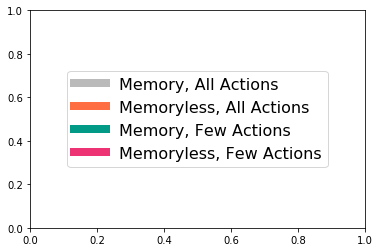

In [75]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#bababa', lw=8, label='Memory, All Actions'),
                   Line2D([0], [0], color='#ff6e42', lw=8, label='Memoryless, All Actions'),
                   Line2D([0], [0], color='#009a87', lw=8, label='Memory, Few Actions'),
                   Line2D([0], [0], color='#ee3375', lw=8, label='Memoryless, Few Actions'),
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', prop={'size': 16})

plt.show()

In [172]:
m = Chem.MolFromMolFile('./cyclohexane14.mol')
nv.show_rdkit(m)

NGLWidget()

In [173]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
print(nonring)

[([(0, 3, 6, 7), (5, 3, 6, 7)], 180.0), ([(1, 4, 11, 12), (2, 4, 11, 12)], 180.0), ([(3, 6, 7, 8)], 180.0), ([(6, 7, 8, 10)], 180.0), ([(4, 11, 12, 13)], 180.0), ([(11, 12, 13, 14)], 180.0), ([(12, 13, 14, 15)], 180.0), ([(13, 14, 15, 16)], 180.0)]
[([(0, 3, 5, 1), (3, 5, 1, 4), (5, 1, 4, 2), (1, 4, 2, 0), (4, 2, 0, 3), (2, 0, 3, 5)], 36.34137323903797)]


In [178]:
Chem.rdMolTransforms.GetDihedralDeg(m.GetConformer(id=0), 0, 3, 5, 1)

51.03146718662007

In [145]:
cids = AllChem.EmbedMultipleConfs(m, numConfs=10)

In [176]:
rdkit.Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(m)

1

In [179]:
confgen.get_conformer_energies(m)

array([12.55800568])

In [180]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
print(nonring)
print(ring)

[([(0, 3, 6, 7), (5, 3, 6, 7)], 180.0), ([(1, 4, 11, 12), (2, 4, 11, 12)], 180.0), ([(3, 6, 7, 8)], 180.0), ([(6, 7, 8, 10)], 180.0), ([(4, 11, 12, 13)], 180.0), ([(11, 12, 13, 14)], 180.0), ([(12, 13, 14, 15)], 180.0), ([(13, 14, 15, 16)], 180.0)]
[([(0, 3, 5, 1), (3, 5, 1, 4), (5, 1, 4, 2), (1, 4, 2, 0), (4, 2, 0, 3), (2, 0, 3, 5)], 36.34137323903797)]


In [139]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
ring = ring[0][0]

for i in range(1):
    conf = m.GetConformer(id=i)
#     for idx, tors in enumerate(nonring):
#         print('nonring')
#         atoms, ang = tors
#         tup = atoms[0]
#         deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
#         print(tup, deg)

    for tors in ring:
        print('ring')
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tors)
        print(tors, deg)

ring
(0, 3, 5, 1) 51.03146718662007
ring
(3, 5, 1, 4) 0.7488128411488192
ring
(5, 1, 4, 2) -51.86399141583419
ring
(1, 4, 2, 0) 51.06674898112858
ring
(4, 2, 0, 3) 0.7294832411201895
ring
(2, 0, 3, 5) -51.85675201911678


In [140]:
rdkit.Chem.rdMolTransforms.SetDihedralDeg(conf, 0, 3, 5, 1, 0)

ValueError: bond (j,k) must not belong to a ring

In [103]:
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

NGLWidget()

In [213]:
rdkit.Chem.TorsionFingerprints.CalculateTorsionWeights(mol)

[0.0027542287033381677,
 0.01096478196143185,
 0.03630780547701015,
 0.10000000000000002,
 0.22908676527677732,
 0.436515832240166,
 0.6918309709189365,
 0.9120108393559098,
 1.0,
 0.9120108393559098,
 0.6918309709189365,
 0.436515832240166,
 0.22908676527677732,
 0.10000000000000002,
 0.03630780547701015,
 0.01096478196143185,
 0.0027542287033381677]

In [169]:
ri = m.GetRingInfo()

In [227]:
ri.BondRings() 

((3, 7, 1, 2, 5, 0),)

In [219]:
ringbond = m.GetBondWithIdx(3)

In [222]:
ringbond.IsInRing()

True

In [239]:
m.GetPropsAsDict(includePrivate=True)

{'_Name': '',
 '_MolFileInfo': ' OpenBabel10291910303D',
 '_MolFileComments': '',
 '_MolFileChiralFlag': 1}

AttributeError: module 'rdkit.Chem.rdchem' has no attribute 'GetPropsAsDict'

In [240]:
ringbond.GetPropsAsDict(includePrivate=True)

{}

In [249]:
dm = AllChem.Get3DDistanceMatrix(mol); print(dm)

[[ 0.          0.82502515  1.4289      2.18273219  2.8579      3.59613654
   4.2868      5.01828237  5.7158      6.44341744  7.1447      7.87001785
   8.5736      9.29725539 10.0026     10.7250356  11.4315     12.1530026
   0.82502515 12.8605    ]
 [ 0.82502515  0.          0.82498856  1.4289      2.18273219  2.8579
   3.5960372   4.2868      5.01828237  5.7157      6.44341744  7.1447
   7.86991798  8.5736      9.29725539 10.0026     10.72493568 11.4315
   1.429      12.1530026 ]
 [ 1.4289      0.82498856  0.          0.82507515  1.429       2.18284929
   2.8579      3.59614801  4.2869      5.01829059  5.7158      6.44352364
   7.1447      7.87002309  8.5737      9.29735973 10.0026     10.72503945
   2.18275109 11.4316    ]
 [ 2.18273219  1.4289      0.82507515  0.          0.82502515  1.429
   2.18273219  2.8579      3.59613654  4.2868      5.01828237  5.7158
   6.44341744  7.1447      7.87001785  8.5737      9.29725539 10.0026
   2.8579     10.7250356 ]
 [ 2.8579      2.18273219  1.4

In [260]:
adj = Chem.rdmolops.GetAdjacencyMatrix(mol).astype(dm.dtype)
print(adj)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

In [264]:
stacked = np.stack([adj, dm], axis=-1)
stacked.shape

(20, 20, 2)

In [266]:
dm.max()

13.581265819134826